# <center>Spooky Author - LDA Approach</center>
<center>by: Victor Muñoz</center>

In [1]:
%%html
<style>
.nbviewer div.output_area {
  overflow-y: auto;
  max-height: 750px;
}
</style>

## Goal:

    The goal of this challenge is to predict the author of excerpts from horror stories by Edgar Allan Poe, Mary Shelley, and HP Lovecraft. We will try to accomplish this task, using LDA to predict author's writing styles. 

In [2]:
# First load the training dataset using pandas
import pandas as pd

training_dataset = pd.read_csv("train.csv")

all_text = training_dataset["text"].values
print(f"Training dataset size: {len(all_text)} sentences")

Training dataset size: 19579 sentences


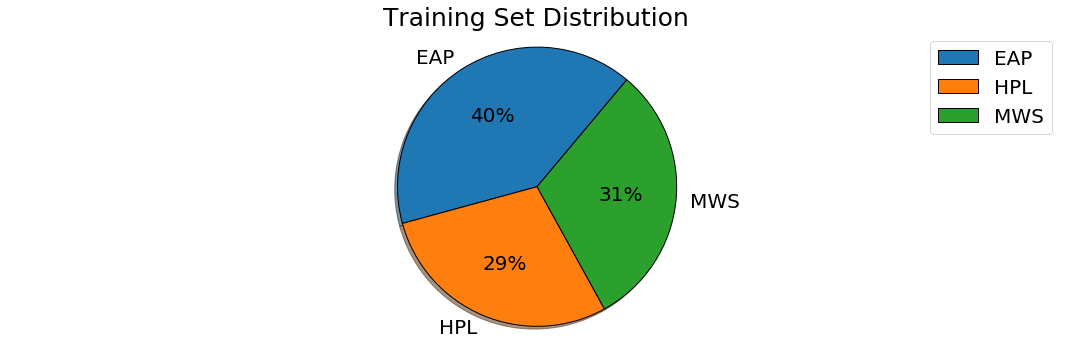

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

# Obtain all text of specific authors
eap_text = training_dataset[training_dataset.author=="EAP"]["text"].values
hpl_text = training_dataset[training_dataset.author=="HPL"]["text"].values
mws_text = training_dataset[training_dataset.author=="MWS"]["text"].values

labels = ["EAP", "HPL", "MWS"]
values = [len(eap_text), len(hpl_text), len(mws_text)]

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.pie(values, labels=labels, autopct='%1.0f%%', shadow = True, startangle=50, wedgeprops = { 'linewidth' : 1, 'edgecolor' : "black" }, textprops={'fontsize': 20})
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax.set_title("Training Set Distribution", fontsize = 25)

plt.legend(labels, loc="best", fontsize = 20)

plt.tight_layout()
plt.show()

## Natural Language Processing:

In [5]:
def text_processing(text, is_corpus = False):
    """
        if is_corpus = True: 
            text is a giant list of list containing the entire dataset
        if is_corpus = False:
            text is only a single list, so no need to iterate over it
    """
    
    # for every sublist in text, do all the necessary text pre-processing steps
    # text_processing includes tokenization, stopwords removal and lemmatization
    if is_corpus:
        text_list = []
        for line in text:
            line = tokenize(line)
            line = stopwords_removal(line)
            line = lemmatize(line)
            text_list.append(line)
        return text_list
    else:
        text = tokenize(text)
        text = stopwords_removal(text)
        text = lemmatize(text)
        return text

#### Tokenization 
    Break entire corpus into seperate individual words

In [6]:
import nltk
import re

def tokenize(text):
    """
        nltk.word_tokenize will tokenize every word 
        re.sub will remove all non alpha-numeric characters and lowercase every word
        filtering will remove empty lists
        returned the tokenized text
    """
    tokenized = nltk.word_tokenize(text)
    tokenized = [re.sub(r"\W+", "", t).lower() for t in tokenized]
    tokenized = list(filter(lambda t: t.isalnum(), tokenized))
    return tokenized

####  Lemmatization
    Rather than Porter Stemming, which chops each word into its root form. Lemmatization breaks each word into its dictionary form. 

In [7]:
from nltk.stem import WordNetLemmatizer

def lemmatize(text):
    """
        convert each word in text into its dictionary form
        return the dictionary form list
    """
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(token) for token in text]
    return lemmatized

#### Stopword Removal
    Remove all words that appear way too often, use nltk to select what are stopwords

In [8]:
def stopwords_removal(text):
    """
        remove all stopwords
        return list with all stopwords removed
    """
    stopwords = nltk.corpus.stopwords.words("english")
    stopwords_removed = list(filter(lambda st: st not in stopwords, text))
    return stopwords_removed

#### Process Text
    Call the text_processing function, which calls all other functions

In [9]:
# pre-process all text
all_processed_text = text_processing(all_text, is_corpus = True)
print(all_text[:5])
print()
print(all_processed_text[:5])

['This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.'
 'It never once occurred to me that the fumbling might be a mere mistake.'
 'In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.'
 'How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath, speckled by happy cottages and wealthier towns, all looked as in former years, heart cheering and fair.'
 'Finding nothing else, not even gold, the Superintendent abandoned his attempts; but a perplexed look occasionally steals over his countenance as he sits thinking at his desk.']

[['process', 'however', 'afforded', 'mean', 'ascertaining', 'dimension', 'dungeon', 'might', 'ma

## LDA:

    Main components LDA model takes in are the entire corpus as a bag of words, the number of topics to create and document-term matrix

In [10]:
from gensim.corpora import Dictionary
from gensim import models

def create_dictionary(training_dataset):
    """
        Mapping unique integer id's to words
    """
    dictionary = Dictionary(training_dataset)
    return dictionary

def create_corpus_bow(dictionary, training_dataset):
    """
        Count of word occurrence for each word
    """
    corpus_bow = [dictionary.doc2bow(text) for text in training_dataset]
    return corpus_bow

def create_lda_model(corpus_bow, dictionary, num_topics):
    """
        Topic Model:
            passes - Number of passes through the corpus during training
            random_state - Select a random seed, elimate randomness
    """
    lda_model = models.ldamodel.LdaModel(corpus_bow, num_topics = num_topics, id2word = dictionary, passes = 10, random_state = 1500)
    return lda_model

### LDA Model
    First create the dictionary (id2word) and corpus as bag of words.

In [11]:
dictionary_all = create_dictionary(all_processed_text)
corpus_bow_all = create_corpus_bow(dictionary_all, all_processed_text)

#### How Many Topics To Create?
    Before creating the topic model, we must figure out what is the best number of topics to create.
    Coherence is the measurement that is used to evaluate how well a topic model is created.
    Before I create the LDA model I will use for testing, I create multiple models with different number of topics 
    and calculate their coherence score
    

In [12]:
from gensim.models import CoherenceModel

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = models.ldamodel.LdaModel(corpus = corpus, id2word = dictionary, num_topics = num_topics, passes = 10, random_state = 1500)
        model_list.append(model)
        coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [13]:
"""
model_list, coherence_values = compute_coherence_values(dictionary = dictionary_all, corpus= corpus_bow_all, texts = all_processed_text, start=3, limit=25, step=3)
# Show graph
import matplotlib.pyplot as plt
limit=25; start=3; step=3;

x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.title("Coherence Values", fontsize = 20)
plt.xlabel("Num Topics", fontsize = 15)
plt.ylabel("Coherence score", fontsize = 15)
plt.show()
"""

'\nmodel_list, coherence_values = compute_coherence_values(dictionary = dictionary_all, corpus= corpus_bow_all, texts = all_processed_text, start=3, limit=25, step=3)\n# Show graph\nimport matplotlib.pyplot as plt\nlimit=25; start=3; step=3;\n\nx = range(start, limit, step)\nplt.plot(x, coherence_values)\nplt.title("Coherence Values", fontsize = 20)\nplt.xlabel("Num Topics", fontsize = 15)\nplt.ylabel("Coherence score", fontsize = 15)\nplt.show()\n'

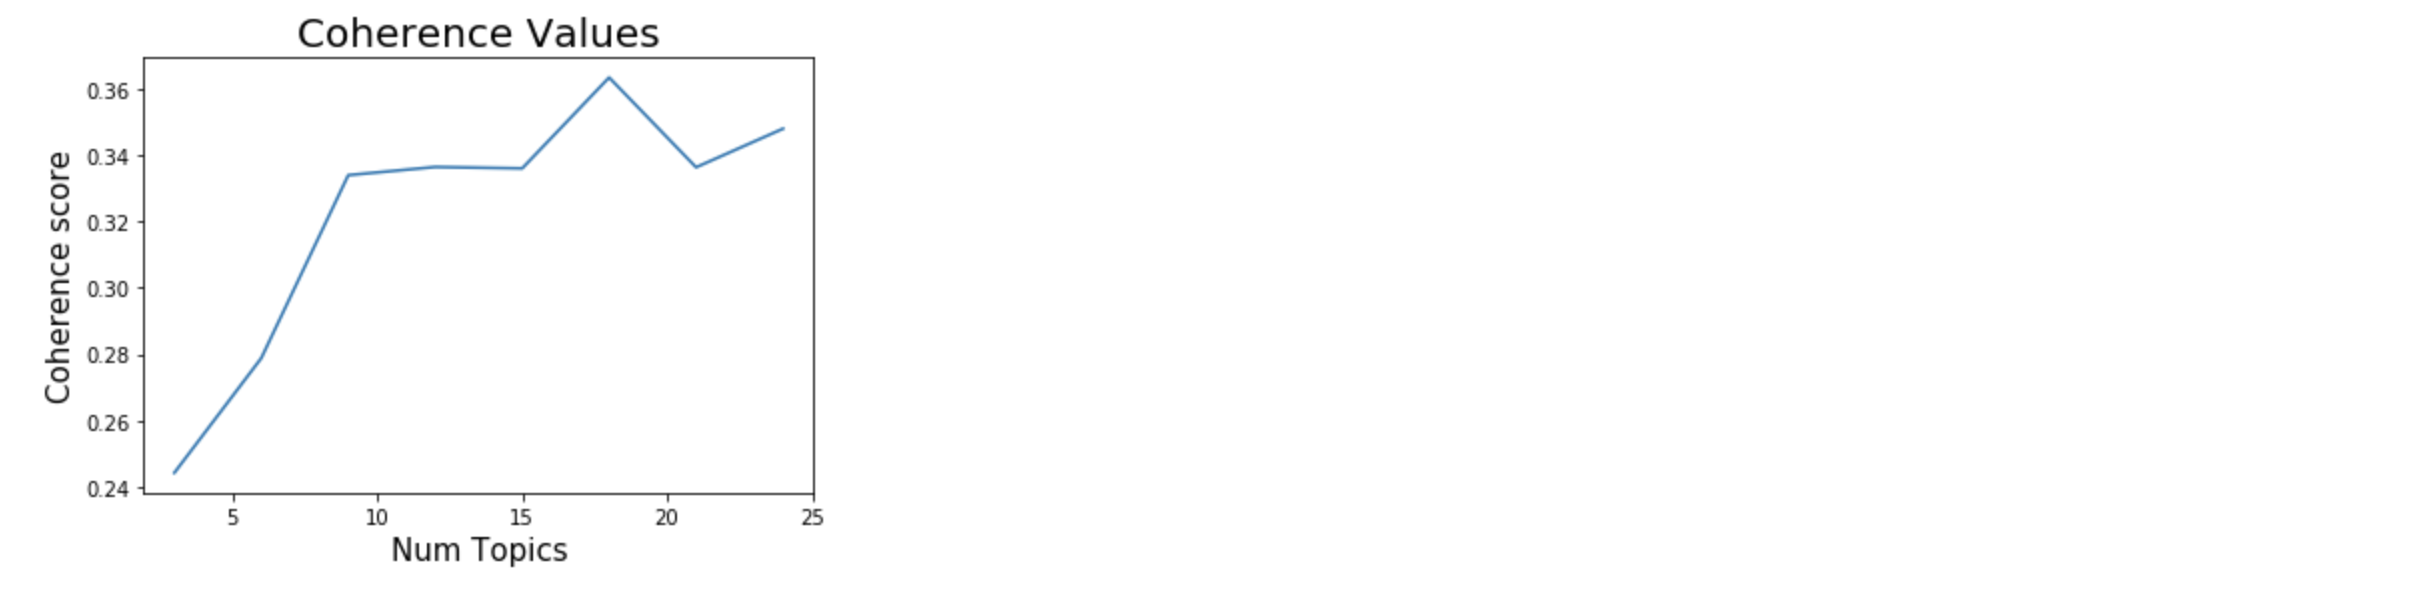

    The graph shows the coherence score increasing dramatically up until 9 topics. After 9 topics, the coherence 
    score does not change as drastically. Even though 18 topics has a higher coherence score, the difference between them is not much.
    9 topics would be a good choice because it has a fairly high coherence score without creating too many topics. The more topics that are 
    created the greater the likelihood of topics being intertwined with each other, which is something you should try to avoid. 

##### Create LDA Model Using 9 Topics

In [14]:
lda_model_all = create_lda_model(corpus_bow_all, dictionary_all, num_topics = 9)

    Compute coherence score of our model

In [15]:
# Compute Coherence Score
coherence_model_lda_all = CoherenceModel(model=lda_model_all, texts=all_processed_text, dictionary=dictionary_all, coherence='c_v')
coherence_lda_all = coherence_model_lda_all.get_coherence()
print('\nCoherence Score: ', coherence_lda_all)


Coherence Score:  0.3593825483258857


###### Print Topics

In [16]:
# Print topics that were create using LDA
print("Topics:")
for topic in lda_model_all.print_topics():
    print(topic)

Topics:
(0, '0.015*"would" + 0.015*"could" + 0.010*"thing" + 0.009*"one" + 0.008*"time" + 0.007*"must" + 0.007*"know" + 0.007*"never" + 0.006*"even" + 0.006*"yet"')
(1, '0.013*"one" + 0.007*"night" + 0.007*"found" + 0.007*"upon" + 0.007*"year" + 0.007*"day" + 0.007*"old" + 0.007*"two" + 0.006*"house" + 0.006*"time"')
(2, '0.009*"said" + 0.007*"might" + 0.006*"much" + 0.006*"great" + 0.006*"thus" + 0.006*"may" + 0.006*"well" + 0.005*"mr" + 0.005*"could" + 0.004*"friend"')
(3, '0.012*"upon" + 0.009*"one" + 0.009*"u" + 0.006*"said" + 0.005*"great" + 0.005*"little" + 0.005*"say" + 0.004*"let" + 0.004*"hand" + 0.004*"replied"')
(4, '0.011*"upon" + 0.006*"hand" + 0.005*"three" + 0.004*"within" + 0.004*"air" + 0.004*"inch" + 0.004*"figure" + 0.004*"table" + 0.003*"stand" + 0.003*"discovered"')
(5, '0.010*"heart" + 0.009*"love" + 0.008*"life" + 0.008*"yet" + 0.008*"eye" + 0.007*"would" + 0.006*"could" + 0.006*"feeling" + 0.006*"soul" + 0.005*"father"')
(6, '0.010*"light" + 0.009*"upon" + 0.008

###### Visualization

In [15]:
import pyLDAvis
import pyLDAvis.gensim

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_all, corpus_bow_all, dictionary_all, sort_topics = False)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.259944 -0.008840       1        1   9.655801
1     -0.111623  0.010415       2        1  12.780738
2      0.053116 -0.194761       3        1  10.573683
3      0.075388  0.074170       4        1  17.543072
4      0.016367  0.145745       5        1  11.193130
5     -0.157563 -0.035267       6        1   8.969591
6      0.122982  0.161309       7        1   8.364177
7      0.110122  0.026087       8        1   9.601707
8      0.151155 -0.178856       9        1  11.318095, topic_info=     Category         Freq     Term        Total  loglift  logprob
term                                                              
425   Default   637.000000     said   637.000000  30.0000  30.0000
843   Default   318.000000     door   318.000000  29.0000  29.0000
156   Default   465.000000      say   465.000000  28.0000  28.0000
63    Default   414.000000     year   414.000000  27.0000  27.0000
1102  Default   237.000000       mr   237.000000  26.0000  26.0000
33    Default   409.000000     hand   409.000000  25.0000  25.0000
692   Default   675.000000    thing   675.000000  24.0000  24.0000
440   Default  1322.000000     upon  1322.000000  23.0000  23.0000
769   Default   413.000000      two   413.000000  22.0000  22.0000
193   Default   597.000000     life   597.000000  21.0000  21.0000
18    Default   208.000000     wall   208.000000  20.0000  20.0000
826   Default   252.000000  raymond   252.000000  19.0000  19.0000
180   Default   685.000000      day   685.000000  18.0000  18.0000
847   Default   416.000000    house   416.000000  17.0000  17.0000
1135  Default   253.000000       nt   253.000000  16.0000  16.0000
1774  Default   278.000000    human   278.000000  15.0000  15.0000
468   Default   570.000000      old   570.000000  14.0000  14.0000
137   Default  1246.000000    could  1246.000000  13.0000  13.0000
1285  Default   540.000000    night   540.000000  12.0000  12.0000
167   Default   642.000000      yet   642.000000  11.0000  11.0000
3054  Default   145.000000     wish   145.000000  10.0000  10.0000
199   Default   290.000000     back   290.000000   9.0000   9.0000
204   Default   576.000000     like   576.000000   8.0000   8.0000
1122  Default   441.000000      may   441.000000   7.0000   7.0000
2017  Default   178.000000     wind   178.000000   6.0000   6.0000
936   Default   405.000000     word   405.000000   5.0000   5.0000
779   Default   229.000000   window   229.000000   4.0000   4.0000
250   Default   242.000000     soul   242.000000   3.0000   3.0000
1063  Default   201.000000     side   201.000000   2.0000   2.0000
259   Default   284.000000   nature   284.000000   1.0000   1.0000
...       ...          ...      ...          ...      ...      ...
417    Topic9   147.504120   matter   223.502075   1.7632  -5.2803
265    Topic9   213.328506     well   399.520630   1.5513  -4.9113
425    Topic9   299.974121     said   637.620605   1.4247  -4.5705
3119   Topic9    94.545021    quite   140.636856   1.7817  -5.7251
72     Topic9   143.906342  nothing   260.033936   1.5871  -5.3050
7      Topic9   163.586426  however   318.669250   1.5120  -5.1768
532    Topic9   151.561111       le   285.907379   1.5441  -5.2532
1245   Topic9    72.343834     sure    98.759491   1.8675  -5.9927
711    Topic9   161.134171     know   344.619263   1.4186  -5.1919
365    Topic9    62.618088   regard    79.407974   1.9412  -6.1371
1122   Topic9   183.670120      may   441.311951   1.3022  -5.0610
414    Topic9   100.229034    known   168.424225   1.6597  -5.6667
166    Topic9   289.828674    would  1140.413574   0.8089  -4.6049
1135   Topic9   117.752182       nt   253.250031   1.4130  -5.5056
734    Topic9   150.234665     much   418.761780   1.1537  -5.2620
579    Topic9   122.550034   indeed   287.960541   1.3245  -5.4656
209    Topic9   109.694435     idea   244.610901   1.3768  -5.5765
681    Topic9

#### Issue
    Having one LDA model doesn't allow us to explicitly tell the model what data comes from what author.
    Also, someone has to manually revise the topics and correlate each topic with an author.

In [17]:
# Print topic number, weight 
def test_dataset_LDA(text, author = None):
    author_guess = ""
    max_weight = 0
    
    # Map topic number to authors, the above graph are all indexed + 1. Meaning key 0 is mapped to circle 1, key 1 mapped to circle 2, ...
    author_dictionary = {
        0 : "HPL", # space
        1 : "HPL", # ?
        2 : "MWS", # raymond, perdita
        3 : "MWS", # heart, love
        4 : "MWS", # adrian, elizabeth
        5 : "MWS", # sister, melancholy
        6 : "EAP", # smile (could be EAP because of "mystery") ?
        7 : "HPL", # innsmouth
        8 : "EAP", # mr, le
    }
    
    # Apply text-processing steps to text 
    print('"' + text + '"\n')
    test = text_processing(text)
    
    # LDA modeling
    test_bow = dictionary_all.doc2bow(test)
    test_lda = lda_model_all[test_bow]
    print("Topic Number - Author\tWeight")
    for topic_number, freq in test_lda:  
        print(str(topic_number) + "\t     - " + author_dictionary[topic_number] + "\t" + str(round(freq, 4)))
        if freq > max_weight:
            max_weight = freq
            author_guess = author_dictionary[topic_number]

    print(f"\nAuthor Guess:\t {author_guess}, \tWeight: {str(round(max_weight, 4))}")
    if author is not None:
        print("Author Actual:\t " + author)
        
    return author_guess

In [18]:
i = 0
text = training_dataset.text[i]
author = training_dataset.author[i]
test_dataset_LDA(text, author)

"This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall."

Topic Number - Author	Weight
0	     - HPL	0.2065
2	     - MWS	0.1895
3	     - MWS	0.1216
4	     - MWS	0.071
6	     - EAP	0.0626
7	     - HPL	0.3336

Author Guess:	 HPL, 	Weight: 0.3336
Author Actual:	 EAP


'HPL'

In [19]:
i = 10
text = training_dataset.text[i]
author = training_dataset.author[i]
test_dataset_LDA(text, author)

"He shall find that I can feel my injuries; he shall learn to dread my revenge" A few days after he arrived."

Topic Number - Author	Weight
0	     - HPL	0.1571
1	     - HPL	0.0101
2	     - MWS	0.0101
3	     - MWS	0.0101
4	     - MWS	0.0101
5	     - MWS	0.6725
6	     - EAP	0.0101
7	     - HPL	0.1098
8	     - EAP	0.0101

Author Guess:	 MWS, 	Weight: 0.6725
Author Actual:	 MWS


'MWS'

## Testing:

#### Test LDA Models Using "Seen" Data

In [20]:
i = 1
text = training_dataset.text[i]
author = training_dataset.author[i]
print("LDA:")
test_dataset_LDA(text, author)

LDA:
"It never once occurred to me that the fumbling might be a mere mistake."

Topic Number - Author	Weight
0	     - HPL	0.46
1	     - HPL	0.0159
2	     - MWS	0.0159
3	     - MWS	0.0159
4	     - MWS	0.0159
5	     - MWS	0.0159
6	     - EAP	0.0159
7	     - HPL	0.0159
8	     - EAP	0.4288

Author Guess:	 HPL, 	Weight: 0.46
Author Actual:	 HPL


'HPL'

In [21]:
i = 10
text = training_dataset.text[i]
author = training_dataset.author[i]
print("LDA:")
test_dataset_LDA(text, author)

LDA:
"He shall find that I can feel my injuries; he shall learn to dread my revenge" A few days after he arrived."

Topic Number - Author	Weight
0	     - HPL	0.1571
1	     - HPL	0.0101
2	     - MWS	0.0101
3	     - MWS	0.0101
4	     - MWS	0.0101
5	     - MWS	0.6725
6	     - EAP	0.0101
7	     - HPL	0.1098
8	     - EAP	0.0101

Author Guess:	 MWS, 	Weight: 0.6725
Author Actual:	 MWS


'MWS'

In [22]:
i = 100
text = training_dataset.text[i]
author = training_dataset.author[i]
print("LDA:")
test_dataset_LDA(text, author)

LDA:
"They still appeared in public together, and lived under the same roof."

Topic Number - Author	Weight
0	     - HPL	0.0159
1	     - HPL	0.565
2	     - MWS	0.3238
3	     - MWS	0.0159
4	     - MWS	0.0159
5	     - MWS	0.0159
6	     - EAP	0.0159
7	     - HPL	0.0159
8	     - EAP	0.0159

Author Guess:	 HPL, 	Weight: 0.565
Author Actual:	 MWS


'HPL'

In [23]:
i = 1000
text = training_dataset.text[i]
author = training_dataset.author[i]
print("LDA:")
test_dataset_LDA(text, author)

LDA:
"It was our plan to remain where we were and intercept the liner Dacia, mentioned in information from agents in New York."

Topic Number - Author	Weight
0	     - HPL	0.0111
1	     - HPL	0.2028
2	     - MWS	0.0111
3	     - MWS	0.2727
4	     - MWS	0.0111
5	     - MWS	0.0111
6	     - EAP	0.4578
7	     - HPL	0.0111
8	     - EAP	0.0111

Author Guess:	 EAP, 	Weight: 0.4578
Author Actual:	 HPL


'EAP'

In [24]:
i = 10000
text = training_dataset.text[i]
author = training_dataset.author[i]
print("LDA:")
test_dataset_LDA(text, author)

LDA:
"Frequently he would glance at the door as if he expected someone, and at length his glance seemed answered by a singular rapping which must have followed some very ancient and secret code."

Topic Number - Author	Weight
0	     - HPL	0.2513
6	     - EAP	0.4941
8	     - EAP	0.2175

Author Guess:	 EAP, 	Weight: 0.4941
Author Actual:	 HPL


'EAP'

#### Test LDA Models Using "Unseen" Data

In [25]:
# import test.csv file and read file using pandas
testing_dataset = pd.read_csv("labeledTest.csv")

print(f"Testing dataset size: {len(testing_dataset)} sentences")

Testing dataset size: 4213 sentences


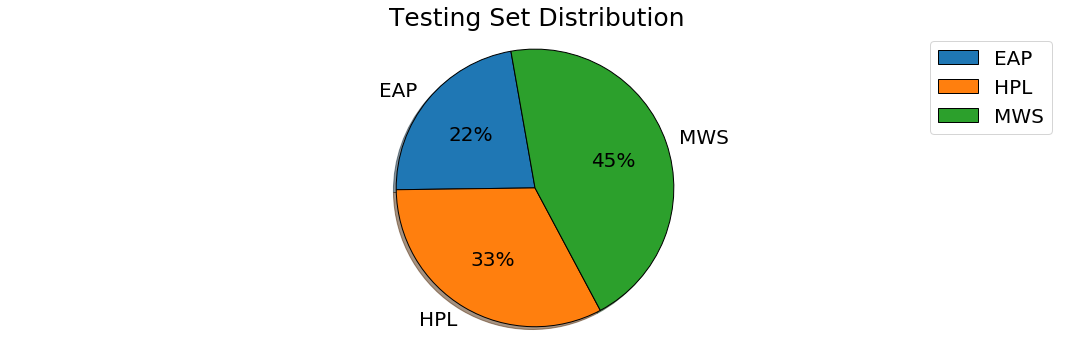

In [26]:
# Obtain all text of specific authors
eap_text_test = testing_dataset[testing_dataset.author=="EAP"]["text"].values
hpl_text_test = testing_dataset[testing_dataset.author=="HPL"]["text"].values
mws_text_test = testing_dataset[testing_dataset.author=="MWS"]["text"].values

labels = ["EAP", "HPL", "MWS"]
values = [len(eap_text_test), len(hpl_text_test), len(mws_text_test)]

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.pie(values, labels=labels, autopct='%1.0f%%', shadow = True, startangle=100, wedgeprops = { 'linewidth' : 1, 'edgecolor' : "black" }, textprops={'fontsize': 20})
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax.set_title("Testing Set Distribution", fontsize = 25)

plt.legend(labels, loc="best", fontsize = 20)

plt.tight_layout()
plt.show()

In [27]:
correct_guesses_LDA = 0

for i in range(len(testing_dataset)):
    text = testing_dataset.text[i]
    author = testing_dataset.author[i]
    print("LDA:")
    lda_guess_LDA = test_dataset_LDA(text, author)
    if lda_guess_LDA == author:
        correct_guesses_LDA += 1

LDA:
"Still, as I urged our leaving Ireland with such inquietude and impatience, my father thought it best to yield."

Topic Number - Author	Weight
0	     - HPL	0.3371
1	     - HPL	0.0101
2	     - MWS	0.1403
3	     - MWS	0.1498
4	     - MWS	0.1013
5	     - MWS	0.1156
6	     - EAP	0.0101
7	     - HPL	0.0101
8	     - EAP	0.1256

Author Guess:	 HPL, 	Weight: 0.3371
Author Actual:	 MWS
LDA:
"And when they had broken down the frail door they found only this: two cleanly picked human skeletons on the earthen floor, and a number of singular beetles crawling in the shadowy corners."

Topic Number - Author	Weight
1	     - HPL	0.398
2	     - MWS	0.1019
4	     - MWS	0.1336
5	     - MWS	0.0833
6	     - EAP	0.1717
7	     - HPL	0.0917

Author Guess:	 HPL, 	Weight: 0.398
Author Actual:	 HPL
LDA:
"I am not sure to what limit his knowledge may extend."

Topic Number - Author	Weight
0	     - HPL	0.2243
1	     - HPL	0.1848
2	     - MWS	0.4796
3	     - MWS	0.0185
4	     - MWS	0.0185
5	     - MWS	0.0185
6	

Topic Number - Author	Weight
0	     - HPL	0.0139
1	     - HPL	0.6078
2	     - MWS	0.0139
3	     - MWS	0.0139
4	     - MWS	0.0139
5	     - MWS	0.2951
6	     - EAP	0.0139
7	     - HPL	0.0139
8	     - EAP	0.0139

Author Guess:	 HPL, 	Weight: 0.6078
Author Actual:	 MWS
LDA:
"Never before had he, who was born even to the inheritance of the throne of England, never had he asked favour or honour from those now his equals, but who might have been his subjects."

Topic Number - Author	Weight
0	     - HPL	0.5089
2	     - MWS	0.359
4	     - MWS	0.0844

Author Guess:	 HPL, 	Weight: 0.5089
Author Actual:	 MWS
LDA:
"For one thing, the people were more hideous and abnormal than those near the centre of the town; so that I was several times evilly reminded of something utterly fantastic which I could not quite place."

Topic Number - Author	Weight
0	     - HPL	0.1786
1	     - HPL	0.3947
2	     - MWS	0.087
4	     - MWS	0.0643
8	     - EAP	0.2519

Author Guess:	 HPL, 	Weight: 0.3947
Author Actual:	 HPL


Topic Number - Author	Weight
0	     - HPL	0.6057
1	     - HPL	0.0124
2	     - MWS	0.0124
3	     - MWS	0.1413
4	     - MWS	0.0123
5	     - MWS	0.0124
6	     - EAP	0.1789
7	     - HPL	0.0124
8	     - EAP	0.0124

Author Guess:	 HPL, 	Weight: 0.6057
Author Actual:	 HPL
LDA:
"After some hours he revived, recognized individuals of his acquaintance, and, in broken sentences spoke of his agonies in the grave."

Topic Number - Author	Weight
0	     - HPL	0.1009
1	     - HPL	0.2833
2	     - MWS	0.2408
3	     - MWS	0.1172
4	     - MWS	0.0101
5	     - MWS	0.2173
6	     - EAP	0.0101
7	     - HPL	0.0101
8	     - EAP	0.0101

Author Guess:	 HPL, 	Weight: 0.2833
Author Actual:	 EAP
LDA:
"Counting the parties so far glimpsed, as well as those presumably covering other roads, the number of my pursuers must be strangely large for a town as depopulated as Innsmouth."

Topic Number - Author	Weight
0	     - HPL	0.0912
1	     - HPL	0.2882
2	     - MWS	0.2097
3	     - MWS	0.1064
6	     - EAP	0.1126
8	     - EAP

Topic Number - Author	Weight
0	     - HPL	0.0159
1	     - HPL	0.0159
2	     - MWS	0.0159
3	     - MWS	0.0159
4	     - MWS	0.0159
5	     - MWS	0.3175
6	     - EAP	0.5712
7	     - HPL	0.0159
8	     - EAP	0.0159

Author Guess:	 EAP, 	Weight: 0.5712
Author Actual:	 EAP
LDA:
"Kinder like Injuns, I guess, even ef they be in Afriky."

Topic Number - Author	Weight
0	     - HPL	0.3037
1	     - HPL	0.0185
2	     - MWS	0.0185
3	     - MWS	0.0185
4	     - MWS	0.0185
5	     - MWS	0.0185
6	     - EAP	0.0185
7	     - HPL	0.0185
8	     - EAP	0.5671

Author Guess:	 EAP, 	Weight: 0.5671
Author Actual:	 HPL
LDA:
"West liked to think that before his recent disappearance, but there were times when he could not; for it was queer that we both had the same hallucination."

Topic Number - Author	Weight
0	     - HPL	0.1952
1	     - HPL	0.6267
2	     - MWS	0.0111
3	     - MWS	0.0111
4	     - MWS	0.1113
5	     - MWS	0.0111
6	     - EAP	0.0111
7	     - HPL	0.0111
8	     - EAP	0.0111

Author Guess:	 HPL, 	Weight: 0

Topic Number - Author	Weight
0	     - HPL	0.022
1	     - HPL	0.022
2	     - MWS	0.022
3	     - MWS	0.2207
4	     - MWS	0.022
5	     - MWS	0.022
6	     - EAP	0.022
7	     - HPL	0.2237
8	     - EAP	0.4235

Author Guess:	 EAP, 	Weight: 0.4235
Author Actual:	 MWS
LDA:
""A mere bagtelle," said Monsieur Maillard."

Topic Number - Author	Weight
0	     - HPL	0.0223
1	     - HPL	0.2389
2	     - MWS	0.6053
3	     - MWS	0.0222
4	     - MWS	0.0223
5	     - MWS	0.0222
6	     - EAP	0.0222
7	     - HPL	0.0222
8	     - EAP	0.0223

Author Guess:	 MWS, 	Weight: 0.6053
Author Actual:	 EAP
LDA:
"Your witness says he saw us at half past eleven on the Gainesville pike, headed for Big Cypress Swamp."

Topic Number - Author	Weight
2	     - MWS	0.1008
5	     - MWS	0.1583
6	     - EAP	0.2255
8	     - EAP	0.4728

Author Guess:	 EAP, 	Weight: 0.4728
Author Actual:	 HPL
LDA:
"There was a dark open doorway on the right, to which the black man silently pointed."

Topic Number - Author	Weight
0	     - HPL	0.0123
1	  

Topic Number - Author	Weight
0	     - HPL	0.4916
1	     - HPL	0.0111
2	     - MWS	0.1458
3	     - MWS	0.0111
4	     - MWS	0.0111
5	     - MWS	0.0111
6	     - EAP	0.0111
7	     - HPL	0.0111
8	     - EAP	0.2959

Author Guess:	 HPL, 	Weight: 0.4916
Author Actual:	 HPL
LDA:
"Lord Raymond was the sole remnant of a noble but impoverished family."

Topic Number - Author	Weight
0	     - HPL	0.5591
1	     - HPL	0.0159
2	     - MWS	0.1665
3	     - MWS	0.0159
4	     - MWS	0.0159
5	     - MWS	0.0159
6	     - EAP	0.0159
7	     - HPL	0.0159
8	     - EAP	0.179

Author Guess:	 HPL, 	Weight: 0.5591
Author Actual:	 MWS
LDA:
"It was May before they arrived: the season had decked the forest trees with leaves, and its paths with a thousand flowers."

Topic Number - Author	Weight
0	     - HPL	0.0101
1	     - HPL	0.3138
2	     - MWS	0.0101
3	     - MWS	0.0101
4	     - MWS	0.1821
5	     - MWS	0.1961
6	     - EAP	0.2574
7	     - HPL	0.0101
8	     - EAP	0.0101

Author Guess:	 HPL, 	Weight: 0.3138
Author Actual:

Author Guess:	 HPL, 	Weight: 0.7137
Author Actual:	 MWS
LDA:
"They performed towards him every little office of affection and duty with gentleness, and he rewarded them by his benevolent smiles."

Topic Number - Author	Weight
0	     - HPL	0.2611
2	     - MWS	0.1853
3	     - MWS	0.1312
5	     - MWS	0.376

Author Guess:	 MWS, 	Weight: 0.376
Author Actual:	 MWS
LDA:
"And then a second horror took possession of my soul."

Topic Number - Author	Weight
0	     - HPL	0.0185
1	     - HPL	0.0185
2	     - MWS	0.0185
3	     - MWS	0.618
4	     - MWS	0.0185
5	     - MWS	0.2523
6	     - EAP	0.0185
7	     - HPL	0.0185
8	     - EAP	0.0185

Author Guess:	 MWS, 	Weight: 0.618
Author Actual:	 HPL
LDA:
"They swear no harm or pain can inhabit that high peaked cottage, for in the new voices gladness beats, and with them the tinkle of laughter and music."

Topic Number - Author	Weight
0	     - HPL	0.1189
3	     - MWS	0.2725
5	     - MWS	0.2656
7	     - HPL	0.1679
8	     - EAP	0.1409

Author Guess:	 MWS, 	Weig

Topic Number - Author	Weight
0	     - HPL	0.4265
1	     - HPL	0.0185
2	     - MWS	0.0185
3	     - MWS	0.2777
4	     - MWS	0.0185
5	     - MWS	0.0185
6	     - EAP	0.0185
7	     - HPL	0.0185
8	     - EAP	0.1849

Author Guess:	 HPL, 	Weight: 0.4265
Author Actual:	 MWS
LDA:
"At length the slight quivering of an eyelid, and immediately thereupon, an electric shock of a terror, deadly and indefinite, which sends the blood in torrents from the temples to the heart."

Topic Number - Author	Weight
0	     - HPL	0.0834
1	     - HPL	0.1304
2	     - MWS	0.0791
3	     - MWS	0.1661
4	     - MWS	0.1619
5	     - MWS	0.2425
6	     - EAP	0.1224

Author Guess:	 MWS, 	Weight: 0.2425
Author Actual:	 EAP
LDA:
"I fancied them as they were in their prime, when Greenwich was a placid village not yet engulfed by the town; and in the hours before dawn, when all the revellers had slunk away, I used to wander alone among their cryptical windings and brood upon the curious arcana which generations must have deposite

5	     - MWS	0.0112
6	     - EAP	0.0112
7	     - HPL	0.1078
8	     - EAP	0.1811

Author Guess:	 HPL, 	Weight: 0.4
Author Actual:	 MWS
LDA:
"Idris appeared suspended for a moment, and then with extreme sweetness, she said, "Lord Raymond, I confide in your goodness and honour.""

Topic Number - Author	Weight
0	     - HPL	0.2046
2	     - MWS	0.1436
3	     - MWS	0.2153
4	     - MWS	0.0876
5	     - MWS	0.2378
7	     - HPL	0.0855

Author Guess:	 MWS, 	Weight: 0.2378
Author Actual:	 MWS
LDA:
""There are two brothers, I know; and both have attained reputation in letters."

Topic Number - Author	Weight
0	     - HPL	0.0159
1	     - HPL	0.0159
2	     - MWS	0.0159
3	     - MWS	0.0159
4	     - MWS	0.0159
5	     - MWS	0.5872
6	     - EAP	0.3015
7	     - HPL	0.0159
8	     - EAP	0.0159

Author Guess:	 MWS, 	Weight: 0.5872
Author Actual:	 EAP
LDA:
"Whether he had killed the ancient crone he did not know, but he let her rest on the floor where she had fallen."

Topic Number - Author	Weight
0	     - HPL	

Topic Number - Author	Weight
2	     - MWS	0.2307
3	     - MWS	0.1339
5	     - MWS	0.1125
6	     - EAP	0.4767

Author Guess:	 EAP, 	Weight: 0.4767
Author Actual:	 HPL
LDA:
"Our gods have promised us a haven of light beyond death, where there shall be rest without end, and crystal coldness amidst which none shall vex his mind with thought or his eyes with beauty."

Topic Number - Author	Weight
0	     - HPL	0.4444
2	     - MWS	0.1669
5	     - MWS	0.1984
6	     - EAP	0.1638

Author Guess:	 HPL, 	Weight: 0.4444
Author Actual:	 HPL
LDA:
"It was impossible to guess at the whole of her plan."

Topic Number - Author	Weight
0	     - HPL	0.5646
1	     - HPL	0.0222
2	     - MWS	0.0222
3	     - MWS	0.2797
4	     - MWS	0.0222
5	     - MWS	0.0223
6	     - EAP	0.0222
7	     - HPL	0.0223
8	     - EAP	0.0222

Author Guess:	 HPL, 	Weight: 0.5646
Author Actual:	 MWS
LDA:
"Adrian was impatient for our departure, and had advanced far in his preparations."

Topic Number - Author	Weight
0	     - HPL	0.0159
1	

Topic Number - Author	Weight
0	     - HPL	0.2213
1	     - HPL	0.0223
2	     - MWS	0.1366
3	     - MWS	0.0223
4	     - MWS	0.0223
5	     - MWS	0.0223
6	     - EAP	0.0223
7	     - HPL	0.0223
8	     - EAP	0.5085

Author Guess:	 EAP, 	Weight: 0.5085
Author Actual:	 MWS
LDA:
"So far as concrete noises went, the rats in the ancient partitions were the worst."

Topic Number - Author	Weight
0	     - HPL	0.0138
1	     - HPL	0.1589
2	     - MWS	0.0138
3	     - MWS	0.1506
4	     - MWS	0.0138
5	     - MWS	0.0138
6	     - EAP	0.403
7	     - HPL	0.0138
8	     - EAP	0.2183

Author Guess:	 EAP, 	Weight: 0.403
Author Actual:	 HPL
LDA:
"But after a while there was a further clicking in the receiver, and I strained my ears to listen."

Topic Number - Author	Weight
0	     - HPL	0.1856
1	     - HPL	0.0186
2	     - MWS	0.0186
3	     - MWS	0.3526
4	     - MWS	0.1847
5	     - MWS	0.0186
6	     - EAP	0.0186
7	     - HPL	0.0186
8	     - EAP	0.1843

Author Guess:	 MWS, 	Weight: 0.3526
Author Actual:	 HPL
LDA:
"I

Topic Number - Author	Weight
0	     - HPL	0.331
4	     - MWS	0.1719
5	     - MWS	0.2198
6	     - EAP	0.1796
7	     - HPL	0.0755

Author Guess:	 HPL, 	Weight: 0.331
Author Actual:	 MWS
LDA:
"There were several deep scratches just below the chin, together with a series of livid spots which were evidently the impression of fingers."

Topic Number - Author	Weight
0	     - HPL	0.0101
1	     - HPL	0.0101
2	     - MWS	0.0101
3	     - MWS	0.0101
4	     - MWS	0.2419
5	     - MWS	0.0101
6	     - EAP	0.5869
7	     - HPL	0.0101
8	     - EAP	0.1106

Author Guess:	 EAP, 	Weight: 0.5869
Author Actual:	 EAP
LDA:
"From one of these depended a short chain, from the other a padlock."

Topic Number - Author	Weight
0	     - HPL	0.5113
1	     - HPL	0.0185
2	     - MWS	0.0185
3	     - MWS	0.0185
4	     - MWS	0.0185
5	     - MWS	0.0185
6	     - EAP	0.0185
7	     - HPL	0.359
8	     - EAP	0.0185

Author Guess:	 HPL, 	Weight: 0.5113
Author Actual:	 EAP
LDA:
"These colors had now assumed, and were momentarily ass

3	     - MWS	0.1333
5	     - MWS	0.3358
6	     - EAP	0.1548
7	     - HPL	0.0869

Author Guess:	 MWS, 	Weight: 0.3358
Author Actual:	 MWS
LDA:
"This valley is more wonderful and sublime, but not so beautiful and picturesque as that of Servox, through which I had just passed."

Topic Number - Author	Weight
0	     - HPL	0.1587
1	     - HPL	0.2676
2	     - MWS	0.0158
3	     - MWS	0.0158
4	     - MWS	0.0158
5	     - MWS	0.0159
6	     - EAP	0.2309
7	     - HPL	0.0158
8	     - EAP	0.2635

Author Guess:	 HPL, 	Weight: 0.2676
Author Actual:	 MWS
LDA:
"He said that he was wearing away his time fruitlessly where he was, that letters from the friends he had formed in London desired his return to complete the negotiation they had entered into for his Indian enterprise."

Topic Number - Author	Weight
1	     - HPL	0.1918
3	     - MWS	0.2222
5	     - MWS	0.3993
6	     - EAP	0.1496

Author Guess:	 MWS, 	Weight: 0.3993
Author Actual:	 MWS
LDA:
"Though the golden light of late afternoon gave the ancient 

Topic Number - Author	Weight
0	     - HPL	0.0139
1	     - HPL	0.0139
2	     - MWS	0.1381
3	     - MWS	0.0139
4	     - MWS	0.0139
5	     - MWS	0.2032
6	     - EAP	0.325
7	     - HPL	0.2641
8	     - EAP	0.0139

Author Guess:	 EAP, 	Weight: 0.325
Author Actual:	 EAP
LDA:
"Diana filled up all his heart: he felt as if by his union with her he had received a new and better soul."

Topic Number - Author	Weight
0	     - HPL	0.0111
1	     - HPL	0.1874
2	     - MWS	0.2976
3	     - MWS	0.0111
4	     - MWS	0.0111
5	     - MWS	0.4482
6	     - EAP	0.0111
7	     - HPL	0.0111
8	     - EAP	0.0111

Author Guess:	 MWS, 	Weight: 0.4482
Author Actual:	 MWS
LDA:
"It was an odd cry, and all the more terrible because it was answered."

Topic Number - Author	Weight
0	     - HPL	0.0222
1	     - HPL	0.0222
2	     - MWS	0.0222
3	     - MWS	0.2221
4	     - MWS	0.0222
5	     - MWS	0.0222
6	     - EAP	0.6223
7	     - HPL	0.0222
8	     - EAP	0.0222

Author Guess:	 EAP, 	Weight: 0.6223
Author Actual:	 HPL
LDA:
"Reflec

Topic Number - Author	Weight
0	     - HPL	0.0222
1	     - HPL	0.4222
2	     - MWS	0.0222
3	     - MWS	0.4222
4	     - MWS	0.0222
5	     - MWS	0.0222
6	     - EAP	0.0222
7	     - HPL	0.0222
8	     - EAP	0.0222

Author Guess:	 MWS, 	Weight: 0.4222
Author Actual:	 HPL
LDA:
"For new individualities, matter is necessary."

Topic Number - Author	Weight
0	     - HPL	0.4886
1	     - HPL	0.0252
2	     - MWS	0.0252
3	     - MWS	0.3351
4	     - MWS	0.0252
5	     - MWS	0.0252
6	     - EAP	0.0252
7	     - HPL	0.0252
8	     - EAP	0.0252

Author Guess:	 HPL, 	Weight: 0.4886
Author Actual:	 EAP
LDA:
"Had it contained confirmation, she must have been annihilated."

Topic Number - Author	Weight
0	     - HPL	0.152
1	     - HPL	0.0223
2	     - MWS	0.0223
3	     - MWS	0.2244
4	     - MWS	0.2219
5	     - MWS	0.0223
6	     - EAP	0.0223
7	     - HPL	0.2903
8	     - EAP	0.0223

Author Guess:	 HPL, 	Weight: 0.2903
Author Actual:	 MWS
LDA:
"There were meats enough to have feasted the Anakim."

Topic Number - Aut

Topic Number - Author	Weight
0	     - HPL	0.0222
1	     - HPL	0.8221
2	     - MWS	0.0222
3	     - MWS	0.0222
4	     - MWS	0.0222
5	     - MWS	0.0222
6	     - EAP	0.0222
7	     - HPL	0.0222
8	     - EAP	0.0222

Author Guess:	 HPL, 	Weight: 0.8221
Author Actual:	 MWS
LDA:
"I will melt the stony hearts of your enemies by my tears and prayers."

Topic Number - Author	Weight
0	     - HPL	0.0159
1	     - HPL	0.0159
2	     - MWS	0.188
3	     - MWS	0.0159
4	     - MWS	0.2729
5	     - MWS	0.3022
6	     - EAP	0.1574
7	     - HPL	0.0159
8	     - EAP	0.0159

Author Guess:	 MWS, 	Weight: 0.3022
Author Actual:	 MWS
LDA:
"Between ingenuity and the analytic ability there exists a difference far greater, indeed, than that between the fancy and the imagination, but of a character very strictly analogous."

Topic Number - Author	Weight
0	     - HPL	0.1062
1	     - HPL	0.0904
2	     - MWS	0.2904
3	     - MWS	0.0985
7	     - HPL	0.3827

Author Guess:	 HPL, 	Weight: 0.3827
Author Actual:	 EAP
LDA:
"I am mor

Topic Number - Author	Weight
0	     - HPL	0.308
4	     - MWS	0.2973
5	     - MWS	0.1665
7	     - HPL	0.1855

Author Guess:	 HPL, 	Weight: 0.308
Author Actual:	 HPL
LDA:
"His eyes were bright, his countenance composed, an air of concentrated energy was diffused over his whole person, much unlike its former languor."

Topic Number - Author	Weight
0	     - HPL	0.1984
1	     - HPL	0.1228
2	     - MWS	0.2372
4	     - MWS	0.1884
5	     - MWS	0.2235

Author Guess:	 MWS, 	Weight: 0.2372
Author Actual:	 MWS
LDA:
"If I trembled at the blast which has hitherto attended us, shall I not stand aghast at a warring of wind and ocean, to convey any idea of which the words tornado and simoom are trivial and ineffective?"

Topic Number - Author	Weight
0	     - HPL	0.2037
1	     - HPL	0.1598
2	     - MWS	0.0827
3	     - MWS	0.1207
4	     - MWS	0.0971
5	     - MWS	0.314

Author Guess:	 MWS, 	Weight: 0.314
Author Actual:	 EAP
LDA:
"Choosing the direction toward the house, I scrambled recklessly into the nar

7	     - HPL	0.0123
8	     - EAP	0.0123

Author Guess:	 HPL, 	Weight: 0.4053
Author Actual:	 MWS
LDA:
"They hopped irregularly, sometimes on two legs and sometimes on four."

Topic Number - Author	Weight
0	     - HPL	0.0185
1	     - HPL	0.8521
2	     - MWS	0.0185
3	     - MWS	0.0185
4	     - MWS	0.0185
5	     - MWS	0.0185
6	     - EAP	0.0185
7	     - HPL	0.0185
8	     - EAP	0.0185

Author Guess:	 HPL, 	Weight: 0.8521
Author Actual:	 HPL
LDA:
"Then there was the crumbling farmhouse of old Goody Fowler the witch, with its little evil windows and great roof sloping nearly to the ground on the north side."

Topic Number - Author	Weight
1	     - HPL	0.1956
5	     - MWS	0.1091
6	     - EAP	0.4198
8	     - EAP	0.2384

Author Guess:	 EAP, 	Weight: 0.4198
Author Actual:	 HPL
LDA:
"I must expiate these crimes, and must endeavour in some degree to proportionate my punishment to my guilt."

Topic Number - Author	Weight
0	     - HPL	0.1854
1	     - HPL	0.0113
2	     - MWS	0.0113
3	     - MWS	0.1011

Topic Number - Author	Weight
0	     - HPL	0.5668
4	     - MWS	0.3733

Author Guess:	 HPL, 	Weight: 0.5668
Author Actual:	 EAP
LDA:
"It glowed and blushed beneath the eyes of the slant sunlight, and fairly laughed with flowers."

Topic Number - Author	Weight
0	     - HPL	0.0111
1	     - HPL	0.1568
2	     - MWS	0.0111
3	     - MWS	0.2332
4	     - MWS	0.0111
5	     - MWS	0.0111
6	     - EAP	0.384
7	     - HPL	0.0111
8	     - EAP	0.1704

Author Guess:	 EAP, 	Weight: 0.384
Author Actual:	 EAP
LDA:
"In wild delirium she called upon the name of Raymond; she exclaimed that I was keeping him from her, while the Turks with fearful instruments of torture were about to take his life."

Topic Number - Author	Weight
1	     - HPL	0.158
4	     - MWS	0.1295
5	     - MWS	0.4012
7	     - HPL	0.2743

Author Guess:	 MWS, 	Weight: 0.4012
Author Actual:	 MWS
LDA:
"I knew that I could not remove it from the house, either by day or by night, without the risk of being observed by the neighbors."

Topic Number -

Topic Number - Author	Weight
0	     - HPL	0.2575
2	     - MWS	0.0803
3	     - MWS	0.3161
5	     - MWS	0.0544
6	     - EAP	0.1493
7	     - HPL	0.0415
8	     - EAP	0.0932

Author Guess:	 MWS, 	Weight: 0.3161
Author Actual:	 MWS
LDA:
"But these reflections partook not of the idiosyncrasy of my disease, and were such as would have occurred, under similar circumstances, to the ordinary mass of mankind."

Topic Number - Author	Weight
3	     - MWS	0.4169
4	     - MWS	0.2549
5	     - MWS	0.1525
8	     - EAP	0.1293

Author Guess:	 MWS, 	Weight: 0.4169
Author Actual:	 EAP
LDA:
"We might lose our selfish grief in the sublime aspect of its desolation."

Topic Number - Author	Weight
0	     - HPL	0.0139
1	     - HPL	0.0139
2	     - MWS	0.0139
3	     - MWS	0.0139
4	     - MWS	0.0139
5	     - MWS	0.378
6	     - EAP	0.3889
7	     - HPL	0.1497
8	     - EAP	0.0139

Author Guess:	 EAP, 	Weight: 0.3889
Author Actual:	 MWS
LDA:
"And as I looked, a certain object crossed or seemed to cross that dark rectangl

Topic Number - Author	Weight
0	     - HPL	0.0801
1	     - HPL	0.1089
2	     - MWS	0.0693
3	     - MWS	0.0771
4	     - MWS	0.0988
5	     - MWS	0.4357
8	     - EAP	0.1178

Author Guess:	 MWS, 	Weight: 0.4357
Author Actual:	 MWS
LDA:
"Resolved to try another building, I groped my way back toward the courtyard, but stopped short when close to the doorway."

Topic Number - Author	Weight
0	     - HPL	0.1372
1	     - HPL	0.5507
3	     - MWS	0.1055
7	     - HPL	0.1669

Author Guess:	 HPL, 	Weight: 0.5507
Author Actual:	 HPL
LDA:
"Yet she appeared confident in innocence and did not tremble, although gazed on and execrated by thousands, for all the kindness which her beauty might otherwise have excited was obliterated in the minds of the spectators by the imagination of the enormity she was supposed to have committed."

Topic Number - Author	Weight
0	     - HPL	0.0843
1	     - HPL	0.0641
2	     - MWS	0.5117
4	     - MWS	0.191
6	     - EAP	0.1278

Author Guess:	 MWS, 	Weight: 0.5117
Author Actual

Topic Number - Author	Weight
0	     - HPL	0.2864
1	     - HPL	0.2932
2	     - MWS	0.2113
7	     - HPL	0.1693

Author Guess:	 HPL, 	Weight: 0.2932
Author Actual:	 HPL
LDA:
"The sons and their sisters had come to look very queer, especially the elder ones; and it was said that their health was failing."

Topic Number - Author	Weight
1	     - HPL	0.4211
3	     - MWS	0.2346
5	     - MWS	0.2886

Author Guess:	 HPL, 	Weight: 0.4211
Author Actual:	 HPL
LDA:
"A London paper mentions the decease of a person from a singular cause."

Topic Number - Author	Weight
0	     - HPL	0.1389
1	     - HPL	0.2436
2	     - MWS	0.4092
3	     - MWS	0.0139
4	     - MWS	0.0139
5	     - MWS	0.0139
6	     - EAP	0.0139
7	     - HPL	0.1388
8	     - EAP	0.0139

Author Guess:	 MWS, 	Weight: 0.4092
Author Actual:	 EAP
LDA:
"The latter was all one radiant harem of garden beauties."

Topic Number - Author	Weight
0	     - HPL	0.0184
1	     - HPL	0.3202
2	     - MWS	0.5507
3	     - MWS	0.0185
4	     - MWS	0.0185
5	     - MW

Topic Number - Author	Weight
0	     - HPL	0.3006
1	     - HPL	0.0278
2	     - MWS	0.0277
3	     - MWS	0.0277
4	     - MWS	0.0277
5	     - MWS	0.5053
6	     - EAP	0.0277
7	     - HPL	0.0277
8	     - EAP	0.0277

Author Guess:	 MWS, 	Weight: 0.5053
Author Actual:	 MWS
LDA:
"The history of the house, opening amidst a maze of dates, revealed no trace of the sinister either about its construction or about the prosperous and honourable family who built it."

Topic Number - Author	Weight
0	     - HPL	0.0855
2	     - MWS	0.1523
4	     - MWS	0.1481
5	     - MWS	0.112
6	     - EAP	0.1329
7	     - HPL	0.2225
8	     - EAP	0.1328

Author Guess:	 HPL, 	Weight: 0.2225
Author Actual:	 HPL
LDA:
"CHAPTER V. SOME disorder had surely crept into the course of the elements, destroying their benignant influence."

Topic Number - Author	Weight
0	     - HPL	0.0101
1	     - HPL	0.1006
2	     - MWS	0.2071
3	     - MWS	0.4257
4	     - MWS	0.0101
5	     - MWS	0.1235
6	     - EAP	0.0101
7	     - HPL	0.0101
8	     - 

Topic Number - Author	Weight
0	     - HPL	0.0139
1	     - HPL	0.0139
2	     - MWS	0.3697
3	     - MWS	0.2423
4	     - MWS	0.0139
5	     - MWS	0.1798
6	     - EAP	0.0139
7	     - HPL	0.1387
8	     - EAP	0.0139

Author Guess:	 MWS, 	Weight: 0.3697
Author Actual:	 EAP
LDA:
"As the blood spurted from this wound Gilman lapsed into a faint."

Topic Number - Author	Weight
0	     - HPL	0.0185
1	     - HPL	0.0185
2	     - MWS	0.0185
3	     - MWS	0.0185
4	     - MWS	0.0185
5	     - MWS	0.0185
6	     - EAP	0.5734
7	     - HPL	0.0185
8	     - EAP	0.2969

Author Guess:	 EAP, 	Weight: 0.5734
Author Actual:	 HPL
LDA:
"We carried spades and oil dark lanterns, for although electric torches were then manufactured, they were not as satisfactory as the tungsten contrivances of today."

Topic Number - Author	Weight
0	     - HPL	0.101
1	     - HPL	0.3986
2	     - MWS	0.1448
4	     - MWS	0.1021
6	     - EAP	0.1331
7	     - HPL	0.0927

Author Guess:	 HPL, 	Weight: 0.3986
Author Actual:	 HPL
LDA:
"It was very 

3	     - MWS	0.0223
4	     - MWS	0.0222
5	     - MWS	0.0222
6	     - EAP	0.0222
7	     - HPL	0.0222
8	     - EAP	0.4225

Author Guess:	 EAP, 	Weight: 0.4225
Author Actual:	 EAP
LDA:
"One of the best of these I entered, but I had hardly placed my foot within the door before the children shrieked, and one of the women fainted."

Topic Number - Author	Weight
1	     - HPL	0.5794
2	     - MWS	0.0845
5	     - MWS	0.2884

Author Guess:	 HPL, 	Weight: 0.5794
Author Actual:	 MWS
LDA:
"Its walls were loosely constructed, and had lately been plastered throughout with a rough plaster, which the dampness of the atmosphere had prevented from hardening."

Topic Number - Author	Weight
1	     - HPL	0.2315
2	     - MWS	0.1583
4	     - MWS	0.177
6	     - EAP	0.3867

Author Guess:	 EAP, 	Weight: 0.3867
Author Actual:	 EAP
LDA:
"This dear one, my sole relation; whose progress I had marked from tender childhood through the varied path of life, and seen her throughout conspicuous for integrity, devotion, and

Topic Number - Author	Weight
0	     - HPL	0.0124
1	     - HPL	0.6956
2	     - MWS	0.0124
3	     - MWS	0.0124
4	     - MWS	0.218
5	     - MWS	0.0124
6	     - EAP	0.0124
7	     - HPL	0.0124
8	     - EAP	0.0124

Author Guess:	 HPL, 	Weight: 0.6956
Author Actual:	 HPL
LDA:
"When I recovered I found myself surrounded by the people of the inn; their countenances expressed a breathless terror, but the horror of others appeared only as a mockery, a shadow of the feelings that oppressed me."

Topic Number - Author	Weight
0	     - HPL	0.1377
2	     - MWS	0.0816
3	     - MWS	0.2508
5	     - MWS	0.1713
8	     - EAP	0.3325

Author Guess:	 EAP, 	Weight: 0.3325
Author Actual:	 MWS
LDA:
"Amidst a wild and reckless throng I was the wildest and most abandoned."

Topic Number - Author	Weight
0	     - HPL	0.0159
1	     - HPL	0.0159
2	     - MWS	0.0159
3	     - MWS	0.2606
4	     - MWS	0.0159
5	     - MWS	0.0159
6	     - EAP	0.3015
7	     - HPL	0.0159
8	     - EAP	0.3425

Author Guess:	 EAP, 	Weight: 0.3425

Topic Number - Author	Weight
0	     - HPL	0.1515
2	     - MWS	0.1603
3	     - MWS	0.1074
4	     - MWS	0.2772
7	     - HPL	0.0749
8	     - EAP	0.2079

Author Guess:	 MWS, 	Weight: 0.2772
Author Actual:	 EAP
LDA:
"The unfinished pictures on easels or propped against the walls were as ghastly as the finished ones upstairs, and shewed the painstaking methods of the artist."

Topic Number - Author	Weight
0	     - HPL	0.0928
1	     - HPL	0.3027
2	     - MWS	0.2442
4	     - MWS	0.0995
6	     - EAP	0.2265

Author Guess:	 HPL, 	Weight: 0.3027
Author Actual:	 HPL
LDA:
"I was steering my course by the map the grocery boy had prepared, and was aiming for the wholly abandoned stretch of southern waterfront which I had previously visited."

Topic Number - Author	Weight
0	     - HPL	0.1064
1	     - HPL	0.3246
2	     - MWS	0.124
4	     - MWS	0.1104
6	     - EAP	0.0878
7	     - HPL	0.2229

Author Guess:	 HPL, 	Weight: 0.3246
Author Actual:	 HPL
LDA:
""You never smile: your voice is low, and you utter y

LDA:
"I still disliked the place, and tried to get my researches done as quickly as possible."

Topic Number - Author	Weight
0	     - HPL	0.2243
1	     - HPL	0.0111
2	     - MWS	0.0111
3	     - MWS	0.2074
4	     - MWS	0.0111
5	     - MWS	0.0111
6	     - EAP	0.0111
7	     - HPL	0.5016
8	     - EAP	0.0111

Author Guess:	 HPL, 	Weight: 0.5016
Author Actual:	 HPL
LDA:
"I must complete my work."

Topic Number - Author	Weight
0	     - HPL	0.2716
1	     - HPL	0.0278
2	     - MWS	0.0278
3	     - MWS	0.5339
4	     - MWS	0.0278
5	     - MWS	0.0278
6	     - EAP	0.0278
7	     - HPL	0.0278
8	     - EAP	0.0278

Author Guess:	 MWS, 	Weight: 0.5339
Author Actual:	 MWS
LDA:
"The better to deceive the servant in attendance, I did this with the assured air of an old and familiar acquaintance."

Topic Number - Author	Weight
0	     - HPL	0.2925
1	     - HPL	0.2522
2	     - MWS	0.2111
3	     - MWS	0.0111
4	     - MWS	0.1885
5	     - MWS	0.0111
6	     - EAP	0.0111
7	     - HPL	0.0111
8	     - EAP	0.0111

Aut

LDA:
"Adrian smiled gently; and after giving his orders to the gamekeepers, he came up to me; putting his arm in mine, we walked together to the mansion."

Topic Number - Author	Weight
0	     - HPL	0.094
4	     - MWS	0.1363
5	     - MWS	0.1229
6	     - EAP	0.3589
8	     - EAP	0.2561

Author Guess:	 EAP, 	Weight: 0.3589
Author Actual:	 MWS
LDA:
"But, when the idea of presenting myself in the room of my friend intruded, the load of doubt and pain was taken from off me."

Topic Number - Author	Weight
0	     - HPL	0.0124
1	     - HPL	0.2951
2	     - MWS	0.2079
3	     - MWS	0.0123
4	     - MWS	0.1656
5	     - MWS	0.2697
6	     - EAP	0.0123
7	     - HPL	0.0123
8	     - EAP	0.0123

Author Guess:	 HPL, 	Weight: 0.2951
Author Actual:	 MWS
LDA:
"The Turks are men; each fibre, each limb is as feeling as our own, and every spasm, be it mental or bodily, is as truly felt in a Turk's heart or brain, as in a Greek's."

Topic Number - Author	Weight
0	     - HPL	0.1079
1	     - HPL	0.1699
3	     - MWS	

Topic Number - Author	Weight
0	     - HPL	0.0139
1	     - HPL	0.0139
2	     - MWS	0.0139
3	     - MWS	0.0139
4	     - MWS	0.2036
5	     - MWS	0.5179
6	     - EAP	0.1952
7	     - HPL	0.0139
8	     - EAP	0.0139

Author Guess:	 MWS, 	Weight: 0.5179
Author Actual:	 EAP
LDA:
"In the enthusiasm of my confidence, I brought chairs into the room, and desired them here to rest from their fatigues, while I myself, in the wild audacity of my perfect triumph, placed my own seat upon the very spot beneath which reposed the corpse of the victim."

Topic Number - Author	Weight
1	     - HPL	0.279
2	     - MWS	0.1582
3	     - MWS	0.0926
4	     - MWS	0.1002
5	     - MWS	0.2975
7	     - HPL	0.0567

Author Guess:	 MWS, 	Weight: 0.2975
Author Actual:	 EAP
LDA:
"It may be imagined that things were in a bad state indeed, before this spirit of benevolence could have struck such deep roots."

Topic Number - Author	Weight
0	     - HPL	0.282
2	     - MWS	0.1275
4	     - MWS	0.1768
5	     - MWS	0.2829
7	     - HPL

Topic Number - Author	Weight
0	     - HPL	0.5929
5	     - MWS	0.3473

Author Guess:	 HPL, 	Weight: 0.5929
Author Actual:	 HPL
LDA:
"Their troops now came pouring on us from the open country or narrow lanes; a large extent of unenclosed fields lay between us; we advanced to the middle of this, and then made a halt: being somewhat on superior ground, we could discern the space they covered."

Topic Number - Author	Weight
0	     - HPL	0.0768
1	     - HPL	0.293
4	     - MWS	0.073
5	     - MWS	0.1305
6	     - EAP	0.3135
7	     - HPL	0.0508
8	     - EAP	0.0534

Author Guess:	 EAP, 	Weight: 0.3135
Author Actual:	 MWS
LDA:
"In my natural state, the cause vanishing, the effect only, and perhaps only partially, remains."

Topic Number - Author	Weight
0	     - HPL	0.5245
1	     - HPL	0.0124
2	     - MWS	0.0124
3	     - MWS	0.2673
4	     - MWS	0.0124
5	     - MWS	0.134
6	     - EAP	0.0124
7	     - HPL	0.0124
8	     - EAP	0.0124

Author Guess:	 HPL, 	Weight: 0.5245
Author Actual:	 EAP
LDA:
"It was 

Topic Number - Author	Weight
0	     - HPL	0.6222
1	     - HPL	0.0222
2	     - MWS	0.0222
3	     - MWS	0.0223
4	     - MWS	0.0222
5	     - MWS	0.0222
6	     - EAP	0.0222
7	     - HPL	0.0222
8	     - EAP	0.2221

Author Guess:	 HPL, 	Weight: 0.6222
Author Actual:	 MWS
LDA:
"The mere telling helps me to restore confidence in my own faculties; to reassure myself that I was not simply the first to succumb to a contagious nightmare hallucination."

Topic Number - Author	Weight
0	     - HPL	0.2609
1	     - HPL	0.0824
2	     - MWS	0.0875
3	     - MWS	0.0871
4	     - MWS	0.1403
5	     - MWS	0.1692
8	     - EAP	0.1566

Author Guess:	 HPL, 	Weight: 0.2609
Author Actual:	 HPL
LDA:
"This had dashed the triumphant and rapturous emotions of maternity with grief and fear."

Topic Number - Author	Weight
0	     - HPL	0.2276
1	     - HPL	0.0158
2	     - MWS	0.3761
3	     - MWS	0.0158
4	     - MWS	0.1583
5	     - MWS	0.1587
6	     - EAP	0.0158
7	     - HPL	0.0158
8	     - EAP	0.0158

Author Guess:	 MWS, 	W

Topic Number - Author	Weight
1	     - HPL	0.18
2	     - MWS	0.3091
5	     - MWS	0.2573
6	     - EAP	0.119
8	     - EAP	0.0976

Author Guess:	 MWS, 	Weight: 0.3091
Author Actual:	 EAP
LDA:
"A thousand times she reproached herself, as with a crime, that she should revive to happiness with him."

Topic Number - Author	Weight
0	     - HPL	0.2111
1	     - HPL	0.191
2	     - MWS	0.0159
3	     - MWS	0.0159
4	     - MWS	0.0159
5	     - MWS	0.5026
6	     - EAP	0.0159
7	     - HPL	0.0159
8	     - EAP	0.0159

Author Guess:	 MWS, 	Weight: 0.5026
Author Actual:	 MWS
LDA:
"With a beating heart I entered the enclosure; as I stood at the entrance, I heard her voice, melodious as it had ever been, which before I saw her assured me of her welfare."

Topic Number - Author	Weight
1	     - HPL	0.1521
3	     - MWS	0.1117
4	     - MWS	0.2072
5	     - MWS	0.4122
7	     - HPL	0.0851

Author Guess:	 MWS, 	Weight: 0.4122
Author Actual:	 MWS
LDA:
"There be those who say that things and places have souls, and ther

Topic Number - Author	Weight
2	     - MWS	0.3204
3	     - MWS	0.3198
4	     - MWS	0.0968
7	     - HPL	0.2205

Author Guess:	 MWS, 	Weight: 0.3204
Author Actual:	 HPL
LDA:
"In vain I would then have turned from this scene, to darkened aisle or lofty dome, echoing with melodious praise."

Topic Number - Author	Weight
0	     - HPL	0.1335
1	     - HPL	0.1086
2	     - MWS	0.0101
3	     - MWS	0.0101
4	     - MWS	0.1007
5	     - MWS	0.3196
6	     - EAP	0.1864
7	     - HPL	0.1209
8	     - EAP	0.0101

Author Guess:	 MWS, 	Weight: 0.3196
Author Actual:	 MWS
LDA:
"It was a silent, shocking descent, and I observed after a horrible interval that the walls and steps were changing in nature, as if chiselled out of the solid rock."

Topic Number - Author	Weight
1	     - HPL	0.3354
3	     - MWS	0.0815
4	     - MWS	0.2052
8	     - EAP	0.3382

Author Guess:	 EAP, 	Weight: 0.3382
Author Actual:	 HPL
LDA:
"Thus she remained, and thus she rotted, erect."

Topic Number - Author	Weight
0	     - HPL	0.0186
1	 

Topic Number - Author	Weight
1	     - HPL	0.2269
5	     - MWS	0.1614
6	     - EAP	0.2701
7	     - HPL	0.1209
8	     - EAP	0.196

Author Guess:	 EAP, 	Weight: 0.2701
Author Actual:	 EAP
LDA:
"His measures were thwarted, and his schemes interrupted by this new state of things."

Topic Number - Author	Weight
0	     - HPL	0.0139
1	     - HPL	0.0139
2	     - MWS	0.0139
3	     - MWS	0.5293
4	     - MWS	0.0139
5	     - MWS	0.0139
6	     - EAP	0.0139
7	     - HPL	0.0139
8	     - EAP	0.3733

Author Guess:	 MWS, 	Weight: 0.5293
Author Actual:	 MWS
LDA:
"This slight incident gave rise in me to the most painful reflections; nor do I now dare express the emotions I felt."

Topic Number - Author	Weight
0	     - HPL	0.2156
1	     - HPL	0.0101
2	     - MWS	0.3767
3	     - MWS	0.0101
4	     - MWS	0.0101
5	     - MWS	0.3471
6	     - EAP	0.0101
7	     - HPL	0.0101
8	     - EAP	0.0101

Author Guess:	 MWS, 	Weight: 0.3767
Author Actual:	 MWS
LDA:
"It at length became apparent that we had missed the Dacia a

Topic Number - Author	Weight
0	     - HPL	0.2254
4	     - MWS	0.1585
5	     - MWS	0.0952
6	     - EAP	0.2179
8	     - EAP	0.2686

Author Guess:	 EAP, 	Weight: 0.2686
Author Actual:	 HPL
LDA:
"Methought he stood at the foot of the couch, drew aside the curtains, and, in the hollow, detestable tones of a rum puncheon, menaced me with the bitterest vengeance for the contempt with which I had treated him."

Topic Number - Author	Weight
1	     - HPL	0.2459
2	     - MWS	0.1053
5	     - MWS	0.1437
6	     - EAP	0.2404
7	     - HPL	0.0617
8	     - EAP	0.1844

Author Guess:	 HPL, 	Weight: 0.2459
Author Actual:	 EAP
LDA:
"No trials, or even definite charges, were reported; nor were any of the captives seen thereafter in the regular gaols of the nation."

Topic Number - Author	Weight
0	     - HPL	0.1461
1	     - HPL	0.3031
2	     - MWS	0.1963
5	     - MWS	0.115
6	     - EAP	0.1191
7	     - HPL	0.0926

Author Guess:	 HPL, 	Weight: 0.3031
Author Actual:	 HPL
LDA:
"Here, amid the luxuriant and shadow

Topic Number - Author	Weight
0	     - HPL	0.0139
1	     - HPL	0.4791
2	     - MWS	0.0139
3	     - MWS	0.0139
4	     - MWS	0.0139
5	     - MWS	0.0139
6	     - EAP	0.2542
7	     - HPL	0.0139
8	     - EAP	0.1832

Author Guess:	 HPL, 	Weight: 0.4791
Author Actual:	 HPL
LDA:
"They, like the subject and material, belonged to something horribly remote and distinct from mankind as we know it; something frightfully suggestive of old and unhallowed cycles of life in which our world and our conceptions have no part."

Topic Number - Author	Weight
0	     - HPL	0.388
1	     - HPL	0.0613
5	     - MWS	0.1935
8	     - EAP	0.3306

Author Guess:	 HPL, 	Weight: 0.388
Author Actual:	 HPL
LDA:
"At length, satisfied with the true secret of its effect, I fell back within the bed."

Topic Number - Author	Weight
0	     - HPL	0.3113
1	     - HPL	0.4446
2	     - MWS	0.0111
3	     - MWS	0.1774
4	     - MWS	0.0111
5	     - MWS	0.0111
6	     - EAP	0.0111
7	     - HPL	0.0111
8	     - EAP	0.0111

Author Guess:	 HPL, 

Topic Number - Author	Weight
0	     - HPL	0.1588
1	     - HPL	0.0159
2	     - MWS	0.3484
3	     - MWS	0.0159
4	     - MWS	0.2546
5	     - MWS	0.0159
6	     - EAP	0.0159
7	     - HPL	0.1587
8	     - EAP	0.0159

Author Guess:	 MWS, 	Weight: 0.3484
Author Actual:	 MWS
LDA:
"My father spent the greater part of his time with me; he accompanied me in my walks, listened to my music, and leant over me as I read or painted."

Topic Number - Author	Weight
1	     - HPL	0.4029
3	     - MWS	0.1268
5	     - MWS	0.2761
7	     - HPL	0.148

Author Guess:	 HPL, 	Weight: 0.4029
Author Actual:	 MWS
LDA:
"THE next day Lord Raymond called at Perdita's cottage, on his way to Windsor Castle."

Topic Number - Author	Weight
0	     - HPL	0.1187
1	     - HPL	0.3814
2	     - MWS	0.0101
3	     - MWS	0.0101
4	     - MWS	0.0101
5	     - MWS	0.4393
6	     - EAP	0.0101
7	     - HPL	0.0101
8	     - EAP	0.0101

Author Guess:	 MWS, 	Weight: 0.4393
Author Actual:	 MWS
LDA:
"But I was perfectly unacquainted with towns and l

Topic Number - Author	Weight
0	     - HPL	0.4786
3	     - MWS	0.1855
5	     - MWS	0.2882

Author Guess:	 HPL, 	Weight: 0.4786
Author Actual:	 MWS
LDA:
"And this error is so egregious that I am confounded at the universality with which it has been received."

Topic Number - Author	Weight
0	     - HPL	0.2793
1	     - HPL	0.0277
2	     - MWS	0.2772
3	     - MWS	0.2777
4	     - MWS	0.0277
5	     - MWS	0.0276
6	     - EAP	0.0276
7	     - HPL	0.0276
8	     - EAP	0.0276

Author Guess:	 HPL, 	Weight: 0.2793
Author Actual:	 EAP
LDA:
"But as the ensuing week commenced, I thought of the information which M. Krempe had given me concerning the lectures."

Topic Number - Author	Weight
0	     - HPL	0.3318
1	     - HPL	0.0111
2	     - MWS	0.1682
3	     - MWS	0.1973
4	     - MWS	0.0111
5	     - MWS	0.0111
6	     - EAP	0.1142
7	     - HPL	0.0111
8	     - EAP	0.1439

Author Guess:	 HPL, 	Weight: 0.3318
Author Actual:	 MWS
LDA:
"When I spoke to him he did not answer, so I knew I would have to let him fini

Topic Number - Author	Weight
0	     - HPL	0.0222
1	     - HPL	0.3392
2	     - MWS	0.0222
3	     - MWS	0.2486
4	     - MWS	0.0222
5	     - MWS	0.2787
6	     - EAP	0.0222
7	     - HPL	0.0222
8	     - EAP	0.0222

Author Guess:	 HPL, 	Weight: 0.3392
Author Actual:	 EAP
LDA:
"Alos, my friend, was commander of all the forces on the plateau, and in him lay the last hope of our country."

Topic Number - Author	Weight
0	     - HPL	0.0111
1	     - HPL	0.2797
2	     - MWS	0.1767
3	     - MWS	0.0112
4	     - MWS	0.0111
5	     - MWS	0.3486
6	     - EAP	0.0111
7	     - HPL	0.0112
8	     - EAP	0.1392

Author Guess:	 MWS, 	Weight: 0.3486
Author Actual:	 HPL
LDA:
"His jaws opened, and he muttered some inarticulate sounds, while a grin wrinkled his cheeks."

Topic Number - Author	Weight
0	     - HPL	0.274
1	     - HPL	0.1276
2	     - MWS	0.0124
3	     - MWS	0.0124
4	     - MWS	0.1236
5	     - MWS	0.2928
6	     - EAP	0.0124
7	     - HPL	0.0124
8	     - EAP	0.1324

Author Guess:	 MWS, 	Weight: 0.2928
Auth

Topic Number - Author	Weight
0	     - HPL	0.218
1	     - HPL	0.0101
2	     - MWS	0.1789
3	     - MWS	0.0101
4	     - MWS	0.0101
5	     - MWS	0.1621
6	     - EAP	0.3905
7	     - HPL	0.0101
8	     - EAP	0.0101

Author Guess:	 EAP, 	Weight: 0.3905
Author Actual:	 EAP
LDA:
"Therefore, what I shall tell of the earlier period, believe; and to what I may relate of the later time, give only such credit as may seem due, or doubt it altogether, or, if doubt it ye cannot, then play unto its riddle the Oedipus."

Topic Number - Author	Weight
0	     - HPL	0.4134
1	     - HPL	0.1068
3	     - MWS	0.3161
5	     - MWS	0.0862
8	     - EAP	0.0583

Author Guess:	 HPL, 	Weight: 0.4134
Author Actual:	 EAP
LDA:
"He was silent during our ride, yet his manner was kinder than before and I thought I beheld a softness in his eyes that gave me hope."

Topic Number - Author	Weight
4	     - MWS	0.19
5	     - MWS	0.487
6	     - EAP	0.1685
8	     - EAP	0.1081

Author Guess:	 MWS, 	Weight: 0.487
Author Actual:	 MWS
LDA

Topic Number - Author	Weight
0	     - HPL	0.4226
1	     - HPL	0.1408
4	     - MWS	0.079
6	     - EAP	0.1591
8	     - EAP	0.1688

Author Guess:	 HPL, 	Weight: 0.4226
Author Actual:	 MWS
LDA:
"A strange story was brought to us from the East, to which little credit would have been given, had not the fact been attested by a multitude of witnesses, in various parts of the world."

Topic Number - Author	Weight
0	     - HPL	0.4
1	     - HPL	0.1616
2	     - MWS	0.0941
3	     - MWS	0.1505
6	     - EAP	0.0744
8	     - EAP	0.0997

Author Guess:	 HPL, 	Weight: 0.4
Author Actual:	 MWS
LDA:
"He felt himself superior in quickness of judgement to those around him: his talents, his rank and wealth made him the chief of his party, and in that station he rested not only contented but glorying, conceiving it to be the only ambition worthy for him to aim at in the world."

Topic Number - Author	Weight
0	     - HPL	0.1365
1	     - HPL	0.0786
2	     - MWS	0.1615
3	     - MWS	0.0697
5	     - MWS	0.1915
6	    

Topic Number - Author	Weight
0	     - HPL	0.1927
1	     - HPL	0.0111
2	     - MWS	0.0111
3	     - MWS	0.2867
4	     - MWS	0.0111
5	     - MWS	0.0111
6	     - EAP	0.0111
7	     - HPL	0.4538
8	     - EAP	0.0111

Author Guess:	 HPL, 	Weight: 0.4538
Author Actual:	 MWS
LDA:
"Joy strews the hard couch with roses, and makes labour ease."

Topic Number - Author	Weight
0	     - HPL	0.2957
1	     - HPL	0.2501
2	     - MWS	0.0139
3	     - MWS	0.0139
4	     - MWS	0.0139
5	     - MWS	0.2525
6	     - EAP	0.0139
7	     - HPL	0.0139
8	     - EAP	0.1322

Author Guess:	 HPL, 	Weight: 0.2957
Author Actual:	 MWS
LDA:
"And then she shewed him how, by executing various designs and paintings, she earned a pittance for her support."

Topic Number - Author	Weight
0	     - HPL	0.0124
1	     - HPL	0.0124
2	     - MWS	0.4141
3	     - MWS	0.0124
4	     - MWS	0.0124
5	     - MWS	0.0124
6	     - EAP	0.0124
7	     - HPL	0.3368
8	     - EAP	0.1748

Author Guess:	 MWS, 	Weight: 0.4141
Author Actual:	 MWS
LDA:
""We mus

Topic Number - Author	Weight
0	     - HPL	0.0278
1	     - HPL	0.0278
2	     - MWS	0.0278
3	     - MWS	0.0278
4	     - MWS	0.0278
5	     - MWS	0.0278
6	     - EAP	0.7778
7	     - HPL	0.0278
8	     - EAP	0.0278

Author Guess:	 EAP, 	Weight: 0.7778
Author Actual:	 EAP
LDA:
"He then drew a pistol from his bosom and placed it, without the least flurry, upon the table."

Topic Number - Author	Weight
0	     - HPL	0.0124
1	     - HPL	0.6264
2	     - MWS	0.0124
3	     - MWS	0.0124
4	     - MWS	0.0124
5	     - MWS	0.0124
6	     - EAP	0.0124
7	     - HPL	0.0124
8	     - EAP	0.2871

Author Guess:	 HPL, 	Weight: 0.6264
Author Actual:	 EAP
LDA:
"I knew they reached a suitable spot on the grass outside, for I had tested them."

Topic Number - Author	Weight
0	     - HPL	0.0139
1	     - HPL	0.4877
2	     - MWS	0.0139
3	     - MWS	0.0139
4	     - MWS	0.1828
5	     - MWS	0.0139
6	     - EAP	0.2461
7	     - HPL	0.0139
8	     - EAP	0.0139

Author Guess:	 HPL, 	Weight: 0.4877
Author Actual:	 HPL
LDA:
"Never

Topic Number - Author	Weight
3	     - MWS	0.2178
4	     - MWS	0.1168
5	     - MWS	0.1315
6	     - EAP	0.0636
7	     - HPL	0.1373
8	     - EAP	0.3171

Author Guess:	 EAP, 	Weight: 0.3171
Author Actual:	 MWS
LDA:
"You will exist to reflect other images in other minds, and ever will remain the same, although your reflected semblance vary in a thousand ways, changeable as the hearts of those who view thee."

Topic Number - Author	Weight
0	     - HPL	0.1239
2	     - MWS	0.2946
5	     - MWS	0.4461
8	     - EAP	0.1007

Author Guess:	 MWS, 	Weight: 0.4461
Author Actual:	 MWS
LDA:
"Small objects of unknown shape and nature were ranged on the tops of the cases, and in the flaming violet light Gilman thought he saw a counterpart of the spiky image which had puzzled him so horribly."

Topic Number - Author	Weight
0	     - HPL	0.339
1	     - HPL	0.0837
4	     - MWS	0.1989
6	     - EAP	0.3492

Author Guess:	 EAP, 	Weight: 0.3492
Author Actual:	 HPL
LDA:
"I remember how the old man leered and tittere

Topic Number - Author	Weight
0	     - HPL	0.4002
3	     - MWS	0.1514
5	     - MWS	0.1612
6	     - EAP	0.1508
8	     - EAP	0.1021

Author Guess:	 HPL, 	Weight: 0.4002
Author Actual:	 HPL
LDA:
""And then there was Jules Desoulieres, who was a very singular genius, indeed, and went mad with the idea that he was a pumpkin."

Topic Number - Author	Weight
0	     - HPL	0.0157
1	     - HPL	0.0157
2	     - MWS	0.0157
3	     - MWS	0.3759
4	     - MWS	0.0157
5	     - MWS	0.0157
6	     - EAP	0.0157
7	     - HPL	0.0157
8	     - EAP	0.5141

Author Guess:	 EAP, 	Weight: 0.5141
Author Actual:	 EAP
LDA:
"The more Adrian reasoned upon this scheme, the more feasible it appeared."

Topic Number - Author	Weight
0	     - HPL	0.0185
1	     - HPL	0.0185
2	     - MWS	0.2116
3	     - MWS	0.0185
4	     - MWS	0.2735
5	     - MWS	0.2082
6	     - EAP	0.0185
7	     - HPL	0.0185
8	     - EAP	0.2142

Author Guess:	 MWS, 	Weight: 0.2735
Author Actual:	 MWS
LDA:
"Then, in an exaltation of supreme horror, everyone saw th

Topic Number - Author	Weight
1	     - HPL	0.1215
2	     - MWS	0.2517
5	     - MWS	0.595

Author Guess:	 MWS, 	Weight: 0.595
Author Actual:	 MWS
LDA:
"In that part of the town where the fire had most raged the night before, and which now lay quenched, black and cold, the dying dog of Raymond crouched beside the mutilated form of its lord."

Topic Number - Author	Weight
1	     - HPL	0.2178
3	     - MWS	0.149
5	     - MWS	0.3046
7	     - HPL	0.1396
8	     - EAP	0.1643

Author Guess:	 MWS, 	Weight: 0.3046
Author Actual:	 MWS
LDA:
"He forgot that each word he spoke was false."

Topic Number - Author	Weight
0	     - HPL	0.0222
1	     - HPL	0.0222
2	     - MWS	0.2629
3	     - MWS	0.5814
4	     - MWS	0.0222
5	     - MWS	0.0223
6	     - EAP	0.0222
7	     - HPL	0.0222
8	     - EAP	0.0222

Author Guess:	 MWS, 	Weight: 0.5814
Author Actual:	 MWS
LDA:
"She had come by herself from the Castle, three long miles, at midnight, through the heavy snow; we must reach Englefield Green, a mile and a half fu

Topic Number - Author	Weight
1	     - HPL	0.195
2	     - MWS	0.0825
3	     - MWS	0.0808
6	     - EAP	0.1709
7	     - HPL	0.3208
8	     - EAP	0.1278

Author Guess:	 HPL, 	Weight: 0.3208
Author Actual:	 HPL
LDA:
"I wonder even now if it could have been other than a daemoniac dream of delirium."

Topic Number - Author	Weight
0	     - HPL	0.0159
1	     - HPL	0.205
2	     - MWS	0.0159
3	     - MWS	0.0159
4	     - MWS	0.0159
5	     - MWS	0.6839
6	     - EAP	0.0159
7	     - HPL	0.0159
8	     - EAP	0.0159

Author Guess:	 MWS, 	Weight: 0.6839
Author Actual:	 HPL
LDA:
""Did I not do right," said Perdita, "in having my loved one conveyed hither?"

Topic Number - Author	Weight
0	     - HPL	0.0139
1	     - HPL	0.5283
2	     - MWS	0.0139
3	     - MWS	0.0139
4	     - MWS	0.0139
5	     - MWS	0.3744
6	     - EAP	0.0139
7	     - HPL	0.0139
8	     - EAP	0.0139

Author Guess:	 HPL, 	Weight: 0.5283
Author Actual:	 MWS
LDA:
"I struggled no more, but the agony of my soul found vent in one loud, long, and fin

Topic Number - Author	Weight
0	     - HPL	0.4213
1	     - HPL	0.3107
4	     - MWS	0.1131
5	     - MWS	0.1085

Author Guess:	 HPL, 	Weight: 0.4213
Author Actual:	 HPL
LDA:
"And is not this in its kind happiness?"

Topic Number - Author	Weight
0	     - HPL	0.0371
1	     - HPL	0.0371
2	     - MWS	0.037
3	     - MWS	0.0371
4	     - MWS	0.037
5	     - MWS	0.7036
6	     - EAP	0.037
7	     - HPL	0.0371
8	     - EAP	0.0371

Author Guess:	 MWS, 	Weight: 0.7036
Author Actual:	 MWS
LDA:
"His long improvised dirges will ring forever in my ears."

Topic Number - Author	Weight
0	     - HPL	0.0159
1	     - HPL	0.2314
2	     - MWS	0.0159
3	     - MWS	0.0159
4	     - MWS	0.259
5	     - MWS	0.414
6	     - EAP	0.0159
7	     - HPL	0.0159
8	     - EAP	0.0159

Author Guess:	 MWS, 	Weight: 0.414
Author Actual:	 EAP
LDA:
"We made a hasty selection of such of the leaves, whose writing one at least of us could understand; and then, laden with our treasure, we bade adieu to the dim hypaethric cavern, and after m

Topic Number - Author	Weight
3	     - MWS	0.2795
4	     - MWS	0.2
5	     - MWS	0.4649

Author Guess:	 MWS, 	Weight: 0.4649
Author Actual:	 MWS
LDA:
"My name is Jervas Dudley, and from earliest childhood I have been a dreamer and a visionary."

Topic Number - Author	Weight
0	     - HPL	0.0185
1	     - HPL	0.185
2	     - MWS	0.2647
3	     - MWS	0.0185
4	     - MWS	0.0185
5	     - MWS	0.4393
6	     - EAP	0.0185
7	     - HPL	0.0185
8	     - EAP	0.0185

Author Guess:	 MWS, 	Weight: 0.4393
Author Actual:	 HPL
LDA:
"Besides, the hair of a madman is not such as I now hold in my hand."

Topic Number - Author	Weight
0	     - HPL	0.0185
1	     - HPL	0.0185
2	     - MWS	0.2087
3	     - MWS	0.3113
4	     - MWS	0.3689
5	     - MWS	0.0185
6	     - EAP	0.0185
7	     - HPL	0.0185
8	     - EAP	0.0185

Author Guess:	 MWS, 	Weight: 0.3689
Author Actual:	 EAP
LDA:
"In his conversation he probably supplied many additional details; the nature of which will never be known, since a hideous series of tragedies 

6	     - EAP	0.1496

Author Guess:	 MWS, 	Weight: 0.3053
Author Actual:	 HPL
LDA:
"I knew my victim's habit of reading in bed."

Topic Number - Author	Weight
0	     - HPL	0.2879
1	     - HPL	0.3078
2	     - MWS	0.0185
3	     - MWS	0.0185
4	     - MWS	0.0185
5	     - MWS	0.0185
6	     - EAP	0.2932
7	     - HPL	0.0185
8	     - EAP	0.0185

Author Guess:	 HPL, 	Weight: 0.3078
Author Actual:	 EAP
LDA:
"Some romantic village, some cottage, or elegant abode there situated, inhabited by the lovely and the good, rose before my mental sight, and the question haunted me, is the plague there also?"

Topic Number - Author	Weight
1	     - HPL	0.1023
3	     - MWS	0.2681
5	     - MWS	0.2844
7	     - HPL	0.0888
8	     - EAP	0.2302

Author Guess:	 MWS, 	Weight: 0.2844
Author Actual:	 MWS
LDA:
"I cannot rest for the cry of these great agonies."

Topic Number - Author	Weight
0	     - HPL	0.225
1	     - HPL	0.0223
2	     - MWS	0.0222
3	     - MWS	0.0222
4	     - MWS	0.0222
5	     - MWS	0.0223
6	     - EAP	

Topic Number - Author	Weight
0	     - HPL	0.1112
1	     - HPL	0.3305
2	     - MWS	0.0102
3	     - MWS	0.0102
4	     - MWS	0.0102
5	     - MWS	0.3089
6	     - EAP	0.0102
7	     - HPL	0.0102
8	     - EAP	0.1986

Author Guess:	 HPL, 	Weight: 0.3305
Author Actual:	 MWS
LDA:
"I now behold the glad sun of May."

Topic Number - Author	Weight
0	     - HPL	0.0222
1	     - HPL	0.0222
2	     - MWS	0.0222
3	     - MWS	0.0222
4	     - MWS	0.0222
5	     - MWS	0.6222
6	     - EAP	0.0223
7	     - HPL	0.0222
8	     - EAP	0.2222

Author Guess:	 MWS, 	Weight: 0.6222
Author Actual:	 MWS
LDA:
"He forced his friendship where old friends dared not force theirs, and marvelled at the fright that sat upon this gaunt, haggard watcher and listener."

Topic Number - Author	Weight
0	     - HPL	0.0901
1	     - HPL	0.3649
3	     - MWS	0.1308
5	     - MWS	0.1249
7	     - HPL	0.0901
8	     - EAP	0.1769

Author Guess:	 HPL, 	Weight: 0.3649
Author Actual:	 HPL
LDA:
"He talked of my Mother as if she had lived but a few we

Topic Number - Author	Weight
0	     - HPL	0.2552
2	     - MWS	0.1503
4	     - MWS	0.1312
5	     - MWS	0.2844
6	     - EAP	0.1419

Author Guess:	 MWS, 	Weight: 0.2844
Author Actual:	 EAP
LDA:
"She yielded a reluctant consent to my prayers."

Topic Number - Author	Weight
0	     - HPL	0.2222
1	     - HPL	0.0222
2	     - MWS	0.2223
3	     - MWS	0.2223
4	     - MWS	0.222
5	     - MWS	0.0223
6	     - EAP	0.0222
7	     - HPL	0.0222
8	     - EAP	0.0222

Author Guess:	 MWS, 	Weight: 0.2223
Author Actual:	 EAP
LDA:
"For it had come from the large covered vat in that ghoulish corner of crawling black shadows."

Topic Number - Author	Weight
0	     - HPL	0.0111
1	     - HPL	0.0111
2	     - MWS	0.1108
3	     - MWS	0.0111
4	     - MWS	0.1472
5	     - MWS	0.0111
6	     - EAP	0.3771
7	     - HPL	0.0111
8	     - EAP	0.3093

Author Guess:	 EAP, 	Weight: 0.3771
Author Actual:	 HPL
LDA:
"I entreat you to believe in my most sincere professions and to treat me as an old and tried friend: promise me never to 

Topic Number - Author	Weight
0	     - HPL	0.1259
1	     - HPL	0.0853
2	     - MWS	0.2293
5	     - MWS	0.2633
7	     - HPL	0.1651
8	     - EAP	0.1052

Author Guess:	 MWS, 	Weight: 0.2633
Author Actual:	 MWS
LDA:
"I would have delayed; I wished to recommend watchfulness to Perdita, but his presence restrained me."

Topic Number - Author	Weight
0	     - HPL	0.0158
1	     - HPL	0.0158
2	     - MWS	0.0158
3	     - MWS	0.0158
4	     - MWS	0.0158
5	     - MWS	0.5722
6	     - EAP	0.163
7	     - HPL	0.0158
8	     - EAP	0.1702

Author Guess:	 MWS, 	Weight: 0.5722
Author Actual:	 MWS
LDA:
"You have burdened your memory with exploded systems and useless names."

Topic Number - Author	Weight
0	     - HPL	0.0186
1	     - HPL	0.0185
2	     - MWS	0.4108
3	     - MWS	0.4593
4	     - MWS	0.0185
5	     - MWS	0.0185
6	     - EAP	0.0185
7	     - HPL	0.0185
8	     - EAP	0.0185

Author Guess:	 MWS, 	Weight: 0.4593
Author Actual:	 MWS
LDA:
"Since my future happiness was at issue, I resolved to act with a manl

Topic Number - Author	Weight
1	     - HPL	0.2175
2	     - MWS	0.1144
5	     - MWS	0.1273
7	     - HPL	0.1395
8	     - EAP	0.3868

Author Guess:	 EAP, 	Weight: 0.3868
Author Actual:	 MWS
LDA:
"I felt emotions of gentleness and pleasure, that had long appeared dead, revive within me."

Topic Number - Author	Weight
0	     - HPL	0.2811
1	     - HPL	0.4381
2	     - MWS	0.2141
3	     - MWS	0.0111
4	     - MWS	0.0111
5	     - MWS	0.0111
6	     - EAP	0.0111
7	     - HPL	0.0111
8	     - EAP	0.0111

Author Guess:	 HPL, 	Weight: 0.4381
Author Actual:	 MWS
LDA:
"Thus his own sorrows, or the shapes copied from nature that dwelt in his mind with beauty greater than their own, occupied our talk while I railed in my own griefs with cautious secresy."

Topic Number - Author	Weight
1	     - HPL	0.0887
4	     - MWS	0.2327
5	     - MWS	0.4909
8	     - EAP	0.1505

Author Guess:	 MWS, 	Weight: 0.4909
Author Actual:	 MWS
LDA:
"One of the things they had against old Captain Marsh was that he was supposed to l

Topic Number - Author	Weight
0	     - HPL	0.2045
1	     - HPL	0.3444
5	     - MWS	0.1055
6	     - EAP	0.2471
8	     - EAP	0.0737

Author Guess:	 HPL, 	Weight: 0.3444
Author Actual:	 HPL
LDA:
"There fish can be got at all hours, without much risk, and therefore these places are preferred."

Topic Number - Author	Weight
0	     - HPL	0.3219
1	     - HPL	0.3432
2	     - MWS	0.0111
3	     - MWS	0.0111
4	     - MWS	0.1229
5	     - MWS	0.0111
6	     - EAP	0.0111
7	     - HPL	0.0111
8	     - EAP	0.1565

Author Guess:	 HPL, 	Weight: 0.3432
Author Actual:	 EAP
LDA:
"She wanted, she said, to give us a specimen of her new accomplishment; for since she had been in London, she had applied herself to music, and sang, without much power, but with a great deal of sweetness."

Topic Number - Author	Weight
0	     - HPL	0.3164
2	     - MWS	0.2768
3	     - MWS	0.1437
4	     - MWS	0.069
5	     - MWS	0.1122
7	     - HPL	0.0644

Author Guess:	 HPL, 	Weight: 0.3164
Author Actual:	 MWS
LDA:
"I find it sweet to 

7	     - HPL	0.0101
8	     - EAP	0.0101

Author Guess:	 EAP, 	Weight: 0.4648
Author Actual:	 HPL
LDA:
"There was an opening where I could dump them in."

Topic Number - Author	Weight
0	     - HPL	0.3703
1	     - HPL	0.0368
2	     - MWS	0.0368
3	     - MWS	0.0368
4	     - MWS	0.0368
5	     - MWS	0.0368
6	     - EAP	0.0368
7	     - HPL	0.372
8	     - EAP	0.0368

Author Guess:	 HPL, 	Weight: 0.372
Author Actual:	 HPL
LDA:
"The skeleton, though crushed in places by the jaws of the thing that had killed it, held together with surprising firmness, and we gloated over the clean white skull and its long, firm teeth and its eyeless sockets that once had glowed with a charnel fever like our own."

Topic Number - Author	Weight
3	     - MWS	0.1976
4	     - MWS	0.3041
5	     - MWS	0.1066
7	     - HPL	0.0676
8	     - EAP	0.3048

Author Guess:	 EAP, 	Weight: 0.3048
Author Actual:	 HPL
LDA:
"There was nothing more."

Topic Number - Author	Weight
0	     - HPL	0.5554
1	     - HPL	0.0556
2	     - MWS	0.0

Topic Number - Author	Weight
0	     - HPL	0.0185
1	     - HPL	0.8518
2	     - MWS	0.0185
3	     - MWS	0.0185
4	     - MWS	0.0185
5	     - MWS	0.0185
6	     - EAP	0.0185
7	     - HPL	0.0185
8	     - EAP	0.0185

Author Guess:	 HPL, 	Weight: 0.8518
Author Actual:	 MWS
LDA:
"The back was piebald with yellow and black, and dimly suggested the squamous covering of certain snakes."

Topic Number - Author	Weight
0	     - HPL	0.0124
1	     - HPL	0.0124
2	     - MWS	0.1412
3	     - MWS	0.1264
4	     - MWS	0.2605
5	     - MWS	0.0124
6	     - EAP	0.41
7	     - HPL	0.0124
8	     - EAP	0.0124

Author Guess:	 EAP, 	Weight: 0.41
Author Actual:	 HPL
LDA:
"By degrees, the froth and the rainbow disappeared, and the bottom of the gulf seemed slowly to uprise."

Topic Number - Author	Weight
0	     - HPL	0.1257
1	     - HPL	0.0124
2	     - MWS	0.0124
3	     - MWS	0.0124
4	     - MWS	0.3995
5	     - MWS	0.1407
6	     - EAP	0.2721
7	     - HPL	0.0124
8	     - EAP	0.0124

Author Guess:	 MWS, 	Weight: 0.3995
Au

Topic Number - Author	Weight
1	     - HPL	0.2162
2	     - MWS	0.1091
4	     - MWS	0.0786
5	     - MWS	0.1916
8	     - EAP	0.3749

Author Guess:	 EAP, 	Weight: 0.3749
Author Actual:	 HPL
LDA:
"His plans were bold and fiery, and his conceptions glowed with barbaric lustre."

Topic Number - Author	Weight
0	     - HPL	0.0158
1	     - HPL	0.0158
2	     - MWS	0.0158
3	     - MWS	0.1726
4	     - MWS	0.0158
5	     - MWS	0.5399
6	     - EAP	0.0158
7	     - HPL	0.1925
8	     - EAP	0.0158

Author Guess:	 MWS, 	Weight: 0.5399
Author Actual:	 EAP
LDA:
"My father, who visits me frequently, declares that at no time did I pass the chained portal, and swears that the rusted padlock had not been touched for fifty years when he examined it."

Topic Number - Author	Weight
0	     - HPL	0.0838
1	     - HPL	0.2968
2	     - MWS	0.1023
5	     - MWS	0.1518
6	     - EAP	0.3356

Author Guess:	 EAP, 	Weight: 0.3356
Author Actual:	 HPL
LDA:
"The appearance of the ocean, in the space between the more distant island 

Topic Number - Author	Weight
0	     - HPL	0.2378
1	     - HPL	0.297
2	     - MWS	0.0827
3	     - MWS	0.0101
4	     - MWS	0.0101
5	     - MWS	0.3319
6	     - EAP	0.0101
7	     - HPL	0.0101
8	     - EAP	0.0101

Author Guess:	 MWS, 	Weight: 0.3319
Author Actual:	 MWS
LDA:
"Take my girl with you; wean her from sights and thoughts of sorrow; let infantine hilarity revisit her heart, and animate her eyes; so could it never be, were she near me; it is far better for all of you that you should never see me again."

Topic Number - Author	Weight
2	     - MWS	0.1807
5	     - MWS	0.7784

Author Guess:	 MWS, 	Weight: 0.7784
Author Actual:	 MWS
LDA:
"He would speak to the landlord about them."

Topic Number - Author	Weight
0	     - HPL	0.5089
1	     - HPL	0.2964
2	     - MWS	0.0278
3	     - MWS	0.0278
4	     - MWS	0.0278
5	     - MWS	0.0278
6	     - EAP	0.0278
7	     - HPL	0.0278
8	     - EAP	0.0278

Author Guess:	 HPL, 	Weight: 0.5089
Author Actual:	 HPL
LDA:
"Hope, glory, love, and blameless ambit

6	     - EAP	0.0185
7	     - HPL	0.0185
8	     - EAP	0.0185

Author Guess:	 MWS, 	Weight: 0.6663
Author Actual:	 MWS
LDA:
"In the light of our dark lanterns we carefully covered it with leaves and dead vines, fairly certain that the police would never find it in a forest so dim and dense."

Topic Number - Author	Weight
3	     - MWS	0.1299
5	     - MWS	0.1514
6	     - EAP	0.3217
7	     - HPL	0.3661

Author Guess:	 HPL, 	Weight: 0.3661
Author Actual:	 HPL
LDA:
"It was with this feeling that I turned to the old Steward who stood pale and trembling beside me; "Mark, Gaspar, if the next flash of lightning rend not that oak my father will be alive.""

Topic Number - Author	Weight
3	     - MWS	0.0785
4	     - MWS	0.1645
5	     - MWS	0.3526
6	     - EAP	0.282
7	     - HPL	0.0961

Author Guess:	 MWS, 	Weight: 0.3526
Author Actual:	 MWS
LDA:
"In the hurry I could hardly find an opportunity to bestow the last offices on Evadne."

Topic Number - Author	Weight
0	     - HPL	0.0111
1	     - HPL	0.147

Topic Number - Author	Weight
0	     - HPL	0.0159
1	     - HPL	0.5873
2	     - MWS	0.3014
3	     - MWS	0.0159
4	     - MWS	0.0159
5	     - MWS	0.0159
6	     - EAP	0.0159
7	     - HPL	0.0159
8	     - EAP	0.0159

Author Guess:	 HPL, 	Weight: 0.5873
Author Actual:	 HPL
LDA:
"There was an air of oddity, in short, about the dress of the whole party, which, at first, caused me to recur to my original idea of the "soothing system," and to fancy that Monsieur Maillard had been willing to deceive me until after dinner, that I might experience no uncomfortable feelings during the repast, at finding myself dining with lunatics; but I remembered having been informed, in Paris, that the southern provincialists were a peculiarly eccentric people, with a vast number of antiquated notions; and then, too, upon conversing with several members of the company, my apprehensions were immediately and fully dispelled."

Topic Number - Author	Weight
0	     - HPL	0.107
1	     - HPL	0.2888
2	     - MWS	0.1801
3	 

Topic Number - Author	Weight
0	     - HPL	0.0101
1	     - HPL	0.1415
2	     - MWS	0.0101
3	     - MWS	0.6357
4	     - MWS	0.0101
5	     - MWS	0.0101
6	     - EAP	0.1622
7	     - HPL	0.0101
8	     - EAP	0.0101

Author Guess:	 MWS, 	Weight: 0.6357
Author Actual:	 EAP
LDA:
"He, she thought, can be great and happy without me."

Topic Number - Author	Weight
0	     - HPL	0.0223
1	     - HPL	0.0222
2	     - MWS	0.5116
3	     - MWS	0.0222
4	     - MWS	0.0222
5	     - MWS	0.3328
6	     - EAP	0.0222
7	     - HPL	0.0222
8	     - EAP	0.0222

Author Guess:	 MWS, 	Weight: 0.5116
Author Actual:	 MWS
LDA:
"It is not more incomprehensible than distinctive."

Topic Number - Author	Weight
0	     - HPL	0.0371
1	     - HPL	0.0371
2	     - MWS	0.3698
3	     - MWS	0.0371
4	     - MWS	0.0371
5	     - MWS	0.0371
6	     - EAP	0.0371
7	     - HPL	0.3706
8	     - EAP	0.0371

Author Guess:	 HPL, 	Weight: 0.3706
Author Actual:	 EAP
LDA:
"All praises bestowed on her I received as made to a possession of my own."

To

Topic Number - Author	Weight
0	     - HPL	0.486
1	     - HPL	0.0138
2	     - MWS	0.0138
3	     - MWS	0.4171
4	     - MWS	0.0138
5	     - MWS	0.0138
6	     - EAP	0.0138
7	     - HPL	0.0138
8	     - EAP	0.0138

Author Guess:	 HPL, 	Weight: 0.486
Author Actual:	 MWS
LDA:
"And the kings would look out over the lake and curse the bones of the dead that lay beneath it."

Topic Number - Author	Weight
0	     - HPL	0.0111
1	     - HPL	0.2901
2	     - MWS	0.0111
3	     - MWS	0.0111
4	     - MWS	0.0111
5	     - MWS	0.0111
6	     - EAP	0.0111
7	     - HPL	0.2682
8	     - EAP	0.375

Author Guess:	 EAP, 	Weight: 0.375
Author Actual:	 HPL
LDA:
"Upon the evening in question, therefore, I was in a condition little short of madness."

Topic Number - Author	Weight
0	     - HPL	0.2088
1	     - HPL	0.0124
2	     - MWS	0.0124
3	     - MWS	0.5791
4	     - MWS	0.0124
5	     - MWS	0.0124
6	     - EAP	0.0124
7	     - HPL	0.0123
8	     - EAP	0.138

Author Guess:	 MWS, 	Weight: 0.5791
Author Actual:	 EAP
LDA:
"Bo

Topic Number - Author	Weight
0	     - HPL	0.1334
1	     - HPL	0.1829
2	     - MWS	0.1718
3	     - MWS	0.0159
4	     - MWS	0.0159
5	     - MWS	0.4323
6	     - EAP	0.0159
7	     - HPL	0.0159
8	     - EAP	0.0159

Author Guess:	 MWS, 	Weight: 0.4323
Author Actual:	 MWS
LDA:
"If you do not already know it, you will soon learn the deep hate my mother bears to the name Verney."

Topic Number - Author	Weight
0	     - HPL	0.1698
1	     - HPL	0.0101
2	     - MWS	0.0101
3	     - MWS	0.0101
4	     - MWS	0.0101
5	     - MWS	0.6309
6	     - EAP	0.0101
7	     - HPL	0.1386
8	     - EAP	0.0101

Author Guess:	 MWS, 	Weight: 0.6309
Author Actual:	 MWS
LDA:
"Three months passed away in this delightful intercourse, when my aunt fell ill."

Topic Number - Author	Weight
0	     - HPL	0.0111
1	     - HPL	0.5945
2	     - MWS	0.1674
3	     - MWS	0.0111
4	     - MWS	0.0111
5	     - MWS	0.0111
6	     - EAP	0.0111
7	     - HPL	0.0111
8	     - EAP	0.1714

Author Guess:	 HPL, 	Weight: 0.5945
Author Actual:	 MWS
LDA:


3	     - MWS	0.0101
4	     - MWS	0.0101
5	     - MWS	0.0101
6	     - EAP	0.2643
7	     - HPL	0.2545
8	     - EAP	0.4209

Author Guess:	 EAP, 	Weight: 0.4209
Author Actual:	 MWS
LDA:
"I had thoroughly searched the ruin before, hence knew my plan well; choosing as the seat of my vigil the old room of Jan Martense, whose murder looms so great in the rural legends."

Topic Number - Author	Weight
1	     - HPL	0.674
4	     - MWS	0.0569
7	     - HPL	0.1549
8	     - EAP	0.0865

Author Guess:	 HPL, 	Weight: 0.674
Author Actual:	 HPL
LDA:
"He had been evidently thrown from his horse by some falling ruin, which had crushed his head, and defaced his whole person."

Topic Number - Author	Weight
0	     - HPL	0.0101
1	     - HPL	0.4014
2	     - MWS	0.0101
3	     - MWS	0.0101
4	     - MWS	0.2484
5	     - MWS	0.1191
6	     - EAP	0.1805
7	     - HPL	0.0101
8	     - EAP	0.0101

Author Guess:	 HPL, 	Weight: 0.4014
Author Actual:	 MWS
LDA:
"THUS sad and disarranged were the thoughts of my poor sister, when

In [28]:
print("LDA:")
print("Correct guesses:\t" + str(correct_guesses_LDA))
print("Accuracy:\t\t" + str(round(correct_guesses_LDA/len(testing_dataset),2) * 100) + "%")

LDA:
Correct guesses:	1920
Accuracy:		46.0%


#### Update: 
The above solutions selects the Author based on the highest individual weight; however, what would happen if we took a cumulative weighted sum? Would this increase our accuracy?

In [29]:
# Print topic number, weight 
def test_dataset_LDA_cumulative(text, author = None):
    author_guess = ""
    max_weight = 0
    
    # Map topic number to authors, the above graph are all indexed + 1. Meaning key 0 is mapped to circle 1, key 1 mapped to circle 2, ...
    author_dictionary = {
        0 : "HPL", # space
        1 : "HPL", # ?
        2 : "MWS", # raymond, perdita
        3 : "MWS", # heart, love
        4 : "MWS", # adrian, elizabeth
        5 : "MWS", # sister, melancholy
        6 : "EAP", # smile (could be EAP because of "mystery") ?
        7 : "HPL", # innsmouth
        8 : "EAP", # mr, le
    }
    
    # Apply text-processing steps to text 
    print('"' + text + '"\n')
    test = text_processing(text)
    
    # LDA modeling
    test_bow = dictionary_all.doc2bow(test)
    test_lda = lda_model_all[test_bow]
    
    hpl_weighted_sum, mws_weighted_sum, eap_weighted_sum = 0, 0, 0
    print("Author\tWeighted Sum")
    for topic_number, freq in test_lda:  
        if author_dictionary[topic_number] == "HPL":
            hpl_weighted_sum += freq
        elif author_dictionary[topic_number] == "MWS":
            mws_weighted_sum += freq
        else:
            eap_weighted_sum += freq
            
    print("HPL" + "\t" + str(round(hpl_weighted_sum, 4)))
    print("MWS" + "\t" + str(round(mws_weighted_sum, 4)))
    print("EAP" + "\t" + str(round(eap_weighted_sum, 4)))
    
    if hpl_weighted_sum is max(hpl_weighted_sum, mws_weighted_sum, eap_weighted_sum):
        author_guess = "HPL"
        max_weight = hpl_weighted_sum
    elif mws_weighted_sum is max(hpl_weighted_sum, mws_weighted_sum, eap_weighted_sum):
        author_guess = "MWS"
        max_weight = mws_weighted_sum
    else:
        author_guess = "EAP"
        max_weight = eap_weighted_sum

    print(f"\nAuthor Guess:\t {author_guess}, \tWeight: {str(round(max_weight, 4))}")
    if author is not None:
        print("Author Actual:\t " + author)
        
    return author_guess

In [30]:
i = 1
text = training_dataset.text[i]
author = training_dataset.author[i]
test_dataset_LDA_cumulative(text, author)

"It never once occurred to me that the fumbling might be a mere mistake."

Author	Weighted Sum
HPL	0.4916
MWS	0.0635
EAP	0.4448

Author Guess:	 HPL, 	Weight: 0.4916
Author Actual:	 HPL


'HPL'

In [31]:
i = 10
text = training_dataset.text[i]
author = training_dataset.author[i]
test_dataset_LDA_cumulative(text, author)

"He shall find that I can feel my injuries; he shall learn to dread my revenge" A few days after he arrived."

Author	Weighted Sum
HPL	0.277
MWS	0.7028
EAP	0.0202

Author Guess:	 MWS, 	Weight: 0.7028
Author Actual:	 MWS


'MWS'

In [32]:
i = 100
text = training_dataset.text[i]
author = training_dataset.author[i]
test_dataset_LDA_cumulative(text, author)

"They still appeared in public together, and lived under the same roof."

Author	Weighted Sum
HPL	0.5459
MWS	0.0635
EAP	0.3906

Author Guess:	 HPL, 	Weight: 0.5459
Author Actual:	 MWS


'HPL'

In [33]:
i = 1000
text = training_dataset.text[i]
author = training_dataset.author[i]
test_dataset_LDA_cumulative(text, author)

"It was our plan to remain where we were and intercept the liner Dacia, mentioned in information from agents in New York."

Author	Weighted Sum
HPL	0.225
MWS	0.3061
EAP	0.4689

Author Guess:	 EAP, 	Weight: 0.4689
Author Actual:	 HPL


'EAP'

In [34]:
i = 10000
text = training_dataset.text[i]
author = training_dataset.author[i]
test_dataset_LDA_cumulative(text, author)

"Frequently he would glance at the door as if he expected someone, and at length his glance seemed answered by a singular rapping which must have followed some very ancient and secret code."

Author	Weighted Sum
HPL	0.2513
MWS	0
EAP	0.7116

Author Guess:	 EAP, 	Weight: 0.7116
Author Actual:	 HPL


'EAP'

In [35]:
correct_guesses_LDA = 0
correct_guesses_LDA_cumulative = 0

for i in range(len(testing_dataset)):
    text = testing_dataset.text[i]
    author = testing_dataset.author[i]
    print("LDA:")
    lda_guess_LDA = test_dataset_LDA(text, author)
    print("\nLDA Commulative:")
    lda_guess_LDA_cumulative = test_dataset_LDA_cumulative(text, author)
    print("_"*100)
    if lda_guess_LDA == author:
        correct_guesses_LDA += 1
    if lda_guess_LDA_cumulative == author:
        correct_guesses_LDA_cumulative += 1

LDA:
"Still, as I urged our leaving Ireland with such inquietude and impatience, my father thought it best to yield."

Topic Number - Author	Weight
0	     - HPL	0.337
1	     - HPL	0.0101
2	     - MWS	0.1403
3	     - MWS	0.1498
4	     - MWS	0.1013
5	     - MWS	0.1157
6	     - EAP	0.0101
7	     - HPL	0.0101
8	     - EAP	0.1256

Author Guess:	 HPL, 	Weight: 0.337
Author Actual:	 MWS

LDA Commulative:
"Still, as I urged our leaving Ireland with such inquietude and impatience, my father thought it best to yield."

Author	Weighted Sum
HPL	0.3573
MWS	0.507
EAP	0.1357

Author Guess:	 MWS, 	Weight: 0.507
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"And when they had broken down the frail door they found only this: two cleanly picked human skeletons on the earthen floor, and a number of singular beetles crawling in the shadowy corners."

Topic Number - Author	Weight
1	     - HPL	0.398
2	     - MWS	0.1019
4	     - M

Topic Number - Author	Weight
0	     - HPL	0.3695
1	     - HPL	0.0101
2	     - MWS	0.2834
3	     - MWS	0.2865
4	     - MWS	0.0101
5	     - MWS	0.0101
6	     - EAP	0.0101
7	     - HPL	0.0101
8	     - EAP	0.0101

Author Guess:	 HPL, 	Weight: 0.3695
Author Actual:	 MWS

LDA Commulative:
"I have promised that someone should watch for him and give him instant notice if any new object should appear in sight."

Author	Weighted Sum
HPL	0.3896
MWS	0.5901
EAP	0.0202

Author Guess:	 MWS, 	Weight: 0.5901
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"In his frenzied strains I could almost see shadowy satyrs and Bacchanals dancing and whirling insanely through seething abysses of clouds and smoke and lightning."

Topic Number - Author	Weight
1	     - HPL	0.2155
4	     - MWS	0.0744
5	     - MWS	0.3171
6	     - EAP	0.3582

Author Guess:	 EAP, 	Weight: 0.3582
Author Actual:	 HPL

LDA Commulative:
"In his frenzied strains I 

Topic Number - Author	Weight
0	     - HPL	0.0159
1	     - HPL	0.4443
2	     - MWS	0.0159
3	     - MWS	0.4445
4	     - MWS	0.0159
5	     - MWS	0.0159
6	     - EAP	0.0159
7	     - HPL	0.0159
8	     - EAP	0.0159

Author Guess:	 MWS, 	Weight: 0.4445
Author Actual:	 EAP

LDA Commulative:
"The ordinary accounts of this vortex had by no means prepared me for what I saw."

Author	Weighted Sum
HPL	0.4761
MWS	0.4921
EAP	0.0318

Author Guess:	 MWS, 	Weight: 0.4921
Author Actual:	 EAP
____________________________________________________________________________________________________
LDA:
"Justine has just returned to us; and I assure you I love her tenderly."

Topic Number - Author	Weight
0	     - HPL	0.1761
1	     - HPL	0.0159
2	     - MWS	0.0159
3	     - MWS	0.0159
4	     - MWS	0.0159
5	     - MWS	0.7127
6	     - EAP	0.0159
7	     - HPL	0.0159
8	     - EAP	0.0159

Author Guess:	 MWS, 	Weight: 0.7127
Author Actual:	 MWS

LDA Commulative:
"Justine has just returned to us; and I assure you I love 

Author	Weighted Sum
HPL	0.0835
MWS	0.5432
EAP	0.3733

Author Guess:	 MWS, 	Weight: 0.5432
Author Actual:	 EAP
____________________________________________________________________________________________________
LDA:
"His recollections were very confused, but the scene with the black man in the unknown space stood out vividly."

Topic Number - Author	Weight
0	     - HPL	0.0111
1	     - HPL	0.3577
2	     - MWS	0.0111
3	     - MWS	0.0111
4	     - MWS	0.0111
5	     - MWS	0.1321
6	     - EAP	0.4434
7	     - HPL	0.0111
8	     - EAP	0.0111

Author Guess:	 EAP, 	Weight: 0.4434
Author Actual:	 HPL

LDA Commulative:
"His recollections were very confused, but the scene with the black man in the unknown space stood out vividly."

Author	Weighted Sum
HPL	0.3799
MWS	0.1655
EAP	0.4546

Author Guess:	 EAP, 	Weight: 0.4546
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
"Upon my word, she looks better than she did at Paris fi

Topic Number - Author	Weight
0	     - HPL	0.0159
1	     - HPL	0.2648
2	     - MWS	0.0158
3	     - MWS	0.0158
4	     - MWS	0.0158
5	     - MWS	0.211
6	     - EAP	0.0158
7	     - HPL	0.4291
8	     - EAP	0.0158

Author Guess:	 HPL, 	Weight: 0.4291
Author Actual:	 EAP

LDA Commulative:
"Arousing from the most profound of slumbers, we break the gossamer web of some dream."

Author	Weighted Sum
HPL	0.7098
MWS	0.2585
EAP	0.0317

Author Guess:	 HPL, 	Weight: 0.7098
Author Actual:	 EAP
____________________________________________________________________________________________________
LDA:
"The town was full of tumult."

Topic Number - Author	Weight
0	     - HPL	0.0278
1	     - HPL	0.0278
2	     - MWS	0.0278
3	     - MWS	0.4654
4	     - MWS	0.0278
5	     - MWS	0.0278
6	     - EAP	0.3401
7	     - HPL	0.0278
8	     - EAP	0.0278

Author Guess:	 MWS, 	Weight: 0.4654
Author Actual:	 MWS

LDA Commulative:
"The town was full of tumult."

Author	Weighted Sum
HPL	0.0834
MWS	0.5488
EAP	0.3678

Author Gue

Topic Number - Author	Weight
0	     - HPL	0.1753
1	     - HPL	0.3486
5	     - MWS	0.3816
6	     - EAP	0.0809

Author Guess:	 MWS, 	Weight: 0.3816
Author Actual:	 MWS

LDA Commulative:
"Yet he suffered fearful agony; during the day he was more calm, but at night when I could not be with him he seemed to give the reins to his grief: he often passed his nights either on the floor in my mother's room, or in the garden; and when in the morning he saw me view with poignant grief his exhausted frame, and his person languid almost to death with watching he wept; but during all this time he spoke no word by which I might guess the cause of his unhappiness."

Author	Weighted Sum
HPL	0.5239
MWS	0.3816
EAP	0.0809

Author Guess:	 HPL, 	Weight: 0.5239
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"Foremost among the living objects were great inky, jellyish monstrosities which flabbily quivered in harmony with the vibrati

Topic Number - Author	Weight
0	     - HPL	0.0139
1	     - HPL	0.6079
2	     - MWS	0.0139
3	     - MWS	0.0139
4	     - MWS	0.0139
5	     - MWS	0.2949
6	     - EAP	0.0139
7	     - HPL	0.0139
8	     - EAP	0.0139

Author Guess:	 HPL, 	Weight: 0.6079
Author Actual:	 MWS

LDA Commulative:
"You must nominate me, Lionel; Ryland, for shame, cannot shew himself; but you, my friend, will do me this service?"

Author	Weighted Sum
HPL	0.6356
MWS	0.3367
EAP	0.0277

Author Guess:	 HPL, 	Weight: 0.6356
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"Never before had he, who was born even to the inheritance of the throne of England, never had he asked favour or honour from those now his equals, but who might have been his subjects."

Topic Number - Author	Weight
0	     - HPL	0.5089
2	     - MWS	0.359
4	     - MWS	0.0844

Author Guess:	 HPL, 	Weight: 0.5089
Author Actual:	 MWS

LDA Commulative:
"Never before had he, who was b

Author	Weighted Sum
HPL	0.354
MWS	0.2831
EAP	0.3258

Author Guess:	 HPL, 	Weight: 0.354
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
"I am writing this under an appreciable mental strain, since by tonight I shall be no more."

Topic Number - Author	Weight
0	     - HPL	0.257
1	     - HPL	0.0139
2	     - MWS	0.0139
3	     - MWS	0.1624
4	     - MWS	0.2356
5	     - MWS	0.0139
6	     - EAP	0.0139
7	     - HPL	0.0139
8	     - EAP	0.2755

Author Guess:	 EAP, 	Weight: 0.2755
Author Actual:	 HPL

LDA Commulative:
"I am writing this under an appreciable mental strain, since by tonight I shall be no more."

Author	Weighted Sum
HPL	0.2847
MWS	0.4259
EAP	0.2894

Author Guess:	 MWS, 	Weight: 0.4259
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
"And now the first positive effort to think."

Topic Number - Author	Weight
0	     - HPL	0.3647
1	 

Topic Number - Author	Weight
0	     - HPL	0.4059
1	     - HPL	0.0159
2	     - MWS	0.0159
3	     - MWS	0.0159
4	     - MWS	0.4829
5	     - MWS	0.0159
6	     - EAP	0.0159
7	     - HPL	0.0159
8	     - EAP	0.0159

Author Guess:	 MWS, 	Weight: 0.4829
Author Actual:	 EAP

LDA Commulative:
"The motion of this latter is thought, of which perception is the first undulation."

Author	Weighted Sum
HPL	0.4377
MWS	0.5306
EAP	0.0318

Author Guess:	 MWS, 	Weight: 0.5306
Author Actual:	 EAP
____________________________________________________________________________________________________
LDA:
"He is the soul of antique Aegyptus, and bearer of tales from forgotten cities in Meroë and Ophir."

Topic Number - Author	Weight
0	     - HPL	0.0185
1	     - HPL	0.2157
2	     - MWS	0.0185
3	     - MWS	0.185
4	     - MWS	0.0185
5	     - MWS	0.1913
6	     - EAP	0.0185
7	     - HPL	0.3157
8	     - EAP	0.0185

Author Guess:	 HPL, 	Weight: 0.3157
Author Actual:	 HPL

LDA Commulative:
"He is the soul of antique Aeg

Topic Number - Author	Weight
0	     - HPL	0.0859
2	     - MWS	0.1272
4	     - MWS	0.0791
5	     - MWS	0.1749
6	     - EAP	0.2639
8	     - EAP	0.2452

Author Guess:	 EAP, 	Weight: 0.2639
Author Actual:	 HPL

LDA Commulative:
"My chief acquaintances at Lefferts Corners had been the affable reporters, of whom several still remained to collect final echoes of the tragedy."

Author	Weighted Sum
HPL	0.0859
MWS	0.3811
EAP	0.5091

Author Guess:	 EAP, 	Weight: 0.5091
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
"And now I leapt up precipitately, and escaped from the hut, before nature could revoke her laws, and inorganic words be breathed in answer from the lips of the departed."

Topic Number - Author	Weight
1	     - HPL	0.1742
3	     - MWS	0.1046
5	     - MWS	0.3767
7	     - HPL	0.1349
8	     - EAP	0.178

Author Guess:	 MWS, 	Weight: 0.3767
Author Actual:	 MWS

LDA Commulative:
"And now I leapt up precipitately, 

Author	Weighted Sum
HPL	0.4814
MWS	0.4984
EAP	0.0202

Author Guess:	 MWS, 	Weight: 0.4984
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"I noticed idly that it did not seem to be bricked up, and that a heavy disc of wood formed the apparent cover."

Topic Number - Author	Weight
0	     - HPL	0.0123
1	     - HPL	0.0123
2	     - MWS	0.0123
3	     - MWS	0.1453
4	     - MWS	0.0123
5	     - MWS	0.0123
6	     - EAP	0.4583
7	     - HPL	0.1876
8	     - EAP	0.1473

Author Guess:	 EAP, 	Weight: 0.4583
Author Actual:	 HPL

LDA Commulative:
"I noticed idly that it did not seem to be bricked up, and that a heavy disc of wood formed the apparent cover."

Author	Weighted Sum
HPL	0.2122
MWS	0.1822
EAP	0.6056

Author Guess:	 EAP, 	Weight: 0.6056
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
"He hoped the electric lights would not go out."

Topic 

Topic Number - Author	Weight
0	     - HPL	0.197
1	     - HPL	0.0588
2	     - MWS	0.1145
3	     - MWS	0.0638
4	     - MWS	0.0596
5	     - MWS	0.2787
6	     - EAP	0.1266
7	     - HPL	0.0951

Author Guess:	 MWS, 	Weight: 0.2787
Author Actual:	 MWS

LDA Commulative:
"Perdita rested on his restored society, on his love, his hopes and fame, even as a Sybarite on a luxurious couch; every thought was transport, each emotion bathed as it were in a congenial and balmy element."

Author	Weighted Sum
HPL	0.3508
MWS	0.5167
EAP	0.1266

Author Guess:	 MWS, 	Weight: 0.5167
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"Light and darkness were struggling together, and the orient was streaked by roseate and golden rays."

Topic Number - Author	Weight
0	     - HPL	0.1234
1	     - HPL	0.0124
2	     - MWS	0.0124
3	     - MWS	0.0124
4	     - MWS	0.0124
5	     - MWS	0.0124
6	     - EAP	0.5481
7	     - HPL	0.0124
8	     - EAP	0.25

Topic Number - Author	Weight
0	     - HPL	0.1662
1	     - HPL	0.1767
2	     - MWS	0.0111
3	     - MWS	0.2173
4	     - MWS	0.0111
5	     - MWS	0.0111
6	     - EAP	0.0111
7	     - HPL	0.2257
8	     - EAP	0.1696

Author Guess:	 HPL, 	Weight: 0.2257
Author Actual:	 HPL

LDA Commulative:
"But his next whisper found me still held inert in the chains of stark horror."

Author	Weighted Sum
HPL	0.5685
MWS	0.2507
EAP	0.1808

Author Guess:	 HPL, 	Weight: 0.5685
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
"Surely the imaginative blacks had made the most of whatever events might lie behind the extravagant legendry."

Topic Number - Author	Weight
0	     - HPL	0.1487
4	     - MWS	0.3443
8	     - EAP	0.4514

Author Guess:	 EAP, 	Weight: 0.4514
Author Actual:	 HPL

LDA Commulative:
"Surely the imaginative blacks had made the most of whatever events might lie behind the extravagant legendry."

Author	Weighted Sum
HPL	0.148

Topic Number - Author	Weight
0	     - HPL	0.1054
2	     - MWS	0.0873
3	     - MWS	0.0587
5	     - MWS	0.0696
6	     - EAP	0.2212
8	     - EAP	0.441

Author Guess:	 EAP, 	Weight: 0.441
Author Actual:	 HPL

LDA Commulative:
"He would travel leagues to follow up a furtive village tale of abnormal wonder, and once went into the desert of Araby to seek a Nameless City of faint report, which no man has ever beheld."

Author	Weighted Sum
HPL	0.1054
MWS	0.2157
EAP	0.6623

Author Guess:	 EAP, 	Weight: 0.6623
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
"His voice, if queer, was at least soothing; and I could not even perceive that he breathed as the fluent sentences rolled urbanely out."

Topic Number - Author	Weight
0	     - HPL	0.1716
1	     - HPL	0.2979
2	     - MWS	0.1385
3	     - MWS	0.0101
4	     - MWS	0.0101
5	     - MWS	0.0101
6	     - EAP	0.3416
7	     - HPL	0.0101
8	     - EAP	0.0101

Author Guess:	 EAP, 

Topic Number - Author	Weight
2	     - MWS	0.3776
5	     - MWS	0.4104
8	     - EAP	0.1643

Author Guess:	 MWS, 	Weight: 0.4104
Author Actual:	 EAP

LDA Commulative:
"He said nothing, however, and his conduct greatly astonished me; yet I thought it prudent not to exacerbate the growing moodiness of his temper by any comment."

Author	Weighted Sum
HPL	0
MWS	0.788
EAP	0.1643

Author Guess:	 MWS, 	Weight: 0.788
Author Actual:	 EAP
____________________________________________________________________________________________________
LDA:
"That night I slept but little, and the next day I made for myself a pack containing food and water, preparatory to an overland journey in search of the vanished sea and possible rescue."

Topic Number - Author	Weight
0	     - HPL	0.1587
1	     - HPL	0.4832
7	     - HPL	0.1188
8	     - EAP	0.2084

Author Guess:	 HPL, 	Weight: 0.4832
Author Actual:	 HPL

LDA Commulative:
"That night I slept but little, and the next day I made for myself a pack containing food a

Author	Weighted Sum
HPL	0.2071
MWS	0.2325
EAP	0.5356

Author Guess:	 EAP, 	Weight: 0.5356
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
"Darkness gathered round; the objects about me became indistinct, I descended from my station, and with difficulty guided my horse, so as to avoid the slain."

Topic Number - Author	Weight
1	     - HPL	0.1286
3	     - MWS	0.3755
5	     - MWS	0.1169
7	     - HPL	0.2275
8	     - EAP	0.1197

Author Guess:	 MWS, 	Weight: 0.3755
Author Actual:	 MWS

LDA Commulative:
"Darkness gathered round; the objects about me became indistinct, I descended from my station, and with difficulty guided my horse, so as to avoid the slain."

Author	Weighted Sum
HPL	0.356
MWS	0.4924
EAP	0.1198

Author Guess:	 MWS, 	Weight: 0.4924
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"Armitage had an idea that the alphabet might

Author	Weighted Sum
HPL	0.5572
MWS	0.4243
EAP	0

Author Guess:	 HPL, 	Weight: 0.5572
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
"The nurses' attentions were continual."

Topic Number - Author	Weight
0	     - HPL	0.0278
1	     - HPL	0.0278
2	     - MWS	0.0278
3	     - MWS	0.0278
4	     - MWS	0.0278
5	     - MWS	0.3601
6	     - EAP	0.0278
7	     - HPL	0.4453
8	     - EAP	0.0278

Author Guess:	 HPL, 	Weight: 0.4453
Author Actual:	 EAP

LDA Commulative:
"The nurses' attentions were continual."

Author	Weighted Sum
HPL	0.5008
MWS	0.4436
EAP	0.0556

Author Guess:	 HPL, 	Weight: 0.5008
Author Actual:	 EAP
____________________________________________________________________________________________________
LDA:
"Attended only by my servant, I dug a deep grave for her at the foot of the tree, and without disturbing her warrior shroud, I placed her in it, heaping stones upon the grave."

Topic Number - Author	Weigh

Author	Weighted Sum
HPL	0.7997
MWS	0.0445
EAP	0.1558

Author Guess:	 HPL, 	Weight: 0.7997
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
"I improved, however, sensibly in this science, but not sufficiently to follow up any kind of conversation, although I applied my whole mind to the endeavour, for I easily perceived that, although I eagerly longed to discover myself to the cottagers, I ought not to make the attempt until I had first become master of their language, which knowledge might enable me to make them overlook the deformity of my figure, for with this also the contrast perpetually presented to my eyes had made me acquainted."

Topic Number - Author	Weight
0	     - HPL	0.0906
2	     - MWS	0.3029
3	     - MWS	0.0735
4	     - MWS	0.1359
5	     - MWS	0.3522
8	     - EAP	0.0368

Author Guess:	 MWS, 	Weight: 0.3522
Author Actual:	 MWS

LDA Commulative:
"I improved, however, sensibly in this science, but n

Author	Weighted Sum
HPL	0.5353
MWS	0.4425
EAP	0.0223

Author Guess:	 HPL, 	Weight: 0.5353
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"He was too much of an animal, too little a man; yet it is through his deficiency that you have come to discover me, for the cosmic and planet souls rightly should never meet."

Topic Number - Author	Weight
0	     - HPL	0.142
2	     - MWS	0.3209
3	     - MWS	0.1046
5	     - MWS	0.1783
8	     - EAP	0.2246

Author Guess:	 MWS, 	Weight: 0.3209
Author Actual:	 HPL

LDA Commulative:
"He was too much of an animal, too little a man; yet it is through his deficiency that you have come to discover me, for the cosmic and planet souls rightly should never meet."

Author	Weighted Sum
HPL	0.142
MWS	0.6038
EAP	0.2245

Author Guess:	 MWS, 	Weight: 0.6038
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
"We were t

Topic Number - Author	Weight
0	     - HPL	0.1412
1	     - HPL	0.0593
2	     - MWS	0.1544
4	     - MWS	0.2214
5	     - MWS	0.2932
7	     - HPL	0.1153

Author Guess:	 MWS, 	Weight: 0.2932
Author Actual:	 MWS

LDA Commulative:
"I watched him curiously, determined that, if this hesitation should continue, I would assist Perdita to overcome herself, and teach her to disdain the wavering love of him, who balanced between the possession of a crown, and of her, whose excellence and affection transcended the worth of a kingdom."

Author	Weighted Sum
HPL	0.3159
MWS	0.669
EAP	0

Author Guess:	 MWS, 	Weight: 0.669
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
""That man has the plague," said the maniac calmly."

Topic Number - Author	Weight
0	     - HPL	0.0185
1	     - HPL	0.0185
2	     - MWS	0.0186
3	     - MWS	0.0186
4	     - MWS	0.0185
5	     - MWS	0.0185
6	     - EAP	0.0185
7	     - HPL	0.1849
8	     - EAP	0.6853



Topic Number - Author	Weight
0	     - HPL	0.096
1	     - HPL	0.1811
2	     - MWS	0.0754
3	     - MWS	0.1287
4	     - MWS	0.0518
5	     - MWS	0.2625
7	     - HPL	0.0868
8	     - EAP	0.1132

Author Guess:	 MWS, 	Weight: 0.2625
Author Actual:	 MWS

LDA Commulative:
"Though it was winter, the atmosphere seemed more appropriate to early spring; and its genial warmth contributed to inspire those sensations of placid delight, which are the portion of every traveller, as he lingers, loath to quit the tranquil bays and radiant promontories of Baiae."

Author	Weighted Sum
HPL	0.3639
MWS	0.5185
EAP	0.1132

Author Guess:	 MWS, 	Weight: 0.5185
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"I rushed to its deadly brink."

Topic Number - Author	Weight
0	     - HPL	0.0278
1	     - HPL	0.5276
2	     - MWS	0.0278
3	     - MWS	0.0278
4	     - MWS	0.0278
5	     - MWS	0.2777
6	     - EAP	0.0278
7	     - HPL	0.0278
8	     - EAP	

Author	Weighted Sum
HPL	0.8333
MWS	0.1112
EAP	0.0556

Author Guess:	 HPL, 	Weight: 0.8333
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"But I check these expressions; these may not be the consolations of the living; they weep for their own misery, and not for that of the being they have lost."

Topic Number - Author	Weight
0	     - HPL	0.4971
1	     - HPL	0.0124
2	     - MWS	0.0124
3	     - MWS	0.0124
4	     - MWS	0.0124
5	     - MWS	0.4165
6	     - EAP	0.0124
7	     - HPL	0.0124
8	     - EAP	0.0123

Author Guess:	 HPL, 	Weight: 0.4971
Author Actual:	 MWS

LDA Commulative:
"But I check these expressions; these may not be the consolations of the living; they weep for their own misery, and not for that of the being they have lost."

Author	Weighted Sum
HPL	0.5218
MWS	0.4535
EAP	0.0247

Author Guess:	 HPL, 	Weight: 0.5218
Author Actual:	 MWS
____________________________________________________________________

Author	Weighted Sum
HPL	0.665
MWS	0
EAP	0.2952

Author Guess:	 HPL, 	Weight: 0.665
Author Actual:	 EAP
____________________________________________________________________________________________________
LDA:
"The French army had entered Toledo."

Topic Number - Author	Weight
0	     - HPL	0.0223
1	     - HPL	0.3245
2	     - MWS	0.0223
3	     - MWS	0.0223
4	     - MWS	0.0223
5	     - MWS	0.0223
6	     - EAP	0.3133
7	     - HPL	0.2287
8	     - EAP	0.0223

Author Guess:	 HPL, 	Weight: 0.3245
Author Actual:	 EAP

LDA Commulative:
"The French army had entered Toledo."

Author	Weighted Sum
HPL	0.5756
MWS	0.089
EAP	0.3354

Author Guess:	 HPL, 	Weight: 0.5756
Author Actual:	 EAP
____________________________________________________________________________________________________
LDA:
"Such as the peasant enjoys when his family have been massacred before his eyes, his cottage burnt, his lands laid waste, and he is turned adrift, homeless, penniless, and alone, but free."

Topic Number - Author	W

Author	Weighted Sum
HPL	0.2463
MWS	0.7328
EAP	0

Author Guess:	 MWS, 	Weight: 0.7328
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
"With trembling hand she gave him the paper, and sat white and motionless looking at him while he read it."

Topic Number - Author	Weight
0	     - HPL	0.0111
1	     - HPL	0.7138
2	     - MWS	0.0111
3	     - MWS	0.0111
4	     - MWS	0.0111
5	     - MWS	0.0111
6	     - EAP	0.0111
7	     - HPL	0.2084
8	     - EAP	0.0111

Author Guess:	 HPL, 	Weight: 0.7138
Author Actual:	 MWS

LDA Commulative:
"With trembling hand she gave him the paper, and sat white and motionless looking at him while he read it."

Author	Weighted Sum
HPL	0.9333
MWS	0.0445
EAP	0.0222

Author Guess:	 HPL, 	Weight: 0.9333
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"They performed towards him every little office of affection and duty w

Author	Weighted Sum
HPL	0.083
MWS	0.8617
EAP	0.0553

Author Guess:	 MWS, 	Weight: 0.8617
Author Actual:	 EAP
____________________________________________________________________________________________________
LDA:
"There were more swaths and monstrous prints, but there was no longer any house."

Topic Number - Author	Weight
0	     - HPL	0.0185
1	     - HPL	0.3519
2	     - MWS	0.0185
3	     - MWS	0.0185
4	     - MWS	0.0185
5	     - MWS	0.0185
6	     - EAP	0.0185
7	     - HPL	0.0185
8	     - EAP	0.5184

Author Guess:	 EAP, 	Weight: 0.5184
Author Actual:	 HPL

LDA Commulative:
"There were more swaths and monstrous prints, but there was no longer any house."

Author	Weighted Sum
HPL	0.3889
MWS	0.0741
EAP	0.537

Author Guess:	 EAP, 	Weight: 0.537
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
"The members of the orchestra, who, for the last fifteen minutes, had been seemingly too much intoxicated to do duty, now

Topic Number - Author	Weight
0	     - HPL	0.0139
1	     - HPL	0.2415
2	     - MWS	0.1568
3	     - MWS	0.0139
4	     - MWS	0.2641
5	     - MWS	0.0139
6	     - EAP	0.0139
7	     - HPL	0.0139
8	     - EAP	0.2681

Author Guess:	 EAP, 	Weight: 0.2681
Author Actual:	 EAP

LDA Commulative:
""The disturbance in the street had been occasioned by the frantic behavior of a man with a musket."

Author	Weighted Sum
HPL	0.2695
MWS	0.4487
EAP	0.2818

Author Guess:	 MWS, 	Weight: 0.4487
Author Actual:	 EAP
____________________________________________________________________________________________________
LDA:
"I chose therefore the evening of one of these days for my attempt."

Topic Number - Author	Weight
0	     - HPL	0.0159
1	     - HPL	0.0159
2	     - MWS	0.0159
3	     - MWS	0.4181
4	     - MWS	0.0159
5	     - MWS	0.4707
6	     - EAP	0.0159
7	     - HPL	0.0159
8	     - EAP	0.0159

Author Guess:	 MWS, 	Weight: 0.4707
Author Actual:	 MWS

LDA Commulative:
"I chose therefore the evening of one of the

EAP	0.4342

Author Guess:	 EAP, 	Weight: 0.4342
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
"Separate events fitted together uncannily, and seemingly irrelevant details held mines of hideous possibilities."

Topic Number - Author	Weight
0	     - HPL	0.3697
1	     - HPL	0.1619
2	     - MWS	0.1113
3	     - MWS	0.3143

Author Guess:	 HPL, 	Weight: 0.3697
Author Actual:	 HPL

LDA Commulative:
"Separate events fitted together uncannily, and seemingly irrelevant details held mines of hideous possibilities."

Author	Weighted Sum
HPL	0.5317
MWS	0.4255
EAP	0

Author Guess:	 HPL, 	Weight: 0.5317
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
"He addressed himself to the wealthy of the land; he made proposals in parliament little adapted to please the rich; but his earnest pleadings and benevolent eloquence were irresistible."

Topic Numb

Topic Number - Author	Weight
0	     - HPL	0.0278
1	     - HPL	0.297
2	     - MWS	0.5084
3	     - MWS	0.0278
4	     - MWS	0.0278
5	     - MWS	0.0278
6	     - EAP	0.0278
7	     - HPL	0.0278
8	     - EAP	0.0278

Author Guess:	 MWS, 	Weight: 0.5084
Author Actual:	 HPL

LDA Commulative:
"What was, or had been, on the couch I cannot and dare not say here."

Author	Weighted Sum
HPL	0.3526
MWS	0.5918
EAP	0.0556

Author Guess:	 MWS, 	Weight: 0.5918
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
"As we traversed the various counties of fertile England, all wore an exhilarating appearance to my companion, who had been so long secluded by disease from the enjoyments of weather and scenery."

Topic Number - Author	Weight
0	     - HPL	0.0684
1	     - HPL	0.259
2	     - MWS	0.1132
3	     - MWS	0.277
7	     - HPL	0.1518
8	     - EAP	0.1084

Author Guess:	 MWS, 	Weight: 0.277
Author Actual:	 MWS

LDA Commulative:
"As we trav

Topic Number - Author	Weight
0	     - HPL	0.0111
1	     - HPL	0.3106
2	     - MWS	0.0111
3	     - MWS	0.0111
4	     - MWS	0.4106
5	     - MWS	0.0111
6	     - EAP	0.0111
7	     - HPL	0.1109
8	     - EAP	0.1123

Author Guess:	 MWS, 	Weight: 0.4106
Author Actual:	 MWS

LDA Commulative:
"The next morning, at daybreak, I summoned sufficient courage and unlocked the door of my laboratory."

Author	Weighted Sum
HPL	0.4326
MWS	0.444
EAP	0.1234

Author Guess:	 MWS, 	Weight: 0.444
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"The street I had come down was Federal."

Topic Number - Author	Weight
0	     - HPL	0.0278
1	     - HPL	0.0278
2	     - MWS	0.0278
3	     - MWS	0.0278
4	     - MWS	0.0278
5	     - MWS	0.0278
6	     - EAP	0.0278
7	     - HPL	0.4982
8	     - EAP	0.3072

Author Guess:	 HPL, 	Weight: 0.4982
Author Actual:	 HPL

LDA Commulative:
"The street I had come down was Federal."

Author	Weighted Sum
HPL	0.55

Author	Weighted Sum
HPL	0.4818
MWS	0.2422
EAP	0.2714

Author Guess:	 HPL, 	Weight: 0.4818
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
"You will say perhaps that I gradually became fitted to return to society."

Topic Number - Author	Weight
0	     - HPL	0.4834
1	     - HPL	0.0139
2	     - MWS	0.0139
3	     - MWS	0.1731
4	     - MWS	0.0139
5	     - MWS	0.2601
6	     - EAP	0.0139
7	     - HPL	0.0139
8	     - EAP	0.0139

Author Guess:	 HPL, 	Weight: 0.4834
Author Actual:	 MWS

LDA Commulative:
"You will say perhaps that I gradually became fitted to return to society."

Author	Weighted Sum
HPL	0.5106
MWS	0.4616
EAP	0.0278

Author Guess:	 HPL, 	Weight: 0.5106
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"Without certain cause, in the ungoverned madness of fury and despair, the Comte laid hands on the aged wizard, and ere he release

Author	Weighted Sum
HPL	0.5656
MWS	0.2173
EAP	0.2171

Author Guess:	 HPL, 	Weight: 0.5656
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"He was pulled out of bed and into empty space, and for a moment he heard a rhythmic roaring and saw the twilight amorphousness of the vague abysses seething around him."

Topic Number - Author	Weight
0	     - HPL	0.2565
2	     - MWS	0.0741
4	     - MWS	0.0776
6	     - EAP	0.3722
7	     - HPL	0.0873
8	     - EAP	0.1101

Author Guess:	 EAP, 	Weight: 0.3722
Author Actual:	 HPL

LDA Commulative:
"He was pulled out of bed and into empty space, and for a moment he heard a rhythmic roaring and saw the twilight amorphousness of the vague abysses seething around him."

Author	Weighted Sum
HPL	0.3437
MWS	0.1517
EAP	0.4823

Author Guess:	 EAP, 	Weight: 0.4823
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:


Author	Weighted Sum
HPL	0.2642
MWS	0.5377
EAP	0.1703

Author Guess:	 MWS, 	Weight: 0.5377
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"The results of partial or imperfect animation were much more hideous than were the total failures, and we both held fearsome recollections of such things."

Topic Number - Author	Weight
1	     - HPL	0.0937
3	     - MWS	0.2354
4	     - MWS	0.1535
7	     - HPL	0.0937
8	     - EAP	0.3894

Author Guess:	 EAP, 	Weight: 0.3894
Author Actual:	 HPL

LDA Commulative:
"The results of partial or imperfect animation were much more hideous than were the total failures, and we both held fearsome recollections of such things."

Author	Weighted Sum
HPL	0.1874
MWS	0.389
EAP	0.3894

Author Guess:	 EAP, 	Weight: 0.3894
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
"He turned towards me, and looked into my eyes wi

Author	Weighted Sum
HPL	0.0417
MWS	0.2148
EAP	0.7435

Author Guess:	 EAP, 	Weight: 0.7435
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
""I dare not comply," said Idris, "it would pain him too much."

Topic Number - Author	Weight
0	     - HPL	0.0139
1	     - HPL	0.0139
2	     - MWS	0.4432
3	     - MWS	0.0139
4	     - MWS	0.1568
5	     - MWS	0.3166
6	     - EAP	0.0139
7	     - HPL	0.0139
8	     - EAP	0.0139

Author Guess:	 MWS, 	Weight: 0.4432
Author Actual:	 MWS

LDA Commulative:
""I dare not comply," said Idris, "it would pain him too much."

Author	Weighted Sum
HPL	0.0417
MWS	0.9305
EAP	0.0278

Author Guess:	 MWS, 	Weight: 0.9305
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"I would, if I thought that it would lessen your regret, tell you to smile and congratulate me on my departure from the misery you beheld me endure."

Top

Topic Number - Author	Weight
1	     - HPL	0.1538
2	     - MWS	0.2891
3	     - MWS	0.0696
4	     - MWS	0.1994
5	     - MWS	0.1661
7	     - HPL	0.1025

Author Guess:	 MWS, 	Weight: 0.2891
Author Actual:	 MWS

LDA Commulative:
"We passed a fortnight in these perambulations: my health and spirits had long been restored, and they gained additional strength from the salubrious air I breathed, the natural incidents of our progress, and the conversation of my friend."

Author	Weighted Sum
HPL	0.2562
MWS	0.7243
EAP	0

Author Guess:	 MWS, 	Weight: 0.7243
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"With a confusion of ideas only to be accounted for by my extreme youth and my want of a guide on such matters, I had retrod the steps of knowledge along the paths of time and exchanged the discoveries of recent inquirers for the dreams of forgotten alchemists."

Topic Number - Author	Weight
0	     - HPL	0.3311
4	     - M

Author	Weighted Sum
HPL	0.4612
MWS	0.3827
EAP	0.156

Author Guess:	 HPL, 	Weight: 0.4612
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"Nor you, nor any other Theseus, can thread the labyrinth, to which perhaps some unkind Ariadne has the clue.""

Topic Number - Author	Weight
0	     - HPL	0.3379
1	     - HPL	0.0185
2	     - MWS	0.0185
3	     - MWS	0.0185
4	     - MWS	0.0185
5	     - MWS	0.3661
6	     - EAP	0.0185
7	     - HPL	0.0185
8	     - EAP	0.1849

Author Guess:	 MWS, 	Weight: 0.3661
Author Actual:	 MWS

LDA Commulative:
"Nor you, nor any other Theseus, can thread the labyrinth, to which perhaps some unkind Ariadne has the clue.""

Author	Weighted Sum
HPL	0.375
MWS	0.4216
EAP	0.2034

Author Guess:	 MWS, 	Weight: 0.4216
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"And I believed, because of the masses of local tradition I 

Author	Weighted Sum
HPL	0.6315
MWS	0.1771
EAP	0.1567

Author Guess:	 HPL, 	Weight: 0.6315
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"Amid frequent and thoughtful endeavors to remember; amid earnest struggles to regather some token of the state of seeming nothingness into which my soul had lapsed, there have been moments when I have dreamed of success; there have been brief, very brief periods when I have conjured up remembrances which the lucid reason of a later epoch assures me could have had reference only to that condition of seeming unconsciousness."

Topic Number - Author	Weight
0	     - HPL	0.2453
1	     - HPL	0.1384
2	     - MWS	0.0558
3	     - MWS	0.0895
4	     - MWS	0.0688
5	     - MWS	0.1193
7	     - HPL	0.1196
8	     - EAP	0.1597

Author Guess:	 HPL, 	Weight: 0.2453
Author Actual:	 EAP

LDA Commulative:
"Amid frequent and thoughtful endeavors to remember; amid earnest struggles to regather so

Topic Number - Author	Weight
0	     - HPL	0.3664
1	     - HPL	0.0222
2	     - MWS	0.2238
3	     - MWS	0.0222
4	     - MWS	0.2764
5	     - MWS	0.0222
6	     - EAP	0.0222
7	     - HPL	0.0222
8	     - EAP	0.0222

Author Guess:	 HPL, 	Weight: 0.3664
Author Actual:	 EAP

LDA Commulative:
"He had with him many books, but rarely employed them."

Author	Weighted Sum
HPL	0.4107
MWS	0.5448
EAP	0.0445

Author Guess:	 MWS, 	Weight: 0.5448
Author Actual:	 EAP
____________________________________________________________________________________________________
LDA:
"Across my chest still lay the heavy arm of the sleeper at my left."

Topic Number - Author	Weight
0	     - HPL	0.0123
1	     - HPL	0.6114
2	     - MWS	0.0123
3	     - MWS	0.0124
4	     - MWS	0.0124
5	     - MWS	0.0124
6	     - EAP	0.3021
7	     - HPL	0.0124
8	     - EAP	0.0124

Author Guess:	 HPL, 	Weight: 0.6114
Author Actual:	 HPL

LDA Commulative:
"Across my chest still lay the heavy arm of the sleeper at my left."

Author	Weighted Sum

Author	Weighted Sum
HPL	0.0417
MWS	0.9305
EAP	0.0278

Author Guess:	 MWS, 	Weight: 0.9305
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"I arose at once, and putting the parchment securely away, dismissed all farther reflection until I should be alone."

Topic Number - Author	Weight
0	     - HPL	0.0111
1	     - HPL	0.0111
2	     - MWS	0.1109
3	     - MWS	0.1647
4	     - MWS	0.1111
5	     - MWS	0.3687
6	     - EAP	0.2002
7	     - HPL	0.0111
8	     - EAP	0.0111

Author Guess:	 MWS, 	Weight: 0.3687
Author Actual:	 EAP

LDA Commulative:
"I arose at once, and putting the parchment securely away, dismissed all farther reflection until I should be alone."

Author	Weighted Sum
HPL	0.0334
MWS	0.7553
EAP	0.2113

Author Guess:	 MWS, 	Weight: 0.7553
Author Actual:	 EAP
____________________________________________________________________________________________________
LDA:
"Yet her features were not of that regular mou

Author	Weighted Sum
HPL	0.6462
MWS	0.1958
EAP	0.158

Author Guess:	 HPL, 	Weight: 0.6462
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
"It had been found cast aside with a mass of papers of old date, and accident alone brought it to light."

Topic Number - Author	Weight
1	     - HPL	0.5019
5	     - MWS	0.2735
6	     - EAP	0.169

Author Guess:	 HPL, 	Weight: 0.5019
Author Actual:	 MWS

LDA Commulative:
"It had been found cast aside with a mass of papers of old date, and accident alone brought it to light."

Author	Weighted Sum
HPL	0.5019
MWS	0.2735
EAP	0.1689

Author Guess:	 HPL, 	Weight: 0.5019
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"An incision of some extent had been actually made in the abdomen, when the fresh and undecayed appearance of the subject suggested an application of the battery."

Topic Number - Author	Weigh

Topic Number - Author	Weight
0	     - HPL	0.0202
1	     - HPL	0.4226
2	     - MWS	0.0202
3	     - MWS	0.0202
4	     - MWS	0.0202
5	     - MWS	0.0202
6	     - EAP	0.0202
7	     - HPL	0.4361
8	     - EAP	0.0202

Author Guess:	 HPL, 	Weight: 0.4361
Author Actual:	 MWS

LDA Commulative:
"I trembled violently, apprehending some dreadful misfortune."

Author	Weighted Sum
HPL	0.8788
MWS	0.0808
EAP	0.0404

Author Guess:	 HPL, 	Weight: 0.8788
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"I dared not ask the fatal question, but I was known, and the officer guessed the cause of my visit."

Topic Number - Author	Weight
0	     - HPL	0.5113
1	     - HPL	0.2913
2	     - MWS	0.0111
3	     - MWS	0.0111
4	     - MWS	0.0111
5	     - MWS	0.0111
6	     - EAP	0.0111
7	     - HPL	0.0111
8	     - EAP	0.1306

Author Guess:	 HPL, 	Weight: 0.5113
Author Actual:	 MWS

LDA Commulative:
"I dared not ask the fatal question, but I was kn

Author	Weighted Sum
HPL	0.4332
MWS	0.296
EAP	0.2708

Author Guess:	 HPL, 	Weight: 0.4332
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"He did not explain himself, nor did I make any remark on his reply."

Topic Number - Author	Weight
0	     - HPL	0.3192
1	     - HPL	0.0222
2	     - MWS	0.3298
3	     - MWS	0.2177
4	     - MWS	0.0222
5	     - MWS	0.0222
6	     - EAP	0.0222
7	     - HPL	0.0222
8	     - EAP	0.0222

Author Guess:	 MWS, 	Weight: 0.3298
Author Actual:	 MWS

LDA Commulative:
"He did not explain himself, nor did I make any remark on his reply."

Author	Weighted Sum
HPL	0.3635
MWS	0.5921
EAP	0.0445

Author Guess:	 MWS, 	Weight: 0.5921
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
""I deprive you of your parent and only friend."

Topic Number - Author	Weight
0	     - HPL	0.0278
1	     - HPL	0.0278
2	     - MWS	0.5276
3	  

Author	Weighted Sum
HPL	0.6314
MWS	0.2197
EAP	0.125

Author Guess:	 HPL, 	Weight: 0.6314
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
"The open doors of the empty mansions creaked upon their hinges; rank herbage, and deforming dirt, had swiftly accumulated on the steps of the houses; the voiceless steeples of the churches pierced the smokeless air; the churches were open, but no prayer was offered at the altars; mildew and damp had already defaced their ornaments; birds, and tame animals, now homeless, had built nests, and made their lairs in consecrated spots."

Topic Number - Author	Weight
0	     - HPL	0.0392
1	     - HPL	0.1817
2	     - MWS	0.1584
3	     - MWS	0.1025
5	     - MWS	0.1084
6	     - EAP	0.1945
7	     - HPL	0.0995
8	     - EAP	0.1129

Author Guess:	 EAP, 	Weight: 0.1945
Author Actual:	 MWS

LDA Commulative:
"The open doors of the empty mansions creaked upon their hinges; rank herbage, and de

8	     - EAP	0.2345

Author Guess:	 HPL, 	Weight: 0.2626
Author Actual:	 MWS

LDA Commulative:
"It was beginning life again; it was leaving barren sands for an abode of fertile beauty; it was a harbour after a tempest, an opiate after sleepless nights, a happy waking from a terrible dream."

Author	Weighted Sum
HPL	0.2626
MWS	0.4833
EAP	0.2345

Author Guess:	 MWS, 	Weight: 0.4833
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"It seemed that I had newly awakened from a confused and exciting dream."

Topic Number - Author	Weight
0	     - HPL	0.0159
1	     - HPL	0.1983
2	     - MWS	0.0159
3	     - MWS	0.0159
4	     - MWS	0.0159
5	     - MWS	0.369
6	     - EAP	0.0159
7	     - HPL	0.0159
8	     - EAP	0.3374

Author Guess:	 MWS, 	Weight: 0.369
Author Actual:	 EAP

LDA Commulative:
"It seemed that I had newly awakened from a confused and exciting dream."

Author	Weighted Sum
HPL	0.2301
MWS	0.4166
EAP	0.3534

Autho

Author	Weighted Sum
HPL	0.2469
MWS	0.354
EAP	0.399

Author Guess:	 EAP, 	Weight: 0.399
Author Actual:	 EAP
____________________________________________________________________________________________________
LDA:
"Why shall I pause to relate how, time after time, until near the period of the gray dawn, this hideous drama of revivification was repeated; how each terrific relapse was only into a sterner and apparently more irredeemable death; how each agony wore the aspect of a struggle with some invisible foe; and how each struggle was succeeded by I know not what of wild change in the personal appearance of the corpse?"

Topic Number - Author	Weight
0	     - HPL	0.2268
2	     - MWS	0.0523
3	     - MWS	0.1624
5	     - MWS	0.1854
6	     - EAP	0.1785
7	     - HPL	0.0393
8	     - EAP	0.1483

Author Guess:	 HPL, 	Weight: 0.2268
Author Actual:	 EAP

LDA Commulative:
"Why shall I pause to relate how, time after time, until near the period of the gray dawn, this hideous drama of revivification

Topic Number - Author	Weight
0	     - HPL	0.3091
1	     - HPL	0.0111
2	     - MWS	0.2318
3	     - MWS	0.2558
4	     - MWS	0.0111
5	     - MWS	0.1476
6	     - EAP	0.0111
7	     - HPL	0.0111
8	     - EAP	0.0111

Author Guess:	 HPL, 	Weight: 0.3091
Author Actual:	 MWS

LDA Commulative:
"Notwithstanding the tenderness and sweetness of my mother, her husband still deplored his degraded state."

Author	Weighted Sum
HPL	0.3314
MWS	0.6463
EAP	0.0223

Author Guess:	 MWS, 	Weight: 0.6463
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"Nothing, however, happened; and I saw that the power had been cut off."

Topic Number - Author	Weight
0	     - HPL	0.6546
1	     - HPL	0.0159
2	     - MWS	0.0159
3	     - MWS	0.0159
4	     - MWS	0.0159
5	     - MWS	0.0159
6	     - EAP	0.2342
7	     - HPL	0.0159
8	     - EAP	0.0159

Author Guess:	 HPL, 	Weight: 0.6546
Author Actual:	 HPL

LDA Commulative:
"Nothing, however, happened; and 

Author	Weighted Sum
HPL	0.3444
MWS	0.3407
EAP	0.315

Author Guess:	 HPL, 	Weight: 0.3444
Author Actual:	 EAP
____________________________________________________________________________________________________
LDA:
"This tuft of tawny hair, too, is identical in character with that of the beast of Cuvier."

Topic Number - Author	Weight
0	     - HPL	0.0221
1	     - HPL	0.0221
2	     - MWS	0.0221
3	     - MWS	0.0221
4	     - MWS	0.0221
5	     - MWS	0.0221
6	     - EAP	0.8235
7	     - HPL	0.0221
8	     - EAP	0.0221

Author Guess:	 EAP, 	Weight: 0.8235
Author Actual:	 EAP

LDA Commulative:
"This tuft of tawny hair, too, is identical in character with that of the beast of Cuvier."

Author	Weighted Sum
HPL	0.0662
MWS	0.0883
EAP	0.8456

Author Guess:	 EAP, 	Weight: 0.8456
Author Actual:	 EAP
____________________________________________________________________________________________________
LDA:
"I encouraged them with such thoughts of cheer as presented themselves."

Topic Number - Author	Wei

Author	Weighted Sum
HPL	0.2391
MWS	0.7407
EAP	0.0203

Author Guess:	 MWS, 	Weight: 0.7407
Author Actual:	 EAP
____________________________________________________________________________________________________
LDA:
"But in Perdita he possessed all that his heart could desire."

Topic Number - Author	Weight
0	     - HPL	0.3034
1	     - HPL	0.0185
2	     - MWS	0.0185
3	     - MWS	0.0185
4	     - MWS	0.0185
5	     - MWS	0.5669
6	     - EAP	0.0185
7	     - HPL	0.0185
8	     - EAP	0.0185

Author Guess:	 MWS, 	Weight: 0.5669
Author Actual:	 MWS

LDA Commulative:
"But in Perdita he possessed all that his heart could desire."

Author	Weighted Sum
HPL	0.3403
MWS	0.6226
EAP	0.037

Author Guess:	 MWS, 	Weight: 0.6226
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"He pines for want of some interest in life."

Topic Number - Author	Weight
0	     - HPL	0.2836
1	     - HPL	0.0222
2	     - MWS	0.2637
3	     - MWS	0.0222
4

Author	Weighted Sum
HPL	0.1481
MWS	0.6661
EAP	0.1858

Author Guess:	 MWS, 	Weight: 0.6661
Author Actual:	 EAP
____________________________________________________________________________________________________
LDA:
"Were these warning voices, whose inarticulate and oracular sense forced belief upon me?"

Topic Number - Author	Weight
0	     - HPL	0.6322
1	     - HPL	0.2813
2	     - MWS	0.0124
3	     - MWS	0.0124
4	     - MWS	0.0124
5	     - MWS	0.0124
6	     - EAP	0.0124
7	     - HPL	0.0124
8	     - EAP	0.0124

Author Guess:	 HPL, 	Weight: 0.6322
Author Actual:	 MWS

LDA Commulative:
"Were these warning voices, whose inarticulate and oracular sense forced belief upon me?"

Author	Weighted Sum
HPL	0.9258
MWS	0.0494
EAP	0.0247

Author Guess:	 HPL, 	Weight: 0.9258
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"My course at once became clear."

Topic Number - Author	Weight
0	     - HPL	0.0278
1	     - HPL	0.027

Author Guess:	 MWS, 	Weight: 0.5632
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"As Evadne regained her composure, his manner became even gay; he sported with the idea of her poverty."

Topic Number - Author	Weight
0	     - HPL	0.2044
1	     - HPL	0.0101
2	     - MWS	0.1327
3	     - MWS	0.0101
4	     - MWS	0.1152
5	     - MWS	0.4008
6	     - EAP	0.0101
7	     - HPL	0.0101
8	     - EAP	0.1065

Author Guess:	 MWS, 	Weight: 0.4008
Author Actual:	 MWS

LDA Commulative:
"As Evadne regained her composure, his manner became even gay; he sported with the idea of her poverty."

Author	Weighted Sum
HPL	0.2248
MWS	0.6586
EAP	0.1166

Author Guess:	 MWS, 	Weight: 0.6586
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"We give below all the material testimony elicited."

Topic Number - Author	Weight
0	     - HPL	0.3885
1	     - HPL	0.0223
2	 

Topic Number - Author	Weight
2	     - MWS	0.2585
5	     - MWS	0.6767

Author Guess:	 MWS, 	Weight: 0.6767
Author Actual:	 MWS

LDA Commulative:
"We are no longer lovers; nor can I call myself a friend to any; since, lost as I am, I have no thought to spare from my own wretched, engrossing self."

Author	Weighted Sum
HPL	0
MWS	0.9351
EAP	0

Author Guess:	 MWS, 	Weight: 0.9351
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"It remained to be seen, first, whether, in such condition, there existed in the patient any susceptibility to the magnetic influence; secondly, whether, if any existed, it was impaired or increased by the condition; thirdly, to what extent, or for how long a period, the encroachments of Death might be arrested by the process."

Topic Number - Author	Weight
0	     - HPL	0.3409
2	     - MWS	0.0656
3	     - MWS	0.1364
4	     - MWS	0.0472
5	     - MWS	0.3184
7	     - HPL	0.0781

Author Guess:	 

Author	Weighted Sum
HPL	0.2161
MWS	0.7616
EAP	0.0223

Author Guess:	 MWS, 	Weight: 0.7616
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"What does it matter, whether the fire be struck from flint and steel, nourished with care into a flame, slowly communicated to the dark wick, or whether swiftly the radiant power of light and warmth passes from a kindred power, and shines at once the beacon and the hope."

Topic Number - Author	Weight
0	     - HPL	0.1679
2	     - MWS	0.1775
4	     - MWS	0.0491
5	     - MWS	0.3521
6	     - EAP	0.1716
7	     - HPL	0.0673

Author Guess:	 MWS, 	Weight: 0.3521
Author Actual:	 MWS

LDA Commulative:
"What does it matter, whether the fire be struck from flint and steel, nourished with care into a flame, slowly communicated to the dark wick, or whether swiftly the radiant power of light and warmth passes from a kindred power, and shines at once the beacon and the hope."

Author	Wei

Topic Number - Author	Weight
0	     - HPL	0.1489
1	     - HPL	0.2639
2	     - MWS	0.0792
3	     - MWS	0.0872
5	     - MWS	0.2449
8	     - EAP	0.1573

Author Guess:	 HPL, 	Weight: 0.2639
Author Actual:	 MWS

LDA Commulative:
"It was the admirers, friends, fellow soldiers of Raymond, families that had welcomed Perdita to Greece, and lamented with her the loss of her lord, that were swept away, and went to dwell with them in the undistinguishing tomb."

Author	Weighted Sum
HPL	0.4129
MWS	0.4113
EAP	0.1572

Author Guess:	 HPL, 	Weight: 0.4129
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"The curiosity of both the physicians was greatly excited."

Topic Number - Author	Weight
0	     - HPL	0.0222
1	     - HPL	0.0222
2	     - MWS	0.8221
3	     - MWS	0.0222
4	     - MWS	0.0223
5	     - MWS	0.0223
6	     - EAP	0.0222
7	     - HPL	0.0222
8	     - EAP	0.0222

Author Guess:	 MWS, 	Weight: 0.8221
Author Actual:	 EAP

L

Author	Weighted Sum
HPL	0
MWS	0.7153
EAP	0.2419

Author Guess:	 MWS, 	Weight: 0.7153
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"This discovery was sufficient."

Topic Number - Author	Weight
0	     - HPL	0.037
1	     - HPL	0.037
2	     - MWS	0.037
3	     - MWS	0.0371
4	     - MWS	0.7036
5	     - MWS	0.037
6	     - EAP	0.037
7	     - HPL	0.037
8	     - EAP	0.037

Author Guess:	 MWS, 	Weight: 0.7036
Author Actual:	 EAP

LDA Commulative:
"This discovery was sufficient."

Author	Weighted Sum
HPL	0.1111
MWS	0.8148
EAP	0.0741

Author Guess:	 MWS, 	Weight: 0.8148
Author Actual:	 EAP
____________________________________________________________________________________________________
LDA:
"This letter in a degree recalled me to life, and I determined to quit my island at the expiration of two days."

Topic Number - Author	Weight
0	     - HPL	0.0101
1	     - HPL	0.2491
2	     - MWS	0.2356
3	     - MWS	0.1551
4	   

Author	Weighted Sum
HPL	0.0333
MWS	0.9445
EAP	0.0222

Author Guess:	 MWS, 	Weight: 0.9445
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"The republican institutions of our country have produced simpler and happier manners than those which prevail in the great monarchies that surround it."

Topic Number - Author	Weight
0	     - HPL	0.0111
1	     - HPL	0.2627
2	     - MWS	0.0111
3	     - MWS	0.2281
4	     - MWS	0.0111
5	     - MWS	0.1447
6	     - EAP	0.0111
7	     - HPL	0.0111
8	     - EAP	0.3089

Author Guess:	 EAP, 	Weight: 0.3089
Author Actual:	 MWS

LDA Commulative:
"The republican institutions of our country have produced simpler and happier manners than those which prevail in the great monarchies that surround it."

Author	Weighted Sum
HPL	0.2849
MWS	0.3951
EAP	0.32

Author Guess:	 MWS, 	Weight: 0.3951
Author Actual:	 MWS
__________________________________________________________________________________

Author	Weighted Sum
HPL	0.2649
MWS	0.399
EAP	0.3203

Author Guess:	 MWS, 	Weight: 0.399
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
"My greatest pleasure was the enjoyment of a serene sky amidst these verdant woods: yet I loved all the changes of Nature; and rain, and storm, and the beautiful clouds of heaven brought their delights with them."

Topic Number - Author	Weight
2	     - MWS	0.0942
5	     - MWS	0.4903
6	     - EAP	0.1603
8	     - EAP	0.2273

Author Guess:	 MWS, 	Weight: 0.4903
Author Actual:	 MWS

LDA Commulative:
"My greatest pleasure was the enjoyment of a serene sky amidst these verdant woods: yet I loved all the changes of Nature; and rain, and storm, and the beautiful clouds of heaven brought their delights with them."

Author	Weighted Sum
HPL	0
MWS	0.5846
EAP	0.3876

Author Guess:	 MWS, 	Weight: 0.5846
Author Actual:	 MWS
___________________________________________________________________

Author	Weighted Sum
HPL	0.4243
MWS	0.4336
EAP	0.1174

Author Guess:	 MWS, 	Weight: 0.4336
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"West could not withhold admiration for the fortitude of his foe, but because of this was even more determined to prove to him the truth of his amazing doctrines."

Topic Number - Author	Weight
0	     - HPL	0.3732
2	     - MWS	0.1046
3	     - MWS	0.1572
5	     - MWS	0.1517
7	     - HPL	0.1763

Author Guess:	 HPL, 	Weight: 0.3732
Author Actual:	 HPL

LDA Commulative:
"West could not withhold admiration for the fortitude of his foe, but because of this was even more determined to prove to him the truth of his amazing doctrines."

Author	Weighted Sum
HPL	0.5495
MWS	0.4135
EAP	0

Author Guess:	 HPL, 	Weight: 0.5495
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
"Could it, indeed, be the living Rowena

Author	Weighted Sum
HPL	0.6224
MWS	0.3599
EAP	0

Author Guess:	 HPL, 	Weight: 0.6224
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"I had known that he was working on a new and highly unusual embalming compound, and was not surprised that it had turned out well; but until he explained the details I was rather puzzled as to how such a compound could help in our work, since the objectionable staleness of the specimens was largely due to delay occurring before we secured them."

Topic Number - Author	Weight
0	     - HPL	0.3689
2	     - MWS	0.0683
3	     - MWS	0.1041
6	     - EAP	0.1078
7	     - HPL	0.2192
8	     - EAP	0.1193

Author Guess:	 HPL, 	Weight: 0.3689
Author Actual:	 HPL

LDA Commulative:
"I had known that he was working on a new and highly unusual embalming compound, and was not surprised that it had turned out well; but until he explained the details I was rather puzzled as to how such a compound c

Topic Number - Author	Weight
0	     - HPL	0.168
1	     - HPL	0.3248
5	     - MWS	0.2547
7	     - HPL	0.0643
8	     - EAP	0.1688

Author Guess:	 HPL, 	Weight: 0.3248
Author Actual:	 MWS

LDA Commulative:
"I have lost for ever the loveliest companion that any man could ever have possessed, one who rather appears to have been a superior spirit who by some strange accident wandered among us earthly creatures, than as belonging to our kind."

Author	Weighted Sum
HPL	0.5576
MWS	0.2545
EAP	0.1686

Author Guess:	 HPL, 	Weight: 0.5576
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
""How often we made the circuit of the belt it is impossible to say."

Topic Number - Author	Weight
0	     - HPL	0.236
1	     - HPL	0.0159
2	     - MWS	0.0159
3	     - MWS	0.5075
4	     - MWS	0.0159
5	     - MWS	0.0159
6	     - EAP	0.0159
7	     - HPL	0.1611
8	     - EAP	0.0159

Author Guess:	 MWS, 	Weight: 0.5075
Author Actual:	 EAP

LDA C

Author	Weighted Sum
HPL	0.0417
MWS	0.9305
EAP	0.0278

Author Guess:	 MWS, 	Weight: 0.9305
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"The coyote, the dog, the storm, all were audible; the last named now gaining ascendancy as the wind shrieked more and more frantically."

Topic Number - Author	Weight
1	     - HPL	0.2429
2	     - MWS	0.0955
5	     - MWS	0.1112
6	     - EAP	0.0988
7	     - HPL	0.093
8	     - EAP	0.3307

Author Guess:	 EAP, 	Weight: 0.3307
Author Actual:	 HPL

LDA Commulative:
"The coyote, the dog, the storm, all were audible; the last named now gaining ascendancy as the wind shrieked more and more frantically."

Author	Weighted Sum
HPL	0.3359
MWS	0.2066
EAP	0.4295

Author Guess:	 EAP, 	Weight: 0.4295
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
"The uncertain bridge now before me was posted with a warning sign,

Author	Weighted Sum
HPL	0.289
MWS	0.2121
EAP	0.4671

Author Guess:	 EAP, 	Weight: 0.4671
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
"We feel, conceive, or reason; laugh or weep, Embrace fond woe, or cast our cares away; It is the same: for, be it joy or sorrow, The path of its departure still is free."

Topic Number - Author	Weight
0	     - HPL	0.2106
5	     - MWS	0.5496
7	     - HPL	0.0871
8	     - EAP	0.1218

Author Guess:	 MWS, 	Weight: 0.5496
Author Actual:	 MWS

LDA Commulative:
"We feel, conceive, or reason; laugh or weep, Embrace fond woe, or cast our cares away; It is the same: for, be it joy or sorrow, The path of its departure still is free."

Author	Weighted Sum
HPL	0.2977
MWS	0.5496
EAP	0.1218

Author Guess:	 MWS, 	Weight: 0.5496
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"This circumstance once spread abroad, 

Topic Number - Author	Weight
0	     - HPL	0.0554
1	     - HPL	0.557
2	     - MWS	0.0554
3	     - MWS	0.0554
4	     - MWS	0.0554
5	     - MWS	0.0554
6	     - EAP	0.0554
7	     - HPL	0.0554
8	     - EAP	0.0554

Author Guess:	 HPL, 	Weight: 0.557
Author Actual:	 EAP

LDA Commulative:
"Once again I breathed as a freeman."

Author	Weighted Sum
HPL	0.6677
MWS	0.2215
EAP	0.1108

Author Guess:	 HPL, 	Weight: 0.6677
Author Actual:	 EAP
____________________________________________________________________________________________________
LDA:
"During a walk through a narrow lane near the Gothenburg dock, a bundle of papers falling from an attic window had knocked him down."

Topic Number - Author	Weight
0	     - HPL	0.1008
1	     - HPL	0.2467
2	     - MWS	0.1572
3	     - MWS	0.0101
4	     - MWS	0.0101
5	     - MWS	0.0101
6	     - EAP	0.2512
7	     - HPL	0.1011
8	     - EAP	0.1127

Author Guess:	 EAP, 	Weight: 0.2512
Author Actual:	 HPL

LDA Commulative:
"During a walk through a narrow lane near th

Topic Number - Author	Weight
2	     - MWS	0.3729
3	     - MWS	0.3507
5	     - MWS	0.225

Author Guess:	 MWS, 	Weight: 0.3729
Author Actual:	 MWS

LDA Commulative:
"The labour of hundreds of thousands alone could make this inclement nook fit habitation for one man."

Author	Weighted Sum
HPL	0
MWS	0.9487
EAP	0

Author Guess:	 MWS, 	Weight: 0.9487
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"If ever man was mad with excess of happiness, it was myself at that moment."

Topic Number - Author	Weight
0	     - HPL	0.0159
1	     - HPL	0.0159
2	     - MWS	0.0159
3	     - MWS	0.0159
4	     - MWS	0.0159
5	     - MWS	0.5234
6	     - EAP	0.0159
7	     - HPL	0.0159
8	     - EAP	0.3655

Author Guess:	 MWS, 	Weight: 0.5234
Author Actual:	 EAP

LDA Commulative:
"If ever man was mad with excess of happiness, it was myself at that moment."

Author	Weighted Sum
HPL	0.0476
MWS	0.5711
EAP	0.3812

Author Guess:	 MWS, 	Weight: 0.

Author	Weighted Sum
HPL	0.5426
MWS	0.169
EAP	0.2884

Author Guess:	 HPL, 	Weight: 0.5426
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
"Black terror, however, had preceded me."

Topic Number - Author	Weight
0	     - HPL	0.0222
1	     - HPL	0.0222
2	     - MWS	0.0223
3	     - MWS	0.0223
4	     - MWS	0.0222
5	     - MWS	0.0222
6	     - EAP	0.5073
7	     - HPL	0.0222
8	     - EAP	0.337

Author Guess:	 EAP, 	Weight: 0.5073
Author Actual:	 HPL

LDA Commulative:
"Black terror, however, had preceded me."

Author	Weighted Sum
HPL	0.0667
MWS	0.089
EAP	0.8443

Author Guess:	 EAP, 	Weight: 0.8443
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
"The fishy odour, too, was gone."

Topic Number - Author	Weight
0	     - HPL	0.0278
1	     - HPL	0.0278
2	     - MWS	0.0278
3	     - MWS	0.0278
4	     - MWS	0.0278
5	     - MWS	0.0278
6	     - EAP	0.02

Author	Weighted Sum
HPL	0.35
MWS	0.4397
EAP	0.2103

Author Guess:	 MWS, 	Weight: 0.4397
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"Among the lessons that Felix had bestowed upon Safie, geography had not been omitted; I had learned from these the relative situations of the different countries of the earth."

Topic Number - Author	Weight
0	     - HPL	0.2163
1	     - HPL	0.1275
2	     - MWS	0.2122
5	     - MWS	0.4043

Author Guess:	 MWS, 	Weight: 0.4043
Author Actual:	 MWS

LDA Commulative:
"Among the lessons that Felix had bestowed upon Safie, geography had not been omitted; I had learned from these the relative situations of the different countries of the earth."

Author	Weighted Sum
HPL	0.3438
MWS	0.6165
EAP	0

Author Guess:	 MWS, 	Weight: 0.6165
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"It is not more true in the forme

Author	Weighted Sum
HPL	0.0372
MWS	0.605
EAP	0.3578

Author Guess:	 MWS, 	Weight: 0.605
Author Actual:	 EAP
____________________________________________________________________________________________________
LDA:
"She yielded to its influence, and the too natural consequence in a mind unattuned to soft emotions was, that the attentions of Adrian became distasteful to her."

Topic Number - Author	Weight
0	     - HPL	0.1246
2	     - MWS	0.2323
5	     - MWS	0.5875

Author Guess:	 MWS, 	Weight: 0.5875
Author Actual:	 MWS

LDA Commulative:
"She yielded to its influence, and the too natural consequence in a mind unattuned to soft emotions was, that the attentions of Adrian became distasteful to her."

Author	Weighted Sum
HPL	0.1246
MWS	0.8198
EAP	0

Author Guess:	 MWS, 	Weight: 0.8198
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"Her strength was altogether superhuman, but as she continued her choking he reache


Author Guess:	 EAP, 	Weight: 0.4677
Author Actual:	 EAP

LDA Commulative:
"And now those eyes shone less and less frequently upon the pages over which I pored."

Author	Weighted Sum
HPL	0.4703
MWS	0.0495
EAP	0.4801

Author Guess:	 EAP, 	Weight: 0.4801
Author Actual:	 EAP
____________________________________________________________________________________________________
LDA:
"I would be able to see them, but they could not, except by a malign miracle, see me."

Topic Number - Author	Weight
0	     - HPL	0.492
1	     - HPL	0.1318
2	     - MWS	0.0124
3	     - MWS	0.0124
4	     - MWS	0.1236
5	     - MWS	0.1907
6	     - EAP	0.0124
7	     - HPL	0.0124
8	     - EAP	0.0124

Author Guess:	 HPL, 	Weight: 0.492
Author Actual:	 HPL

LDA Commulative:
"I would be able to see them, but they could not, except by a malign miracle, see me."

Author	Weighted Sum
HPL	0.636
MWS	0.3393
EAP	0.0247

Author Guess:	 HPL, 	Weight: 0.636
Author Actual:	 HPL
_______________________________________________________

Author	Weighted Sum
HPL	0.6685
MWS	0.0546
EAP	0.2556

Author Guess:	 HPL, 	Weight: 0.6685
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
"Most of the servants fled on the first appearance of disease, those who remained were infected mortally; no neighbour or rustic ventured within the verge of contagion."

Topic Number - Author	Weight
1	     - HPL	0.5283
2	     - MWS	0.1611
6	     - EAP	0.0807
8	     - EAP	0.1902

Author Guess:	 HPL, 	Weight: 0.5283
Author Actual:	 MWS

LDA Commulative:
"Most of the servants fled on the first appearance of disease, those who remained were infected mortally; no neighbour or rustic ventured within the verge of contagion."

Author	Weighted Sum
HPL	0.5283
MWS	0.161
EAP	0.2709

Author Guess:	 HPL, 	Weight: 0.5283
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"I had cast off all feeling, subdued all an

Topic Number - Author	Weight
0	     - HPL	0.1453
1	     - HPL	0.0111
2	     - MWS	0.2764
3	     - MWS	0.0111
4	     - MWS	0.4107
5	     - MWS	0.0111
6	     - EAP	0.1121
7	     - HPL	0.0111
8	     - EAP	0.0111

Author Guess:	 MWS, 	Weight: 0.4107
Author Actual:	 MWS

LDA Commulative:
"Doubtless the leaves of the Cumaean Sibyl have suffered distortion and diminution of interest and excellence in my hands."

Author	Weighted Sum
HPL	0.1675
MWS	0.7093
EAP	0.1232

Author Guess:	 MWS, 	Weight: 0.7093
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
""It was useless," the haughty and disappointed lady wrote, "for the Earl of Windsor and his sister to address again the injured parent, whose only expectation of tranquillity must be derived from oblivion of their existence."

Topic Number - Author	Weight
0	     - HPL	0.2015
1	     - HPL	0.064
2	     - MWS	0.0623
3	     - MWS	0.1473
4	     - MWS	0.0695
5	     - MWS	0.3799

Topic Number - Author	Weight
1	     - HPL	0.2638
3	     - MWS	0.2051
4	     - MWS	0.3235
8	     - EAP	0.1706

Author Guess:	 MWS, 	Weight: 0.3235
Author Actual:	 EAP

LDA Commulative:
""Full of these ideas, I prepared myself with a pair of green spectacles, and called one fine morning, quite by accident, at the Ministerial hotel."

Author	Weighted Sum
HPL	0.2637
MWS	0.5286
EAP	0.1706

Author Guess:	 MWS, 	Weight: 0.5286
Author Actual:	 EAP
____________________________________________________________________________________________________
LDA:
"The portrait, I have already said, was that of a young girl."

Topic Number - Author	Weight
0	     - HPL	0.0185
1	     - HPL	0.5599
2	     - MWS	0.3105
3	     - MWS	0.0185
4	     - MWS	0.0185
5	     - MWS	0.0185
6	     - EAP	0.0185
7	     - HPL	0.0185
8	     - EAP	0.0185

Author Guess:	 HPL, 	Weight: 0.5599
Author Actual:	 EAP

LDA Commulative:
"The portrait, I have already said, was that of a young girl."

Author	Weighted Sum
HPL	0.597
MWS	0.36

0	     - HPL	0.0111
1	     - HPL	0.4251
2	     - MWS	0.111
3	     - MWS	0.0111
4	     - MWS	0.2312
5	     - MWS	0.177
6	     - EAP	0.0111
7	     - HPL	0.0111
8	     - EAP	0.0111

Author Guess:	 HPL, 	Weight: 0.4251
Author Actual:	 MWS

LDA Commulative:
"I crept into my hovel and remained in silent expectation of the accustomed hour when the family arose."

Author	Weighted Sum
HPL	0.4473
MWS	0.5305
EAP	0.0222

Author Guess:	 MWS, 	Weight: 0.5305
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"I met also that which had been her grandmother."

Topic Number - Author	Weight
0	     - HPL	0.0278
1	     - HPL	0.0278
2	     - MWS	0.4739
3	     - MWS	0.0278
4	     - MWS	0.3315
5	     - MWS	0.0278
6	     - EAP	0.0278
7	     - HPL	0.0278
8	     - EAP	0.0278

Author Guess:	 MWS, 	Weight: 0.4739
Author Actual:	 HPL

LDA Commulative:
"I met also that which had been her grandmother."

Author	Weighted Sum
HPL	0.0834
MWS	0.86

Topic Number - Author	Weight
0	     - HPL	0.1754
1	     - HPL	0.0159
2	     - MWS	0.0159
3	     - MWS	0.1695
4	     - MWS	0.171
5	     - MWS	0.4046
6	     - EAP	0.0159
7	     - HPL	0.0159
8	     - EAP	0.0159

Author Guess:	 MWS, 	Weight: 0.4046
Author Actual:	 MWS

LDA Commulative:
""Listen to me, dearest friend, and permit me to gain your confidence."

Author	Weighted Sum
HPL	0.2072
MWS	0.7611
EAP	0.0318

Author Guess:	 MWS, 	Weight: 0.7611
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"But something too much of these merely personal details, which, after all, are of little importance."

Topic Number - Author	Weight
0	     - HPL	0.0139
1	     - HPL	0.0139
2	     - MWS	0.4317
3	     - MWS	0.2205
4	     - MWS	0.0139
5	     - MWS	0.0139
6	     - EAP	0.0139
7	     - HPL	0.2644
8	     - EAP	0.0139

Author Guess:	 MWS, 	Weight: 0.4317
Author Actual:	 EAP

LDA Commulative:
"But something too much of these merely 

Author	Weighted Sum
HPL	0.3638
MWS	0.2995
EAP	0.3107

Author Guess:	 HPL, 	Weight: 0.3638
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
"The air was not quite so pure as before, but the spirit of the place had not changed."

Topic Number - Author	Weight
0	     - HPL	0.0159
1	     - HPL	0.0159
2	     - MWS	0.0159
3	     - MWS	0.0159
4	     - MWS	0.0159
5	     - MWS	0.5091
6	     - EAP	0.0159
7	     - HPL	0.0159
8	     - EAP	0.3797

Author Guess:	 MWS, 	Weight: 0.5091
Author Actual:	 HPL

LDA Commulative:
"The air was not quite so pure as before, but the spirit of the place had not changed."

Author	Weighted Sum
HPL	0.0477
MWS	0.5569
EAP	0.3955

Author Guess:	 MWS, 	Weight: 0.5569
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
"They were really quite sorry in their way for the lonely, unpopular old fellow, whom everybody shunned, a

Author	Weighted Sum
HPL	0.0835
MWS	0.8608
EAP	0.0557

Author Guess:	 MWS, 	Weight: 0.8608
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
"But that fright was so mixed with wonder and alluring grotesqueness, that it was almost a pleasant sensation."

Topic Number - Author	Weight
0	     - HPL	0.0124
1	     - HPL	0.1311
2	     - MWS	0.0124
3	     - MWS	0.0124
4	     - MWS	0.0124
5	     - MWS	0.3475
6	     - EAP	0.2101
7	     - HPL	0.0124
8	     - EAP	0.2494

Author Guess:	 MWS, 	Weight: 0.3475
Author Actual:	 HPL

LDA Commulative:
"But that fright was so mixed with wonder and alluring grotesqueness, that it was almost a pleasant sensation."

Author	Weighted Sum
HPL	0.1559
MWS	0.3846
EAP	0.4595

Author Guess:	 EAP, 	Weight: 0.4595
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
"He groped his way up, he entered the garret, he found Eva

Author	Weighted Sum
HPL	0.1111
MWS	0.8148
EAP	0.0741

Author Guess:	 MWS, 	Weight: 0.8148
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
"He was, however, unable to resist any offer of his favourite poison; and once drunk would furnish the most astonishing fragments of whispered reminiscence."

Topic Number - Author	Weight
2	     - MWS	0.3084
4	     - MWS	0.1508
5	     - MWS	0.2655
6	     - EAP	0.0814
7	     - HPL	0.1621

Author Guess:	 MWS, 	Weight: 0.3084
Author Actual:	 HPL

LDA Commulative:
"He was, however, unable to resist any offer of his favourite poison; and once drunk would furnish the most astonishing fragments of whispered reminiscence."

Author	Weighted Sum
HPL	0.1621
MWS	0.7248
EAP	0.0814

Author Guess:	 MWS, 	Weight: 0.7248
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
"For four nights no clouds came, and the moon 

Author	Weighted Sum
HPL	0.3383
MWS	0.2002
EAP	0.4575

Author Guess:	 EAP, 	Weight: 0.4575
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
"The words heard by the party upon the staircase were the Frenchman's exclamations of horror and affright, commingled with the fiendish jabberings of the brute."

Topic Number - Author	Weight
3	     - MWS	0.3397
4	     - MWS	0.1108
5	     - MWS	0.3061
8	     - EAP	0.1971

Author Guess:	 MWS, 	Weight: 0.3397
Author Actual:	 EAP

LDA Commulative:
"The words heard by the party upon the staircase were the Frenchman's exclamations of horror and affright, commingled with the fiendish jabberings of the brute."

Author	Weighted Sum
HPL	0
MWS	0.7567
EAP	0.1971

Author Guess:	 MWS, 	Weight: 0.7567
Author Actual:	 EAP
____________________________________________________________________________________________________
LDA:
"No truly, though thinned, the race of man would continue, and 

Topic Number - Author	Weight
0	     - HPL	0.3093
1	     - HPL	0.0111
2	     - MWS	0.0111
3	     - MWS	0.2185
4	     - MWS	0.0111
5	     - MWS	0.0111
6	     - EAP	0.0111
7	     - HPL	0.2551
8	     - EAP	0.1614

Author Guess:	 HPL, 	Weight: 0.3093
Author Actual:	 EAP

LDA Commulative:
"I could call to mind neither the period at which I had fallen into the trance, nor the locality in which I then lay."

Author	Weighted Sum
HPL	0.5756
MWS	0.2519
EAP	0.1725

Author Guess:	 HPL, 	Weight: 0.5756
Author Actual:	 EAP
____________________________________________________________________________________________________
LDA:
"And Life departed from our paths; for the tall flamingo flaunted no longer his scarlet plumage before us, but flew sadly from the vale into the hills, with all the gay glowing birds that had arrived in his company."

Topic Number - Author	Weight
1	     - HPL	0.2269
5	     - MWS	0.1614
6	     - EAP	0.27
7	     - HPL	0.1209
8	     - EAP	0.196

Author Guess:	 EAP, 	Weight: 0.27
A

Author	Weighted Sum
HPL	0.5513
MWS	0.1461
EAP	0.2748

Author Guess:	 HPL, 	Weight: 0.5513
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
"At this apparent dying away of the noise, the spirits of the company were immediately regained, and all was life and anecdote as before."

Topic Number - Author	Weight
0	     - HPL	0.0101
1	     - HPL	0.1091
2	     - MWS	0.1237
3	     - MWS	0.0101
4	     - MWS	0.0101
5	     - MWS	0.4468
6	     - EAP	0.1714
7	     - HPL	0.1085
8	     - EAP	0.0101

Author Guess:	 MWS, 	Weight: 0.4468
Author Actual:	 EAP

LDA Commulative:
"At this apparent dying away of the noise, the spirits of the company were immediately regained, and all was life and anecdote as before."

Author	Weighted Sum
HPL	0.2278
MWS	0.5906
EAP	0.1816

Author Guess:	 MWS, 	Weight: 0.5906
Author Actual:	 EAP
____________________________________________________________________________________________________
LDA:
"Aro

Author	Weighted Sum
HPL	0.1991
MWS	0.6264
EAP	0.1745

Author Guess:	 MWS, 	Weight: 0.6264
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"I try in vain to be persuaded that the pole is the seat of frost and desolation; it ever presents itself to my imagination as the region of beauty and delight."

Topic Number - Author	Weight
0	     - HPL	0.2358
1	     - HPL	0.1282
5	     - MWS	0.261
6	     - EAP	0.1435
7	     - HPL	0.0881
8	     - EAP	0.1197

Author Guess:	 MWS, 	Weight: 0.261
Author Actual:	 MWS

LDA Commulative:
"I try in vain to be persuaded that the pole is the seat of frost and desolation; it ever presents itself to my imagination as the region of beauty and delight."

Author	Weighted Sum
HPL	0.4523
MWS	0.2608
EAP	0.2631

Author Guess:	 HPL, 	Weight: 0.4523
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"It came again, and 

Author	Weighted Sum
HPL	0.6757
MWS	0.1628
EAP	0.1615

Author Guess:	 HPL, 	Weight: 0.6757
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
"I neither spoke nor looked at anyone, but sat motionless, bewildered by the multitude of miseries that overcame me."

Topic Number - Author	Weight
0	     - HPL	0.0101
1	     - HPL	0.2822
2	     - MWS	0.1162
3	     - MWS	0.1535
4	     - MWS	0.0101
5	     - MWS	0.2735
6	     - EAP	0.0101
7	     - HPL	0.0101
8	     - EAP	0.1341

Author Guess:	 HPL, 	Weight: 0.2822
Author Actual:	 MWS

LDA Commulative:
"I neither spoke nor looked at anyone, but sat motionless, bewildered by the multitude of miseries that overcame me."

Author	Weighted Sum
HPL	0.3027
MWS	0.5532
EAP	0.1441

Author Guess:	 MWS, 	Weight: 0.5532
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"A harp was sent for that my playing might not

Topic Number - Author	Weight
0	     - HPL	0.252
1	     - HPL	0.0185
2	     - MWS	0.0185
3	     - MWS	0.0185
4	     - MWS	0.0185
5	     - MWS	0.0185
6	     - EAP	0.0185
7	     - HPL	0.0185
8	     - EAP	0.6188

Author Guess:	 EAP, 	Weight: 0.6188
Author Actual:	 MWS

LDA Commulative:
""It is too late to be ambitious," says Sir Thomas Browne."

Author	Weighted Sum
HPL	0.2889
MWS	0.0738
EAP	0.6373

Author Guess:	 EAP, 	Weight: 0.6373
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"There was the same candour, the same vivacity, but it was allied to an expression more full of sensibility and intellect."

Topic Number - Author	Weight
0	     - HPL	0.2817
1	     - HPL	0.2663
2	     - MWS	0.2195
3	     - MWS	0.0159
4	     - MWS	0.0159
5	     - MWS	0.1531
6	     - EAP	0.0159
7	     - HPL	0.0159
8	     - EAP	0.0159

Author Guess:	 HPL, 	Weight: 0.2817
Author Actual:	 MWS

LDA Commulative:
"There was the same candour, th

Topic Number - Author	Weight
0	     - HPL	0.0124
1	     - HPL	0.0124
2	     - MWS	0.2106
3	     - MWS	0.0124
4	     - MWS	0.1374
5	     - MWS	0.2973
6	     - EAP	0.2927
7	     - HPL	0.0124
8	     - EAP	0.0124

Author Guess:	 MWS, 	Weight: 0.2973
Author Actual:	 HPL

LDA Commulative:
"The charge, heavier perhaps than had been estimated, had seemed to shake the entire mountain."

Author	Weighted Sum
HPL	0.0372
MWS	0.6577
EAP	0.3051

Author Guess:	 MWS, 	Weight: 0.6577
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
"After all, though, little useful data could be gained from him; since his stories were all insane, incomplete hints of impossible marvels and horrors which could have no source save in his own disordered fancy."

Topic Number - Author	Weight
0	     - HPL	0.5372
4	     - MWS	0.1114
5	     - MWS	0.1872
7	     - HPL	0.0633
8	     - EAP	0.0787

Author Guess:	 HPL, 	Weight: 0.5372
Author Actual:	 HPL

LD

Topic Number - Author	Weight
1	     - HPL	0.4285
5	     - MWS	0.0775
7	     - HPL	0.2353
8	     - EAP	0.224

Author Guess:	 HPL, 	Weight: 0.4285
Author Actual:	 HPL

LDA Commulative:
"So one day the young warriors, the slingers and the spearmen and the bowmen, marched against Ib and slew all the inhabitants thereof, pushing the queer bodies into the lake with long spears, because they did not wish to touch them."

Author	Weighted Sum
HPL	0.6639
MWS	0.0775
EAP	0.2239

Author Guess:	 HPL, 	Weight: 0.6639
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
"The condition of her orphan children was peculiarly desolate."

Topic Number - Author	Weight
0	     - HPL	0.2697
1	     - HPL	0.0185
2	     - MWS	0.2693
3	     - MWS	0.0185
4	     - MWS	0.0185
5	     - MWS	0.3498
6	     - EAP	0.0185
7	     - HPL	0.0185
8	     - EAP	0.0185

Author Guess:	 MWS, 	Weight: 0.3498
Author Actual:	 MWS

LDA Commulative:
"The condition of

Topic Number - Author	Weight
1	     - HPL	0.3352
2	     - MWS	0.2489
3	     - MWS	0.1365
4	     - MWS	0.1246
7	     - HPL	0.1286

Author Guess:	 HPL, 	Weight: 0.3352
Author Actual:	 MWS

LDA Commulative:
"There are many incidents that I might relate which shewed the diseased yet incomprehensible state of his mind; but I will mention one that occurred while we were in company with several other persons."

Author	Weighted Sum
HPL	0.4639
MWS	0.5099
EAP	0

Author Guess:	 MWS, 	Weight: 0.5099
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"During all that period she appeared to me the most amiable and benevolent of human creatures."

Topic Number - Author	Weight
0	     - HPL	0.2918
1	     - HPL	0.0159
2	     - MWS	0.0159
3	     - MWS	0.0159
4	     - MWS	0.1587
5	     - MWS	0.4542
6	     - EAP	0.0159
7	     - HPL	0.0159
8	     - EAP	0.0159

Author Guess:	 MWS, 	Weight: 0.4542
Author Actual:	 MWS

LDA Commulative:


Topic Number - Author	Weight
0	     - HPL	0.2515
1	     - HPL	0.4821
6	     - EAP	0.1763
7	     - HPL	0.0637

Author Guess:	 HPL, 	Weight: 0.4821
Author Actual:	 HPL

LDA Commulative:
"Six Shots by Midnight It is uncommon to fire all six shots of a revolver with great suddenness when one would probably be sufficient, but many things in the life of Herbert West were uncommon."

Author	Weighted Sum
HPL	0.7973
MWS	0
EAP	0.1762

Author Guess:	 HPL, 	Weight: 0.7973
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
"The coincidence was strange, but I was too sound a reasoner to connect circumstances which admit of no logical connexion, or to associate in any uncanny fashion the disastrous events which had led from the Victory affair to my present plight."

Topic Number - Author	Weight
0	     - HPL	0.3947
3	     - MWS	0.2923
4	     - MWS	0.1582
7	     - HPL	0.0659
8	     - EAP	0.0654

Author Guess:	 HPL, 	Weight: 0.39

Author	Weighted Sum
HPL	0.5064
MWS	0.1754
EAP	0.2813

Author Guess:	 HPL, 	Weight: 0.5064
Author Actual:	 EAP
____________________________________________________________________________________________________
LDA:
"She wept over her little girl; she looked, she spoke, as if she dreaded the occurrence of some frightful calamity."

Topic Number - Author	Weight
0	     - HPL	0.1429
1	     - HPL	0.0111
2	     - MWS	0.3121
3	     - MWS	0.0111
4	     - MWS	0.0111
5	     - MWS	0.3721
6	     - EAP	0.0111
7	     - HPL	0.1174
8	     - EAP	0.0111

Author Guess:	 MWS, 	Weight: 0.3721
Author Actual:	 MWS

LDA Commulative:
"She wept over her little girl; she looked, she spoke, as if she dreaded the occurrence of some frightful calamity."

Author	Weighted Sum
HPL	0.2714
MWS	0.7064
EAP	0.0222

Author Guess:	 MWS, 	Weight: 0.7064
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"The figures moved uncertainly, and I realised t

Topic Number - Author	Weight
4	     - MWS	0.1901
5	     - MWS	0.487
6	     - EAP	0.1685
8	     - EAP	0.1081

Author Guess:	 MWS, 	Weight: 0.487
Author Actual:	 MWS

LDA Commulative:
"He was silent during our ride, yet his manner was kinder than before and I thought I beheld a softness in his eyes that gave me hope."

Author	Weighted Sum
HPL	0
MWS	0.677
EAP	0.2767

Author Guess:	 MWS, 	Weight: 0.677
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"Adrian threw himself from his horse, and approaching one of those just slain: "He was a man," he cried, "and he is dead."

Topic Number - Author	Weight
0	     - HPL	0.0111
1	     - HPL	0.4934
2	     - MWS	0.0111
3	     - MWS	0.1828
4	     - MWS	0.0111
5	     - MWS	0.257
6	     - EAP	0.0111
7	     - HPL	0.0111
8	     - EAP	0.0111

Author Guess:	 HPL, 	Weight: 0.4934
Author Actual:	 MWS

LDA Commulative:
"Adrian threw himself from his horse, and approaching one of thos

Author	Weighted Sum
HPL	0.2527
MWS	0.5017
EAP	0.2303

Author Guess:	 MWS, 	Weight: 0.5017
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"The night before, the watch, on board one of the smaller vessels anchored near the seraglio wall, was roused by a slight splashing as of muffled oars; the alarm was given: twelve small boats, each containing three Janizaries, were descried endeavouring to make their way through the fleet to the opposite shore of Scutari."

Topic Number - Author	Weight
0	     - HPL	0.145
1	     - HPL	0.4684
4	     - MWS	0.084
5	     - MWS	0.0865
7	     - HPL	0.2002

Author Guess:	 HPL, 	Weight: 0.4684
Author Actual:	 MWS

LDA Commulative:
"The night before, the watch, on board one of the smaller vessels anchored near the seraglio wall, was roused by a slight splashing as of muffled oars; the alarm was given: twelve small boats, each containing three Janizaries, were descried endeavouring to

Topic Number - Author	Weight
0	     - HPL	0.423
1	     - HPL	0.0184
2	     - MWS	0.0184
3	     - MWS	0.0184
4	     - MWS	0.4481
5	     - MWS	0.0184
6	     - EAP	0.0184
7	     - HPL	0.0184
8	     - EAP	0.0184

Author Guess:	 MWS, 	Weight: 0.4481
Author Actual:	 EAP

LDA Commulative:
"The idea of it has never occurred to us, simply because of its supererogation."

Author	Weighted Sum
HPL	0.4597
MWS	0.5035
EAP	0.0368

Author Guess:	 MWS, 	Weight: 0.5035
Author Actual:	 EAP
____________________________________________________________________________________________________
LDA:
"He did not dissent when they told him that the animal pain of a stuck pig or dyspeptic ploughman in real life is a greater thing than the peerless beauty of Narath with its hundred carven gates and domes of chalcedony, which he dimly remembered from his dreams; and under their guidance he cultivated a painstaking sense of pity and tragedy."

Topic Number - Author	Weight
0	     - HPL	0.2604
1	     - HPL	0.2688
3	   

Topic Number - Author	Weight
0	     - HPL	0.3725
1	     - HPL	0.11
2	     - MWS	0.1048
3	     - MWS	0.1587
4	     - MWS	0.157
8	     - EAP	0.0762

Author Guess:	 HPL, 	Weight: 0.3725
Author Actual:	 EAP

LDA Commulative:
"I am not more certain that I breathe, than that the assurance of the wrong or error of any action is often the one unconquerable force which impels us, and alone impels us to its prosecution."

Author	Weighted Sum
HPL	0.4826
MWS	0.4204
EAP	0.0762

Author Guess:	 HPL, 	Weight: 0.4826
Author Actual:	 EAP
____________________________________________________________________________________________________
LDA:
"Free the air was not, or the street silent."

Topic Number - Author	Weight
0	     - HPL	0.0222
1	     - HPL	0.0222
2	     - MWS	0.0222
3	     - MWS	0.0222
4	     - MWS	0.0223
5	     - MWS	0.0223
6	     - EAP	0.5854
7	     - HPL	0.0222
8	     - EAP	0.2589

Author Guess:	 EAP, 	Weight: 0.5854
Author Actual:	 MWS

LDA Commulative:
"Free the air was not, or the street 

7	     - HPL	0.037
8	     - EAP	0.037

Author Guess:	 HPL, 	Weight: 0.7036
Author Actual:	 EAP

LDA Commulative:
"With it my reason had nothing to do."

Author	Weighted Sum
HPL	0.7777
MWS	0.1482
EAP	0.0741

Author Guess:	 HPL, 	Weight: 0.7777
Author Actual:	 EAP
____________________________________________________________________________________________________
LDA:
"He reminds me how often the same accidents have happened to other navigators who have attempted this sea, and in spite of myself, he fills me with cheerful auguries."

Topic Number - Author	Weight
0	     - HPL	0.0101
1	     - HPL	0.4821
2	     - MWS	0.1686
3	     - MWS	0.0101
4	     - MWS	0.0101
5	     - MWS	0.289
6	     - EAP	0.0101
7	     - HPL	0.0101
8	     - EAP	0.0101

Author Guess:	 HPL, 	Weight: 0.4821
Author Actual:	 MWS

LDA Commulative:
"He reminds me how often the same accidents have happened to other navigators who have attempted this sea, and in spite of myself, he fills me with cheerful auguries."

Author	Wei

Topic Number - Author	Weight
1	     - HPL	0.0799
4	     - MWS	0.2827
5	     - MWS	0.3091
8	     - EAP	0.2991

Author Guess:	 MWS, 	Weight: 0.3091
Author Actual:	 MWS

LDA Commulative:
"It was early dawn, and the air, impregnated with freshest odour, seemed in idle mockery to play with our banners, and bore onwards towards the enemy the music of the bands, the neighings of the horses, and regular step of the infantry."

Author	Weighted Sum
HPL	0.0799
MWS	0.5917
EAP	0.2992

Author Guess:	 MWS, 	Weight: 0.5917
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"While her husband lived, this feeling was regarded by her as a crime, repressed, repented of."

Topic Number - Author	Weight
0	     - HPL	0.352
1	     - HPL	0.0185
2	     - MWS	0.0185
3	     - MWS	0.0185
4	     - MWS	0.0185
5	     - MWS	0.5187
6	     - EAP	0.0185
7	     - HPL	0.0185
8	     - EAP	0.0185

Author Guess:	 MWS, 	Weight: 0.5187
Author Actual:	 MWS

Topic Number - Author	Weight
1	     - HPL	0.1654
3	     - MWS	0.4144
5	     - MWS	0.0878
6	     - EAP	0.0812
7	     - HPL	0.2193

Author Guess:	 MWS, 	Weight: 0.4144
Author Actual:	 EAP

LDA Commulative:
"This functionary, however, has been thoroughly mystified; and the remote source of his defeat lies in the supposition that the Minister is a fool, because he has acquired renown as a poet."

Author	Weighted Sum
HPL	0.3847
MWS	0.5022
EAP	0.0812

Author Guess:	 MWS, 	Weight: 0.5022
Author Actual:	 EAP
____________________________________________________________________________________________________
LDA:
"Trackless, inexplicable snows, swept asunder in one direction only, where lay a gulf all the blacker for its glittering walls."

Topic Number - Author	Weight
0	     - HPL	0.1656
1	     - HPL	0.3922
5	     - MWS	0.2991
7	     - HPL	0.0967

Author Guess:	 HPL, 	Weight: 0.3922
Author Actual:	 HPL

LDA Commulative:
"Trackless, inexplicable snows, swept asunder in one direction only, where

Author	Weighted Sum
HPL	0.2554
MWS	0.7243
EAP	0.0202

Author Guess:	 MWS, 	Weight: 0.7243
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
"A ground sea was heard; the thunder of its progress, as the waters rolled and swelled beneath me, became every moment more ominous and terrific."

Topic Number - Author	Weight
6	     - EAP	0.6303
8	     - EAP	0.3178

Author Guess:	 EAP, 	Weight: 0.6303
Author Actual:	 MWS

LDA Commulative:
"A ground sea was heard; the thunder of its progress, as the waters rolled and swelled beneath me, became every moment more ominous and terrific."

Author	Weighted Sum
HPL	0
MWS	0
EAP	0.9481

Author Guess:	 EAP, 	Weight: 0.9481
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"The fiends had beaten, trampled, and bitten every attendant who did not flee; killing four and finally succeeding in the liberation of th

Author	Weighted Sum
HPL	0.1667
MWS	0.7221
EAP	0.1111

Author Guess:	 MWS, 	Weight: 0.7221
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"You would have roared with laughter to see him spin."

Topic Number - Author	Weight
0	     - HPL	0.0222
1	     - HPL	0.0221
2	     - MWS	0.0221
3	     - MWS	0.5418
4	     - MWS	0.0221
5	     - MWS	0.0221
6	     - EAP	0.0221
7	     - HPL	0.3033
8	     - EAP	0.0221

Author Guess:	 MWS, 	Weight: 0.5418
Author Actual:	 EAP

LDA Commulative:
"You would have roared with laughter to see him spin."

Author	Weighted Sum
HPL	0.3476
MWS	0.6082
EAP	0.0443

Author Guess:	 MWS, 	Weight: 0.6082
Author Actual:	 EAP
____________________________________________________________________________________________________
LDA:
"With the deepening of the hole, which was about six feet square, the evil smell increased; and I lost all doubt of my imminent contact with the hellish thing whose emanati

Author	Weighted Sum
HPL	0.5037
MWS	0.4685
EAP	0

Author Guess:	 HPL, 	Weight: 0.5037
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"I could have torn him limb from limb, as the lion rends the antelope."

Topic Number - Author	Weight
0	     - HPL	0.0185
1	     - HPL	0.0185
2	     - MWS	0.6846
3	     - MWS	0.0185
4	     - MWS	0.1856
5	     - MWS	0.0185
6	     - EAP	0.0185
7	     - HPL	0.0185
8	     - EAP	0.0185

Author Guess:	 MWS, 	Weight: 0.6846
Author Actual:	 MWS

LDA Commulative:
"I could have torn him limb from limb, as the lion rends the antelope."

Author	Weighted Sum
HPL	0.0556
MWS	0.9073
EAP	0.0371

Author Guess:	 MWS, 	Weight: 0.9073
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"Surprise, horror, and misery were strongly expressed."

Topic Number - Author	Weight
0	     - HPL	0.0186
1	     - HPL	0.0185
2	     - MWS	0.24

Author	Weighted Sum
HPL	0.5961
MWS	0.3759
EAP	0.028

Author Guess:	 HPL, 	Weight: 0.5961
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
"The feeling of vexation thus engendered grew stronger with every circumstance tending to show resemblance, moral or physical, between my rival and myself."

Topic Number - Author	Weight
0	     - HPL	0.2495
2	     - MWS	0.4788
3	     - MWS	0.0937
5	     - MWS	0.1384

Author Guess:	 MWS, 	Weight: 0.4788
Author Actual:	 EAP

LDA Commulative:
"The feeling of vexation thus engendered grew stronger with every circumstance tending to show resemblance, moral or physical, between my rival and myself."

Author	Weighted Sum
HPL	0.2495
MWS	0.7109
EAP	0

Author Guess:	 MWS, 	Weight: 0.7109
Author Actual:	 EAP
____________________________________________________________________________________________________
LDA:
"He began his lecture by a recapitulation of the history of chemistry and 

Author	Weighted Sum
HPL	0.8666
MWS	0.0889
EAP	0.0445

Author Guess:	 HPL, 	Weight: 0.8666
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"We passed through many lanes and over fields and wild downs; the rain poured down in torrents; and the loud thunder broke in terrible crashes over our heads."

Topic Number - Author	Weight
0	     - HPL	0.2669
1	     - HPL	0.2413
2	     - MWS	0.0738
4	     - MWS	0.0883
6	     - EAP	0.2325
7	     - HPL	0.0748

Author Guess:	 HPL, 	Weight: 0.2669
Author Actual:	 MWS

LDA Commulative:
"We passed through many lanes and over fields and wild downs; the rain poured down in torrents; and the loud thunder broke in terrible crashes over our heads."

Author	Weighted Sum
HPL	0.5831
MWS	0.1622
EAP	0.2325

Author Guess:	 HPL, 	Weight: 0.5831
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"It was appended to a 

Topic Number - Author	Weight
0	     - HPL	0.2234
1	     - HPL	0.1902
2	     - MWS	0.107
3	     - MWS	0.1009
4	     - MWS	0.3381
5	     - MWS	0.0101
6	     - EAP	0.0101
7	     - HPL	0.0101
8	     - EAP	0.0101

Author Guess:	 MWS, 	Weight: 0.3381
Author Actual:	 HPL

LDA Commulative:
"Meanwhile Old Whateley continued to buy cattle without measurably increasing the size of his herd."

Author	Weighted Sum
HPL	0.4239
MWS	0.5559
EAP	0.0202

Author Guess:	 MWS, 	Weight: 0.5559
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
"The prayer of my youth was to be one among those who render the pages of earth's history splendid; who exalt the race of man, and make this little globe a dwelling of the mighty."

Topic Number - Author	Weight
0	     - HPL	0.346
1	     - HPL	0.1864
2	     - MWS	0.0897
7	     - HPL	0.0709
8	     - EAP	0.2808

Author Guess:	 HPL, 	Weight: 0.346
Author Actual:	 MWS

LDA Commulative:
"The prayer of 

Author	Weighted Sum
HPL	0.2981
MWS	0.3539
EAP	0.348

Author Guess:	 MWS, 	Weight: 0.3539
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
"The Athenians had expected their hero to return in triumph; the women had taught their children to lisp his name joined to thanksgiving; his manly beauty, his courage, his devotion to their cause, made him appear in their eyes almost as one of the ancient deities of the soil descended from their native Olympus to defend them."

Topic Number - Author	Weight
0	     - HPL	0.113
1	     - HPL	0.099
2	     - MWS	0.1236
4	     - MWS	0.269
5	     - MWS	0.3277
8	     - EAP	0.0558

Author Guess:	 MWS, 	Weight: 0.3277
Author Actual:	 MWS

LDA Commulative:
"The Athenians had expected their hero to return in triumph; the women had taught their children to lisp his name joined to thanksgiving; his manly beauty, his courage, his devotion to their cause, made him appear in their eyes almos

Topic Number - Author	Weight
0	     - HPL	0.0741
1	     - HPL	0.0769
2	     - MWS	0.5101
4	     - MWS	0.108
5	     - MWS	0.1589
6	     - EAP	0.0553

Author Guess:	 MWS, 	Weight: 0.5101
Author Actual:	 MWS

LDA Commulative:
"From early habit, and natural affection, she selected me in preference to Adrian or Idris, to be the partner in her overflowings of delight; perhaps, though apparently much unlike, some secret point of resemblance, the offspring of consanguinity, induced this preference."

Author	Weighted Sum
HPL	0.1509
MWS	0.7772
EAP	0.0553

Author Guess:	 MWS, 	Weight: 0.7772
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"The gathering rain soon effaced this link with the scene of my ordeal, and reports could state no more than that I had appeared from a place unknown, at the entrance of a little black court off Perry Street."

Topic Number - Author	Weight
0	     - HPL	0.2321
1	     - HPL	0.3013
4	    

Topic Number - Author	Weight
0	     - HPL	0.0278
1	     - HPL	0.0278
2	     - MWS	0.2774
3	     - MWS	0.0278
4	     - MWS	0.0278
5	     - MWS	0.0278
6	     - EAP	0.278
7	     - HPL	0.2778
8	     - EAP	0.0278

Author Guess:	 EAP, 	Weight: 0.278
Author Actual:	 HPL

LDA Commulative:
"And it was then that Nyarlathotep came out of Egypt."

Author	Weighted Sum
HPL	0.3334
MWS	0.3608
EAP	0.3058

Author Guess:	 MWS, 	Weight: 0.3608
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
"At length I bethought me of applying to my companion."

Topic Number - Author	Weight
0	     - HPL	0.2224
1	     - HPL	0.0224
2	     - MWS	0.0224
3	     - MWS	0.382
4	     - MWS	0.0224
5	     - MWS	0.2614
6	     - EAP	0.0224
7	     - HPL	0.0224
8	     - EAP	0.0224

Author Guess:	 MWS, 	Weight: 0.382
Author Actual:	 EAP

LDA Commulative:
"At length I bethought me of applying to my companion."

Author	Weighted Sum
HPL	0.2671
MWS	0.6882
EAP	0.04

Topic Number - Author	Weight
0	     - HPL	0.0185
1	     - HPL	0.185
2	     - MWS	0.2647
3	     - MWS	0.0185
4	     - MWS	0.0185
5	     - MWS	0.4392
6	     - EAP	0.0185
7	     - HPL	0.0185
8	     - EAP	0.0185

Author Guess:	 MWS, 	Weight: 0.4392
Author Actual:	 HPL

LDA Commulative:
"My name is Jervas Dudley, and from earliest childhood I have been a dreamer and a visionary."

Author	Weighted Sum
HPL	0.2221
MWS	0.7409
EAP	0.037

Author Guess:	 MWS, 	Weight: 0.7409
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
"Besides, the hair of a madman is not such as I now hold in my hand."

Topic Number - Author	Weight
0	     - HPL	0.0185
1	     - HPL	0.0185
2	     - MWS	0.2088
3	     - MWS	0.3104
4	     - MWS	0.3696
5	     - MWS	0.0185
6	     - EAP	0.0185
7	     - HPL	0.0185
8	     - EAP	0.0185

Author Guess:	 MWS, 	Weight: 0.3696
Author Actual:	 EAP

LDA Commulative:
"Besides, the hair of a madman is not such as I now

Topic Number - Author	Weight
0	     - HPL	0.2801
1	     - HPL	0.0276
2	     - MWS	0.0276
3	     - MWS	0.0276
4	     - MWS	0.0276
5	     - MWS	0.5265
6	     - EAP	0.0276
7	     - HPL	0.0277
8	     - EAP	0.0277

Author Guess:	 MWS, 	Weight: 0.5265
Author Actual:	 EAP

LDA Commulative:
"My own fancy grew warm with the Medoc."

Author	Weighted Sum
HPL	0.3354
MWS	0.6093
EAP	0.0553

Author Guess:	 MWS, 	Weight: 0.6093
Author Actual:	 EAP
____________________________________________________________________________________________________
LDA:
"I followed the flying sheets in desperation, but they were gone before I reached the demolished panes."

Topic Number - Author	Weight
0	     - HPL	0.0124
1	     - HPL	0.0124
2	     - MWS	0.0124
3	     - MWS	0.0124
4	     - MWS	0.0124
5	     - MWS	0.0124
6	     - EAP	0.2624
7	     - HPL	0.2322
8	     - EAP	0.4312

Author Guess:	 EAP, 	Weight: 0.4312
Author Actual:	 HPL

LDA Commulative:
"I followed the flying sheets in desperation, but they were gone bef

Topic Number - Author	Weight
2	     - MWS	0.0595
3	     - MWS	0.0625
5	     - MWS	0.5806
8	     - EAP	0.2681

Author Guess:	 MWS, 	Weight: 0.5806
Author Actual:	 MWS

LDA Commulative:
"She tried to throw a veil over the change which she knew her brother must observe in her, but the effort was ineffectual; and when alone with him, with a burst of irrepressible grief she gave vent to her apprehensions and sorrow."

Author	Weighted Sum
HPL	0
MWS	0.7026
EAP	0.2681

Author Guess:	 MWS, 	Weight: 0.7026
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"To be sure, it was, to all appearance, radically different from the one of which the Prefect had read us so minute a description."

Topic Number - Author	Weight
0	     - HPL	0.204
1	     - HPL	0.0101
2	     - MWS	0.3082
3	     - MWS	0.1927
4	     - MWS	0.1222
5	     - MWS	0.0101
6	     - EAP	0.0101
7	     - HPL	0.0101
8	     - EAP	0.1325

Author Guess:	 MWS, 	Weight: 0

Author	Weighted Sum
HPL	0.1667
MWS	0.8054
EAP	0.0278

Author Guess:	 MWS, 	Weight: 0.8054
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"I need not describe the feelings of those whose dearest ties are rent by that most irreparable evil, the void that presents itself to the soul, and the despair that is exhibited on the countenance."

Topic Number - Author	Weight
0	     - HPL	0.2496
1	     - HPL	0.0732
2	     - MWS	0.1378
4	     - MWS	0.0773
5	     - MWS	0.4342

Author Guess:	 MWS, 	Weight: 0.4342
Author Actual:	 MWS

LDA Commulative:
"I need not describe the feelings of those whose dearest ties are rent by that most irreparable evil, the void that presents itself to the soul, and the despair that is exhibited on the countenance."

Author	Weighted Sum
HPL	0.3228
MWS	0.6494
EAP	0

Author Guess:	 MWS, 	Weight: 0.6494
Author Actual:	 MWS
_________________________________________________________________________

Topic Number - Author	Weight
0	     - HPL	0.0159
1	     - HPL	0.0159
2	     - MWS	0.1888
3	     - MWS	0.0159
4	     - MWS	0.0159
5	     - MWS	0.2309
6	     - EAP	0.485
7	     - HPL	0.0159
8	     - EAP	0.0159

Author Guess:	 EAP, 	Weight: 0.485
Author Actual:	 EAP

LDA Commulative:
"Legrand appeared exhausted with excitement, and spoke very few words."

Author	Weighted Sum
HPL	0.0476
MWS	0.4519
EAP	0.5005

Author Guess:	 EAP, 	Weight: 0.5005
Author Actual:	 EAP
____________________________________________________________________________________________________
LDA:
"This data, received with suspense and astonishment by the assembled members, proved doubly exciting to Inspector Legrasse; and he began at once to ply his informant with questions."

Topic Number - Author	Weight
0	     - HPL	0.1708
1	     - HPL	0.1111
2	     - MWS	0.1714
3	     - MWS	0.1483
4	     - MWS	0.0776
5	     - MWS	0.2233
8	     - EAP	0.0835

Author Guess:	 MWS, 	Weight: 0.2233
Author Actual:	 HPL

LDA Commulative:
"

Author	Weighted Sum
HPL	0.2429
MWS	0.6065
EAP	0.1283

Author Guess:	 MWS, 	Weight: 0.6065
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"Up and down The Street walked grave men in conical hats, who most of the time carried muskets or fowling pieces."

Topic Number - Author	Weight
0	     - HPL	0.0101
1	     - HPL	0.7113
2	     - MWS	0.1078
3	     - MWS	0.0101
4	     - MWS	0.0101
5	     - MWS	0.0101
6	     - EAP	0.0101
7	     - HPL	0.0101
8	     - EAP	0.1203

Author Guess:	 HPL, 	Weight: 0.7113
Author Actual:	 HPL

LDA Commulative:
"Up and down The Street walked grave men in conical hats, who most of the time carried muskets or fowling pieces."

Author	Weighted Sum
HPL	0.7316
MWS	0.1381
EAP	0.1303

Author Guess:	 HPL, 	Weight: 0.7316
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
"What are your meditations?"

Topic Number - Author	

Topic Number - Author	Weight
0	     - HPL	0.34
1	     - HPL	0.0756
2	     - MWS	0.0585
5	     - MWS	0.1612
6	     - EAP	0.2829
7	     - HPL	0.0658

Author Guess:	 HPL, 	Weight: 0.34
Author Actual:	 HPL

LDA Commulative:
"I saw this, and I saw something amorphously squatted far away from the light, piping noisomely on a flute; and as the thing piped I thought I heard noxious muffled flutterings in the foetid darkness where I could not see."

Author	Weighted Sum
HPL	0.4815
MWS	0.2197
EAP	0.2829

Author Guess:	 HPL, 	Weight: 0.4815
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
"It lay on the second story, on the southeast corner of the house, and had an immense east window and narrow south window, both devoid of panes or shutters."

Topic Number - Author	Weight
1	     - HPL	0.3602
5	     - MWS	0.0717
6	     - EAP	0.5265

Author Guess:	 EAP, 	Weight: 0.5265
Author Actual:	 HPL

LDA Commulative:
"It lay on the s

Author	Weighted Sum
HPL	0.4827
MWS	0.0893
EAP	0.428

Author Guess:	 HPL, 	Weight: 0.4827
Author Actual:	 EAP
____________________________________________________________________________________________________
LDA:
"It is not my policy to attract attention either to myself or to the beast."

Topic Number - Author	Weight
0	     - HPL	0.0186
1	     - HPL	0.0186
2	     - MWS	0.2552
3	     - MWS	0.0186
4	     - MWS	0.0186
5	     - MWS	0.0186
6	     - EAP	0.2048
7	     - HPL	0.0186
8	     - EAP	0.4286

Author Guess:	 EAP, 	Weight: 0.4286
Author Actual:	 EAP

LDA Commulative:
"It is not my policy to attract attention either to myself or to the beast."

Author	Weighted Sum
HPL	0.0557
MWS	0.3111
EAP	0.6332

Author Guess:	 EAP, 	Weight: 0.6332
Author Actual:	 EAP
____________________________________________________________________________________________________
LDA:
"The first words that they uttered confirmed what I before knew."

Topic Number - Author	Weight
0	     - HPL	0.2674
1	     - HPL	

Topic Number - Author	Weight
0	     - HPL	0.2994
1	     - HPL	0.1487
2	     - MWS	0.1399
3	     - MWS	0.1431
4	     - MWS	0.1153
6	     - EAP	0.1259

Author Guess:	 HPL, 	Weight: 0.2994
Author Actual:	 HPL

LDA Commulative:
"But before many questions were asked, it became manifest that something far deeper and older than negro fetichism was involved."

Author	Weighted Sum
HPL	0.448
MWS	0.3983
EAP	0.1259

Author Guess:	 HPL, 	Weight: 0.448
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
"In speaking of his intelligence, my wife, who at heart was not a little tinctured with superstition, made frequent allusion to the ancient popular notion, which regarded all black cats as witches in disguise."

Topic Number - Author	Weight
0	     - HPL	0.1553
2	     - MWS	0.2266
5	     - MWS	0.1835
6	     - EAP	0.3309
7	     - HPL	0.079

Author Guess:	 EAP, 	Weight: 0.3309
Author Actual:	 EAP

LDA Commulative:
"In speaking of 

Topic Number - Author	Weight
0	     - HPL	0.0363
1	     - HPL	0.0363
2	     - MWS	0.0363
3	     - MWS	0.0363
4	     - MWS	0.7094
5	     - MWS	0.0363
6	     - EAP	0.0363
7	     - HPL	0.0363
8	     - EAP	0.0363

Author Guess:	 MWS, 	Weight: 0.7094
Author Actual:	 EAP

LDA Commulative:
""Him syfe, massa, and spade.""

Author	Weighted Sum
HPL	0.109
MWS	0.8184
EAP	0.0726

Author Guess:	 MWS, 	Weight: 0.8184
Author Actual:	 EAP
____________________________________________________________________________________________________
LDA:
"That is the most dangerous gulph on which you perpetually totter; but you must reassure your steps, and take hope to guide you."

Topic Number - Author	Weight
0	     - HPL	0.3825
1	     - HPL	0.0101
2	     - MWS	0.2012
3	     - MWS	0.0101
4	     - MWS	0.0101
5	     - MWS	0.3556
6	     - EAP	0.0101
7	     - HPL	0.0101
8	     - EAP	0.0101

Author Guess:	 HPL, 	Weight: 0.3825
Author Actual:	 MWS

LDA Commulative:
"That is the most dangerous gulph on which you perpet

Author	Weighted Sum
HPL	0.4671
MWS	0.286
EAP	0.2469

Author Guess:	 HPL, 	Weight: 0.4671
Author Actual:	 EAP
____________________________________________________________________________________________________
LDA:
"The longer I looked, the more the thing fascinated me; and in this fascination there was a curiously disturbing element hardly to be classified or accounted for."

Topic Number - Author	Weight
0	     - HPL	0.2616
1	     - HPL	0.2001
3	     - MWS	0.0973
4	     - MWS	0.1766
6	     - EAP	0.2272

Author Guess:	 HPL, 	Weight: 0.2616
Author Actual:	 HPL

LDA Commulative:
"The longer I looked, the more the thing fascinated me; and in this fascination there was a curiously disturbing element hardly to be classified or accounted for."

Author	Weighted Sum
HPL	0.4617
MWS	0.2739
EAP	0.2272

Author Guess:	 HPL, 	Weight: 0.4617
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
"The fates were again propitious fo

Author	Weighted Sum
HPL	0.0515
MWS	0.8588
EAP	0.0703

Author Guess:	 MWS, 	Weight: 0.8588
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"There is no astronomical error more unaccountable than that which reconciles the known retardation of the comets with the idea of their passage through an ether: for, however rare this ether be supposed, it would put a stop to all sidereal revolution in a very far briefer period than has been admitted by those astronomers who have endeavored to slur over a point which they found it impossible to comprehend."

Topic Number - Author	Weight
0	     - HPL	0.3029
1	     - HPL	0.0752
2	     - MWS	0.1223
3	     - MWS	0.1089
4	     - MWS	0.0663
5	     - MWS	0.0873
6	     - EAP	0.0563
7	     - HPL	0.1766

Author Guess:	 HPL, 	Weight: 0.3029
Author Actual:	 EAP

LDA Commulative:
"There is no astronomical error more unaccountable than that which reconciles the known retardation of the

Topic Number - Author	Weight
0	     - HPL	0.0123
1	     - HPL	0.0123
2	     - MWS	0.0123
3	     - MWS	0.1264
4	     - MWS	0.1422
5	     - MWS	0.4826
6	     - EAP	0.0123
7	     - HPL	0.0123
8	     - EAP	0.1872

Author Guess:	 MWS, 	Weight: 0.4826
Author Actual:	 MWS

LDA Commulative:
"I had unchained an enemy among them whose joy it was to shed their blood and to revel in their groans."

Author	Weighted Sum
HPL	0.037
MWS	0.7635
EAP	0.1995

Author Guess:	 MWS, 	Weight: 0.7635
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"Yet, still, words like those I have recorded would burst uncontrollably from me."

Topic Number - Author	Weight
0	     - HPL	0.0139
1	     - HPL	0.0139
2	     - MWS	0.0139
3	     - MWS	0.0139
4	     - MWS	0.1455
5	     - MWS	0.7572
6	     - EAP	0.0139
7	     - HPL	0.0139
8	     - EAP	0.0139

Author Guess:	 MWS, 	Weight: 0.7572
Author Actual:	 MWS

LDA Commulative:
"Yet, still, words like tho

Topic Number - Author	Weight
0	     - HPL	0.0735
1	     - HPL	0.1518
2	     - MWS	0.1881
3	     - MWS	0.1454
5	     - MWS	0.2435
8	     - EAP	0.1809

Author Guess:	 MWS, 	Weight: 0.2435
Author Actual:	 MWS

LDA Commulative:
"At that age I became acquainted with the celebrated poets of our own country; but it was only when it had ceased to be in my power to derive its most important benefits from such a conviction that I perceived the necessity of becoming acquainted with more languages than that of my native country."

Author	Weighted Sum
HPL	0.2253
MWS	0.5771
EAP	0.1809

Author Guess:	 MWS, 	Weight: 0.5771
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"He prided himself on his connoisseurship in wine."

Topic Number - Author	Weight
0	     - HPL	0.0556
1	     - HPL	0.0556
2	     - MWS	0.5555
3	     - MWS	0.0556
4	     - MWS	0.0556
5	     - MWS	0.0556
6	     - EAP	0.0556
7	     - HPL	0.0556
8	     - EAP	0.05

Author	Weighted Sum
HPL	0.0371
MWS	0.7666
EAP	0.1963

Author Guess:	 MWS, 	Weight: 0.7666
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"There are, indeed, two or three epithets which might be considered as applicable to it in part; I might say, for example, that the sound was harsh, and broken and hollow; but the hideous whole is indescribable, for the simple reason that no similar sounds have ever jarred upon the ear of humanity."

Topic Number - Author	Weight
0	     - HPL	0.3844
2	     - MWS	0.0775
3	     - MWS	0.119
4	     - MWS	0.1761
5	     - MWS	0.1873
7	     - HPL	0.0437

Author Guess:	 HPL, 	Weight: 0.3844
Author Actual:	 EAP

LDA Commulative:
"There are, indeed, two or three epithets which might be considered as applicable to it in part; I might say, for example, that the sound was harsh, and broken and hollow; but the hideous whole is indescribable, for the simple reason that no similar sounds ha

Topic Number - Author	Weight
0	     - HPL	0.1388
1	     - HPL	0.0851
4	     - MWS	0.1668
5	     - MWS	0.0755
6	     - EAP	0.1552
7	     - HPL	0.3549

Author Guess:	 HPL, 	Weight: 0.3549
Author Actual:	 MWS

LDA Commulative:
"When actuated by selfish and vicious motives, I asked you to undertake my unfinished work, and I renew this request now, when I am only induced by reason and virtue."

Author	Weighted Sum
HPL	0.5787
MWS	0.2423
EAP	0.1552

Author Guess:	 HPL, 	Weight: 0.5787
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"After that we sank the lifeboats with our guns and submerged."

Topic Number - Author	Weight
0	     - HPL	0.0277
1	     - HPL	0.5281
2	     - MWS	0.0277
3	     - MWS	0.2776
4	     - MWS	0.0277
5	     - MWS	0.0278
6	     - EAP	0.0278
7	     - HPL	0.0277
8	     - EAP	0.0277

Author Guess:	 HPL, 	Weight: 0.5281
Author Actual:	 HPL

LDA Commulative:
"After that we sank the lifeboats with our

Author	Weighted Sum
HPL	0.5014
MWS	0.3693
EAP	0.1293

Author Guess:	 HPL, 	Weight: 0.5014
Author Actual:	 EAP
____________________________________________________________________________________________________
LDA:
"Within these walls, and amongst the dark and shadowy forests, the wild ravines and grottoes of the hillside below, were spent the first years of my troubled life."

Topic Number - Author	Weight
1	     - HPL	0.3251
4	     - MWS	0.0861
5	     - MWS	0.3514
8	     - EAP	0.2027

Author Guess:	 MWS, 	Weight: 0.3514
Author Actual:	 HPL

LDA Commulative:
"Within these walls, and amongst the dark and shadowy forests, the wild ravines and grottoes of the hillside below, were spent the first years of my troubled life."

Author	Weighted Sum
HPL	0.3251
MWS	0.4374
EAP	0.2027

Author Guess:	 MWS, 	Weight: 0.4374
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
"Raymond had recovered from the gaunt and pallid loo

Topic Number - Author	Weight
0	     - HPL	0.259
2	     - MWS	0.1849
5	     - MWS	0.3914
7	     - HPL	0.0683
8	     - EAP	0.0729

Author Guess:	 MWS, 	Weight: 0.3914
Author Actual:	 MWS

LDA Commulative:
"For the sympathy that I desired must be so pure, so divested of influence from outward circumstances that in the world I could not fail of being balked by the gross materials that perpetually mingle even with its best feelings."

Author	Weighted Sum
HPL	0.3273
MWS	0.5763
EAP	0.0729

Author Guess:	 MWS, 	Weight: 0.5763
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"I thought also of my father and surviving brother; should I by my base desertion leave them exposed and unprotected to the malice of the fiend whom I had let loose among them?"

Topic Number - Author	Weight
0	     - HPL	0.0829
4	     - MWS	0.0791
5	     - MWS	0.5654
6	     - EAP	0.088
8	     - EAP	0.1566

Author Guess:	 MWS, 	Weight: 0.5654
Author

Topic Number - Author	Weight
0	     - HPL	0.1564
1	     - HPL	0.1513
3	     - MWS	0.1772
5	     - MWS	0.2882
6	     - EAP	0.0805
8	     - EAP	0.1319

Author Guess:	 MWS, 	Weight: 0.2882
Author Actual:	 MWS

LDA Commulative:
"Perhaps in rational philosophy none could be better chosen than this scheme of migration, which would draw us from the immediate scene of our woe, and, leading us through pleasant and picturesque countries, amuse for a time our despair."

Author	Weighted Sum
HPL	0.3077
MWS	0.4654
EAP	0.2124

Author Guess:	 MWS, 	Weight: 0.4654
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"With onyx were they paved, save those whereon the horses and camels and elephants trod, which were paved with granite."

Topic Number - Author	Weight
0	     - HPL	0.0101
1	     - HPL	0.2108
2	     - MWS	0.0101
3	     - MWS	0.1011
4	     - MWS	0.0101
5	     - MWS	0.1354
6	     - EAP	0.2832
7	     - HPL	0.0101
8	     - 

Topic Number - Author	Weight
2	     - MWS	0.1289
3	     - MWS	0.2063
4	     - MWS	0.157
5	     - MWS	0.1984
6	     - EAP	0.2101
8	     - EAP	0.0808

Author Guess:	 EAP, 	Weight: 0.2101
Author Actual:	 EAP

LDA Commulative:
"At length it became evident that a slight, a very feeble, and barely noticeable tinge of color had flushed up within the cheeks, and along the sunken small veins of the eyelids."

Author	Weighted Sum
HPL	0
MWS	0.6906
EAP	0.2909

Author Guess:	 MWS, 	Weight: 0.6906
Author Actual:	 EAP
____________________________________________________________________________________________________
LDA:
"Adrian wrote a brief note to his mother, informing her that Idris was under his care and guardianship."

Topic Number - Author	Weight
0	     - HPL	0.2096
1	     - HPL	0.2177
2	     - MWS	0.0111
3	     - MWS	0.0111
4	     - MWS	0.0111
5	     - MWS	0.5059
6	     - EAP	0.0111
7	     - HPL	0.0111
8	     - EAP	0.0111

Author Guess:	 MWS, 	Weight: 0.5059
Author Actual:	 MWS

LDA Commulat

Author	Weighted Sum
HPL	0.4009
MWS	0.5592
EAP	0

Author Guess:	 MWS, 	Weight: 0.5592
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
""You do not understand," said Raymond."

Topic Number - Author	Weight
0	     - HPL	0.0278
1	     - HPL	0.0278
2	     - MWS	0.4547
3	     - MWS	0.0278
4	     - MWS	0.0278
5	     - MWS	0.3509
6	     - EAP	0.0278
7	     - HPL	0.0278
8	     - EAP	0.0278

Author Guess:	 MWS, 	Weight: 0.4547
Author Actual:	 MWS

LDA Commulative:
""You do not understand," said Raymond."

Author	Weighted Sum
HPL	0.0834
MWS	0.8611
EAP	0.0556

Author Guess:	 MWS, 	Weight: 0.8611
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"The lunatics, every now and then, get up a howl in concert; one starting another, as is sometimes the case with a bevy of dogs at night."

Topic Number - Author	Weight
1	     - HPL	0.5282
3	     - MWS	0.1

Author	Weighted Sum
HPL	0.2134
MWS	0.6467
EAP	0.1057

Author Guess:	 MWS, 	Weight: 0.6467
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"I sought him in the house, in the park, and then in the fields and the woods, but I could not find him."

Topic Number - Author	Weight
0	     - HPL	0.0139
1	     - HPL	0.8888
2	     - MWS	0.0139
3	     - MWS	0.0139
4	     - MWS	0.0139
5	     - MWS	0.0139
6	     - EAP	0.0139
7	     - HPL	0.0139
8	     - EAP	0.0139

Author Guess:	 HPL, 	Weight: 0.8888
Author Actual:	 MWS

LDA Commulative:
"I sought him in the house, in the park, and then in the fields and the woods, but I could not find him."

Author	Weighted Sum
HPL	0.9166
MWS	0.0556
EAP	0.0278

Author Guess:	 HPL, 	Weight: 0.9166
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"The Frenchman supposes it the voice of a Spaniard, and 'might have di

Author	Weighted Sum
HPL	0.5349
MWS	0.354
EAP	0.111

Author Guess:	 HPL, 	Weight: 0.5349
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
"again I could make one of the smiling hunters that go coursing after bubles that break to nothing when caught, and then after a new one with brighter colours; my hope also had proved a buble, but it had been so lovely, so adorned that I saw none that could attract me after it; besides I was wearied with the pursuit, nearly dead with weariness."

Topic Number - Author	Weight
0	     - HPL	0.1359
1	     - HPL	0.3559
2	     - MWS	0.2038
3	     - MWS	0.0486
5	     - MWS	0.1652
6	     - EAP	0.079

Author Guess:	 HPL, 	Weight: 0.3559
Author Actual:	 MWS

LDA Commulative:
"again I could make one of the smiling hunters that go coursing after bubles that break to nothing when caught, and then after a new one with brighter colours; my hope also had proved a buble, but it had been so lo

Author	Weighted Sum
HPL	0.5293
MWS	0.1466
EAP	0.298

Author Guess:	 HPL, 	Weight: 0.5293
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
"I had no wish to gaze abroad, for I wanted to sleep; but the flutes tormented me, and I had to do or see something."

Topic Number - Author	Weight
0	     - HPL	0.0111
1	     - HPL	0.0111
2	     - MWS	0.0111
3	     - MWS	0.1321
4	     - MWS	0.0111
5	     - MWS	0.3846
6	     - EAP	0.1164
7	     - HPL	0.3112
8	     - EAP	0.0111

Author Guess:	 MWS, 	Weight: 0.3846
Author Actual:	 HPL

LDA Commulative:
"I had no wish to gaze abroad, for I wanted to sleep; but the flutes tormented me, and I had to do or see something."

Author	Weighted Sum
HPL	0.3334
MWS	0.539
EAP	0.1276

Author Guess:	 MWS, 	Weight: 0.539
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
"They are only temporary pauses in the incomprehe

Author	Weighted Sum
HPL	0.6683
MWS	0.1002
EAP	0.1973

Author Guess:	 HPL, 	Weight: 0.6683
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
"All this passed so suddenly, that I with difficulty reined in my horse, so that it should not trample on the prostrate being."

Topic Number - Author	Weight
0	     - HPL	0.3746
1	     - HPL	0.288
2	     - MWS	0.0159
3	     - MWS	0.0159
4	     - MWS	0.0159
5	     - MWS	0.2418
6	     - EAP	0.0159
7	     - HPL	0.0159
8	     - EAP	0.0159

Author Guess:	 HPL, 	Weight: 0.3746
Author Actual:	 MWS

LDA Commulative:
"All this passed so suddenly, that I with difficulty reined in my horse, so that it should not trample on the prostrate being."

Author	Weighted Sum
HPL	0.6785
MWS	0.2896
EAP	0.0319

Author Guess:	 HPL, 	Weight: 0.6785
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"Knots of politicians were 

Author	Weighted Sum
HPL	0.2822
MWS	0.6955
EAP	0.0222

Author Guess:	 MWS, 	Weight: 0.6955
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"It is impossible that any deed could have been wrought with a more thorough deliberation."

Topic Number - Author	Weight
0	     - HPL	0.4026
1	     - HPL	0.0159
2	     - MWS	0.0159
3	     - MWS	0.0159
4	     - MWS	0.0159
5	     - MWS	0.0159
6	     - EAP	0.0159
7	     - HPL	0.1584
8	     - EAP	0.3437

Author Guess:	 HPL, 	Weight: 0.4026
Author Actual:	 EAP

LDA Commulative:
"It is impossible that any deed could have been wrought with a more thorough deliberation."

Author	Weighted Sum
HPL	0.5768
MWS	0.0636
EAP	0.3596

Author Guess:	 HPL, 	Weight: 0.5768
Author Actual:	 EAP
____________________________________________________________________________________________________
LDA:
"I saw him descend the mountain with greater speed than the flight of an eagle, and quickly lost a

Topic Number - Author	Weight
0	     - HPL	0.0159
1	     - HPL	0.0159
2	     - MWS	0.4363
3	     - MWS	0.0159
4	     - MWS	0.0159
5	     - MWS	0.1799
6	     - EAP	0.0159
7	     - HPL	0.2006
8	     - EAP	0.1037

Author Guess:	 MWS, 	Weight: 0.4363
Author Actual:	 MWS

LDA Commulative:
"The infant had been placed with these good people to nurse: they were better off then."

Author	Weighted Sum
HPL	0.2317
MWS	0.6452
EAP	0.1232

Author Guess:	 MWS, 	Weight: 0.6452
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
""Und you pelief, ten," he inquired, "at te last?"

Topic Number - Author	Weight
0	     - HPL	0.0159
1	     - HPL	0.7223
2	     - MWS	0.0159
3	     - MWS	0.0159
4	     - MWS	0.1665
5	     - MWS	0.0159
6	     - EAP	0.0159
7	     - HPL	0.0159
8	     - EAP	0.0159

Author Guess:	 HPL, 	Weight: 0.7223
Author Actual:	 EAP

LDA Commulative:
""Und you pelief, ten," he inquired, "at te last?"

Author	Weighted Sum
HP

Author	Weighted Sum
HPL	0.5501
MWS	0.1218
EAP	0.2974

Author Guess:	 HPL, 	Weight: 0.5501
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
"It is the disunion of an whole which may not have parts; it is the carelessness with which you have shaken off the mantle of election with which to me you were invested, and have become one among the many."

Topic Number - Author	Weight
0	     - HPL	0.5855
2	     - MWS	0.1216
5	     - MWS	0.1392
8	     - EAP	0.1075

Author Guess:	 HPL, 	Weight: 0.5855
Author Actual:	 MWS

LDA Commulative:
"It is the disunion of an whole which may not have parts; it is the carelessness with which you have shaken off the mantle of election with which to me you were invested, and have become one among the many."

Author	Weighted Sum
HPL	0.5855
MWS	0.2608
EAP	0.1075

Author Guess:	 HPL, 	Weight: 0.5855
Author Actual:	 MWS
________________________________________________________________________

Topic Number - Author	Weight
1	     - HPL	0.2947
2	     - MWS	0.1244
5	     - MWS	0.2262
7	     - HPL	0.3084

Author Guess:	 HPL, 	Weight: 0.3084
Author Actual:	 MWS

LDA Commulative:
"One day, it was the ninth of September, seemed devoted to every disaster, to every harrowing incident."

Author	Weighted Sum
HPL	0.603
MWS	0.3507
EAP	0

Author Guess:	 HPL, 	Weight: 0.603
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
""My good fellow," said Raymond, "this is neither the time nor place for the delivery of a moral lecture: take my word for it that my amusements and society are not so bad as you imagine."

Topic Number - Author	Weight
2	     - MWS	0.4363
3	     - MWS	0.252
4	     - MWS	0.0678
7	     - HPL	0.0944
8	     - EAP	0.1233

Author Guess:	 MWS, 	Weight: 0.4363
Author Actual:	 MWS

LDA Commulative:
""My good fellow," said Raymond, "this is neither the time nor place for the delivery of a moral lecture: ta

Topic Number - Author	Weight
0	     - HPL	0.7037
1	     - HPL	0.037
2	     - MWS	0.037
3	     - MWS	0.037
4	     - MWS	0.037
5	     - MWS	0.037
6	     - EAP	0.037
7	     - HPL	0.037
8	     - EAP	0.0371

Author Guess:	 HPL, 	Weight: 0.7037
Author Actual:	 HPL

LDA Commulative:
"And what do those Dagoes know of their meaning?"

Author	Weighted Sum
HPL	0.7777
MWS	0.1482
EAP	0.0741

Author Guess:	 HPL, 	Weight: 0.7777
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
"Yet do not suppose, because I complain a little or because I can conceive a consolation for my toils which I may never know, that I am wavering in my resolutions."

Topic Number - Author	Weight
0	     - HPL	0.4511
2	     - MWS	0.2226
4	     - MWS	0.0874
7	     - HPL	0.1961

Author Guess:	 HPL, 	Weight: 0.4511
Author Actual:	 MWS

LDA Commulative:
"Yet do not suppose, because I complain a little or because I can conceive a consolation for my toils whic

Topic Number - Author	Weight
0	     - HPL	0.1756
2	     - MWS	0.1611
3	     - MWS	0.0614
5	     - MWS	0.3819
6	     - EAP	0.1955

Author Guess:	 MWS, 	Weight: 0.3819
Author Actual:	 MWS

LDA Commulative:
"His gaiety, which was extreme, had the strange effect of awakening in me contrary feelings; a presentiment of evil hung over me; I loitered on my return; I counted the hours that must elapse before I saw Idris again."

Author	Weighted Sum
HPL	0.1755
MWS	0.6044
EAP	0.1954

Author Guess:	 MWS, 	Weight: 0.6044
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"When the medical examiner came, there was only a sticky whitish mass on the painted boards, and the monstrous odour had nearly disappeared."

Topic Number - Author	Weight
1	     - HPL	0.3179
6	     - EAP	0.2369
8	     - EAP	0.3939

Author Guess:	 EAP, 	Weight: 0.3939
Author Actual:	 HPL

LDA Commulative:
"When the medical examiner came, there was only a sti

Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
"This interfered with the solitude I coveted for the prosecution of my task; yet at the commencement of my journey the presence of my friend could in no way be an impediment, and truly I rejoiced that thus I should be saved many hours of lonely, maddening reflection."

Topic Number - Author	Weight
1	     - HPL	0.2543
2	     - MWS	0.1408
3	     - MWS	0.0748
5	     - MWS	0.3346
7	     - HPL	0.1744

Author Guess:	 MWS, 	Weight: 0.3346
Author Actual:	 MWS

LDA Commulative:
"This interfered with the solitude I coveted for the prosecution of my task; yet at the commencement of my journey the presence of my friend could in no way be an impediment, and truly I rejoiced that thus I should be saved many hours of lonely, maddening reflection."

Author	Weighted Sum
HPL	0.4287
MWS	0.5503
EAP	0

Author Guess:	 MWS, 	Weight: 0.5503
Author Actual:	 MWS
_________________________

Topic Number - Author	Weight
0	     - HPL	0.3363
1	     - HPL	0.5081
2	     - MWS	0.0222
3	     - MWS	0.0222
4	     - MWS	0.0222
5	     - MWS	0.0222
6	     - EAP	0.0222
7	     - HPL	0.0222
8	     - EAP	0.0222

Author Guess:	 HPL, 	Weight: 0.5081
Author Actual:	 HPL

LDA Commulative:
"History had led me to this archaic grave."

Author	Weighted Sum
HPL	0.8666
MWS	0.089
EAP	0.0445

Author Guess:	 HPL, 	Weight: 0.8666
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
"Even amid the agonies of that period, the human nature craved food."

Topic Number - Author	Weight
0	     - HPL	0.6175
1	     - HPL	0.0139
2	     - MWS	0.0139
3	     - MWS	0.0139
4	     - MWS	0.0139
5	     - MWS	0.0139
6	     - EAP	0.0139
7	     - HPL	0.2855
8	     - EAP	0.0139

Author Guess:	 HPL, 	Weight: 0.6175
Author Actual:	 EAP

LDA Commulative:
"Even amid the agonies of that period, the human nature craved food."

Author	Weighted Sum
HPL	0.9168

Topic Number - Author	Weight
4	     - MWS	0.3249
5	     - MWS	0.1729
6	     - EAP	0.4466

Author Guess:	 EAP, 	Weight: 0.4466
Author Actual:	 HPL

LDA Commulative:
"It was West who first noticed the falling plaster on that part of the wall where the ancient tomb masonry had been covered up."

Author	Weighted Sum
HPL	0
MWS	0.4978
EAP	0.4465

Author Guess:	 MWS, 	Weight: 0.4978
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
"We had traversed London from Hyde Park even to where we now were in the Minories, and had met no person, heard no voice nor footstep."

Topic Number - Author	Weight
0	     - HPL	0.0101
1	     - HPL	0.4691
2	     - MWS	0.0101
3	     - MWS	0.0101
4	     - MWS	0.0101
5	     - MWS	0.2661
6	     - EAP	0.0101
7	     - HPL	0.2041
8	     - EAP	0.0101

Author Guess:	 HPL, 	Weight: 0.4691
Author Actual:	 MWS

LDA Commulative:
"We had traversed London from Hyde Park even to where we now were in the M

Author	Weighted Sum
HPL	0.2145
MWS	0.6119
EAP	0.1736

Author Guess:	 MWS, 	Weight: 0.6119
Author Actual:	 EAP
____________________________________________________________________________________________________
LDA:
"The man himself was pitiably inferior in mentality and language alike; but his glowing, titanic visions, though described in a barbarous and disjointed jargon, were assuredly things which only a superior or even exceptional brain could conceive."

Topic Number - Author	Weight
0	     - HPL	0.2459
2	     - MWS	0.2141
4	     - MWS	0.1127
5	     - MWS	0.1389
7	     - HPL	0.1786
8	     - EAP	0.094

Author Guess:	 HPL, 	Weight: 0.2459
Author Actual:	 HPL

LDA Commulative:
"The man himself was pitiably inferior in mentality and language alike; but his glowing, titanic visions, though described in a barbarous and disjointed jargon, were assuredly things which only a superior or even exceptional brain could conceive."

Author	Weighted Sum
HPL	0.4245
MWS	0.4656
EAP	0.094

Author Gue

Author	Weighted Sum
HPL	0.5359
MWS	0.4419
EAP	0.0223

Author Guess:	 HPL, 	Weight: 0.5359
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
"But Raymond did not join her in any of her avocations."

Topic Number - Author	Weight
0	     - HPL	0.0369
1	     - HPL	0.0369
2	     - MWS	0.0369
3	     - MWS	0.0369
4	     - MWS	0.0369
5	     - MWS	0.7049
6	     - EAP	0.0369
7	     - HPL	0.0369
8	     - EAP	0.0369

Author Guess:	 MWS, 	Weight: 0.7049
Author Actual:	 MWS

LDA Commulative:
"But Raymond did not join her in any of her avocations."

Author	Weighted Sum
HPL	0.1106
MWS	0.8156
EAP	0.0738

Author Guess:	 MWS, 	Weight: 0.8156
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"In other words, the base and hypothenuse of the supposed triangle would be so long when compared with the perpendicular, that the two former may be regarded as nearly 

Topic Number - Author	Weight
0	     - HPL	0.0101
1	     - HPL	0.1805
2	     - MWS	0.2029
3	     - MWS	0.0101
4	     - MWS	0.0101
5	     - MWS	0.4495
6	     - EAP	0.0101
7	     - HPL	0.0101
8	     - EAP	0.1165

Author Guess:	 MWS, 	Weight: 0.4495
Author Actual:	 MWS

LDA Commulative:
"I sprung towards him with a cry of joy and would have thrown myself into his arms, but he pushed me roughly from him and left me."

Author	Weighted Sum
HPL	0.2007
MWS	0.6727
EAP	0.1266

Author Guess:	 MWS, 	Weight: 0.6727
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"There was war, and thereafter no more Indians troubled The Street."

Topic Number - Author	Weight
0	     - HPL	0.0185
1	     - HPL	0.0185
2	     - MWS	0.0185
3	     - MWS	0.0185
4	     - MWS	0.0185
5	     - MWS	0.185
6	     - EAP	0.5111
7	     - HPL	0.0185
8	     - EAP	0.1927

Author Guess:	 EAP, 	Weight: 0.5111
Author Actual:	 HPL

LDA Commulative:
"There was war

Author	Weighted Sum
HPL	0.5591
MWS	0.2933
EAP	0.1476

Author Guess:	 HPL, 	Weight: 0.5591
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"Before she saw what he was doing he had the chain of the crucifix twisted about her neck, and a moment later he had tightened it enough to cut off her breath."

Topic Number - Author	Weight
0	     - HPL	0.0101
1	     - HPL	0.5478
2	     - MWS	0.0101
3	     - MWS	0.0101
4	     - MWS	0.0101
5	     - MWS	0.0101
6	     - EAP	0.2539
7	     - HPL	0.1379
8	     - EAP	0.0101

Author Guess:	 HPL, 	Weight: 0.5478
Author Actual:	 HPL

LDA Commulative:
"Before she saw what he was doing he had the chain of the crucifix twisted about her neck, and a moment later he had tightened it enough to cut off her breath."

Author	Weighted Sum
HPL	0.6957
MWS	0.0403
EAP	0.264

Author Guess:	 HPL, 	Weight: 0.6957
Author Actual:	 HPL
___________________________________________________________________

Author	Weighted Sum
HPL	0.0334
MWS	0.9444
EAP	0.0222

Author Guess:	 MWS, 	Weight: 0.9444
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"Such was the tale sent us from Asia, from the eastern extremity of Europe, and from Africa as far west as the Golden Coast."

Topic Number - Author	Weight
1	     - HPL	0.302
2	     - MWS	0.1927
4	     - MWS	0.2404
7	     - HPL	0.2221

Author Guess:	 HPL, 	Weight: 0.302
Author Actual:	 MWS

LDA Commulative:
"Such was the tale sent us from Asia, from the eastern extremity of Europe, and from Africa as far west as the Golden Coast."

Author	Weighted Sum
HPL	0.5241
MWS	0.4331
EAP	0

Author Guess:	 HPL, 	Weight: 0.5241
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"The surgeon gave him a composing draught and ordered us to leave him undisturbed."

Topic Number - Author	Weight
0	     - HPL	0.1377
1	 

Author	Weighted Sum
HPL	0.4607
MWS	0.3624
EAP	0.1704

Author Guess:	 HPL, 	Weight: 0.4607
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"Her desires had been blasted, her schemes overthrown."

Topic Number - Author	Weight
0	     - HPL	0.0223
1	     - HPL	0.2218
2	     - MWS	0.0223
3	     - MWS	0.0223
4	     - MWS	0.0223
5	     - MWS	0.2229
6	     - EAP	0.0223
7	     - HPL	0.2211
8	     - EAP	0.2227

Author Guess:	 MWS, 	Weight: 0.2229
Author Actual:	 MWS

LDA Commulative:
"Her desires had been blasted, her schemes overthrown."

Author	Weighted Sum
HPL	0.4652
MWS	0.2897
EAP	0.245

Author Guess:	 HPL, 	Weight: 0.4652
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"Bending closely over him, I at length drank in the hideous import of his words."

Topic Number - Author	Weight
0	     - HPL	0.1897
1	     - HPL	0.0139
2	     - MWS	0.0139

Author	Weighted Sum
HPL	0.2418
MWS	0.732
EAP	0

Author Guess:	 MWS, 	Weight: 0.732
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"Those who found the body noted a trail of blood leading to the receiving tomb, where a small pool of red lay on the concrete just outside the gate."

Topic Number - Author	Weight
1	     - HPL	0.3943
5	     - MWS	0.0934
6	     - EAP	0.3868
7	     - HPL	0.0885

Author Guess:	 HPL, 	Weight: 0.3943
Author Actual:	 HPL

LDA Commulative:
"Those who found the body noted a trail of blood leading to the receiving tomb, where a small pool of red lay on the concrete just outside the gate."

Author	Weighted Sum
HPL	0.4828
MWS	0.0934
EAP	0.3868

Author Guess:	 HPL, 	Weight: 0.4828
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
"I saw that in his heart he despised those dedicated to any but worldly idols."

Topic Nu

Topic Number - Author	Weight
0	     - HPL	0.3235
1	     - HPL	0.1547
4	     - MWS	0.1223
5	     - MWS	0.2593
6	     - EAP	0.1031

Author Guess:	 HPL, 	Weight: 0.3235
Author Actual:	 HPL

LDA Commulative:
"It was a noble, even a handsome, elderly countenance; and bore the marks of a lineage and refinement unusual for the age and place."

Author	Weighted Sum
HPL	0.4782
MWS	0.3816
EAP	0.1031

Author Guess:	 HPL, 	Weight: 0.4782
Author Actual:	 HPL
____________________________________________________________________________________________________
LDA:
"I looked at him in surprise."

Topic Number - Author	Weight
0	     - HPL	0.037
1	     - HPL	0.0371
2	     - MWS	0.037
3	     - MWS	0.037
4	     - MWS	0.3703
5	     - MWS	0.0371
6	     - EAP	0.3703
7	     - HPL	0.037
8	     - EAP	0.0371

Author Guess:	 MWS, 	Weight: 0.3703
Author Actual:	 EAP

LDA Commulative:
"I looked at him in surprise."

Author	Weighted Sum
HPL	0.1112
MWS	0.4815
EAP	0.4074

Author Guess:	 MWS, 	Weight: 0.4815
Author Actu

Topic Number - Author	Weight
0	     - HPL	0.0521
1	     - HPL	0.2327
3	     - MWS	0.2222
5	     - MWS	0.3973
7	     - HPL	0.0755

Author Guess:	 MWS, 	Weight: 0.3973
Author Actual:	 MWS

LDA Commulative:
"By the quantity of provision which I had consumed, I should guess that I had passed three weeks in this journey; and the continual protraction of hope, returning back upon the heart, often wrung bitter drops of despondency and grief from my eyes."

Author	Weighted Sum
HPL	0.3603
MWS	0.6194
EAP	0

Author Guess:	 MWS, 	Weight: 0.6194
Author Actual:	 MWS
____________________________________________________________________________________________________
LDA:
"Notwithstanding the hazardous object of our journey, it was full of romantic interest, as we passed through the vallies, and over the hills, of this divine country."

Topic Number - Author	Weight
2	     - MWS	0.2523
3	     - MWS	0.2426
5	     - MWS	0.3507
6	     - EAP	0.1116

Author Guess:	 MWS, 	Weight: 0.3507
Author Actual:	 MWS



#### Conclusion

In [36]:
print("LDA:")
print("Correct guesses:\t" + str(correct_guesses_LDA))
print("Accuracy:\t\t" + str(round(correct_guesses_LDA/len(testing_dataset),2) * 100) + "%")

print("\nvs\n\nLDA Cumulative:")
print("Correct guesses:\t" + str(correct_guesses_LDA_cumulative))
print("Accuracy:\t\t" + str(round(correct_guesses_LDA_cumulative/len(testing_dataset),2) * 100) + "%")

LDA:
Correct guesses:	1920
Accuracy:		46.0%

vs

LDA Cumulative:
Correct guesses:	1992
Accuracy:		47.0%


When one tries to predict an author using LDA, the model will generate different weights per each topic depending on how close the excerpt fits the LDA generated topic. My first approach was to simply get the author who has the heighest weight and make that the prediction. My second approach was to add all the weights that correspond to an author together and use the cumulative weight to predict the author. The second approach proved to be a bit more accurate.